## AI Agentic Workflow

In [ ]:


## OPENAI

import os
import json
import time
import textwrap
import numpy as np
import pandas as pd
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

from openai import OpenAI, BadRequestError

import threading

stats_lock = threading.Lock()
total_attempts = 0       # every time we call the API
failed_attempts = 0      # attempts that raise or return empty
json_parse_errors = 0    # responses that weren't valid JSON

In [2]:


# ==========================
# 0. PATHS
# ==========================

raw_input_path = "eu_speeches_all_2025-10-16.csv"
output_path_checkpoint = "eu_speeches_with_scores_checkpoint.csv"
output_path_final = "eu_speeches_with_scores_final.csv"


# ==========================
# 1. SAFE LOADER (final -> checkpoint -> raw)
# ==========================

def load_df():
    # 1) If final exists, just use it
    if os.path.exists(output_path_final):
        print(f"Found FINAL file: {output_path_final}  -> loading that.")
        return pd.read_csv(output_path_final)

    # 2) If checkpoint exists, try fast C engine, then Python+skip-bad-lines
    if os.path.exists(output_path_checkpoint):
        print(f"Found CHECKPOINT: {output_path_checkpoint}  -> resuming from there.")
        try:
            return pd.read_csv(output_path_checkpoint)
        except Exception as e:
            print("Fast read failed, trying engine='python', on_bad_lines='skip'. Error was:", e)
            df_ckpt = pd.read_csv(
                output_path_checkpoint,
                engine="python",
                on_bad_lines="skip",
            )
            print("Loaded checkpoint with python engine. Rows:", len(df_ckpt))
            return df_ckpt

    # 3) Otherwise start from raw
    print(f"No checkpoint/final found. Loading RAW data from {raw_input_path}")
    df_raw = pd.read_csv(raw_input_path)

    # Ensure score columns exist and are NaN
    for col in ["conflict_score", "outgroup_tone_score", "extremity_score"]:
        if col not in df_raw.columns:
            df_raw[col] = np.nan

    return df_raw


df = load_df()
print("Rows now loaded:", len(df))
print("Columns:", df.columns.tolist())




Found CHECKPOINT: eu_speeches_with_scores_checkpoint.csv  -> resuming from there.
Rows now loaded: 163079
Columns: ['id', 'sitting_id', 'date', 'speech_order', 'speaker_name', 'political_group', 'title', 'speech_content', 'language', 'topic', 'macro_topic', 'specific_focus', 'conflict_score', 'outgroup_tone_score', 'extremity_score']


In [ ]:
# ==========================
# 2. OPENAI CLIENT (non-Azure)
# ==========================

# !! Put your real key here, or read from env:
OPENAI_API_KEY = "API KEY HERE"   # <- your personal key
MODEL_NAME = "gpt-5-nano-2025-08-07"   

#oai_client = OpenAI(api_key=OPENAI_API_KEY)

oai_client = OpenAI(
    api_key=OPENAI_API_KEY,
    timeout=10.0,      # don’t hang forever
    max_retries=0,     # IMPORTANT: no automatic retries
)




In [4]:

# ==========================
# 3. PROMPTS (with examples)
# ==========================
CLASSIFIER_SYS = """
You are a political text coder helping with academic research on parliamentary speeches.

Your job is ONLY to classify the rhetoric of the speech along three numeric dimensions.
You must NOT generate new political content, persuasive arguments, or insults, and you must NOT reproduce graphic sexual or violent details.
If the speech itself contains such details, treat them abstractly (e.g. "the speaker describes a violent act") without repeating explicit wording.

Task:
Given a parliamentary speech, you must output ONLY a JSON object in the following format:

{
  "conflict_score": <0-10 integer>,
  "outgroup_tone_score": <0-10 integer>,
  "extremity_score": <0-10 integer>
}

Do NOT output anything except valid JSON. Do NOT include comments or explanations.

Definitions:
- conflict_score:
  0 = purely technical/neutral, no visible conflict or contestation.
  5 = clear disagreement or criticism, but in relatively measured language.
  10 = highly confrontational, us-vs-them rhetoric, open attacks, high conflict.

- outgroup_tone_score:
  0 = no clear outgroup is mentioned, or tone toward others is respectful/neutral.
  5 = critical tone toward identifiable outgroups (parties, governments, countries, elites, migrants, etc.), but without strong hostility or dehumanization.
  10 = very hostile or contemptuous tone toward specific outgroups; strong negative stereotypes, insults, or delegitimizing language.

- extremity_score:
  0 = cautious, moderate language; incremental or technical proposals.
  5 = strong normative language, but still within conventional democratic rhetoric.
  10 = extreme or alarmist framing, existential threats, “invasion”, “betrayal”, “destroying our society”, or maximalist “all or nothing” demands (total bans, expulsions, embargoes, etc.).

If the speech is procedural, boringly technical, or consensus-oriented, all three scores should be near 0.

----------------------------
EXAMPLES (FOLLOW THESE)
----------------------------

Example 1: Low on all dimensions
Text:
"Mr President, I will briefly report that the committee met on 14 March to approve a set of technical amendments to Regulation 123/2014. These changes harmonise reporting requirements across member states and clarify definitions used by national authorities. I would like to thank the rapporteur and the shadows for their constructive cooperation."

Correct JSON:
{
  "conflict_score": 1,
  "outgroup_tone_score": 0,
  "extremity_score": 1
}

Example 2: High conflict, high outgroup hostility, high extremity
Text:
"Mr President, what international relationships can we have with the United States of America? We are fully manipulated by the United States of America. They drag us into their wars, they sabotage our economy, and they treat this Union with open contempt. We are destroying our own prosperity and humanity just to obey Washington. This has to stop now – we must cut these toxic ties and hold their leaders to account for every life lost."

Correct JSON:
{
  "conflict_score": 9,
  "outgroup_tone_score": 9,
  "extremity_score": 8
}

Example 3: High conflict and outgroup hostility, but slightly lower extremity
Text:
"Madam President, this year millions of people have been forced from their homes by Russia’s brutal aggression against Ukraine. The Kremlin has shown total disregard for international law and for human life. We must say clearly: this regime cannot be treated as a normal partner. The European Union must maintain and strengthen sanctions and support Ukraine until every piece of its territory is free."

Correct JSON:
{
  "conflict_score": 8,
  "outgroup_tone_score": 9,
  "extremity_score": 7
}

Example 4: Moderate conflict, low outgroup hostility, moderate extremity
Text:
"Madam President, the latest climate data show that we are far off track from our 2030 targets. This is not acceptable. We urgently need to raise our level of ambition and phase out fossil fuel subsidies. I call on all groups in this House to work together on a stronger package, because delaying action now will mean much higher costs and suffering in the future."

Correct JSON:
{
  "conflict_score": 5,
  "outgroup_tone_score": 1,
  "extremity_score": 5
}

Example 5: Very high conflict and extremity against political opponents
Text:
"Mr President, the government sitting in my country today is nothing more than a corrupt mafia clan. They siphon off EU funds, silence the media, and trample the rule of law. They are a virus eating away at our democracy. As long as these people remain in power, no cent of European money is safe. We must act together to isolate them and cut off their access to EU resources."

Correct JSON:
{
  "conflict_score": 9,
  "outgroup_tone_score": 9,
  "extremity_score": 9
}

End of examples.

When you receive a new speech, silently compare it to the examples and definitions above, choose integers between 0 and 10 for each dimension, and output ONLY the JSON object.
"""

def build_user_prompt(text, language, group, macro_topic):
    text_snip = textwrap.shorten(str(text), width=1200, placeholder=" [...]")
    return f"""
Metadata:
- Language: {language}
- Group: {group}
- Macro-topic: {macro_topic}

Speech:
```{text_snip}```

Using the scale and examples in the system prompt, return ONLY the JSON object with:
conflict_score, outgroup_tone_score, extremity_score.
"""



In [5]:

from openai import APIError, APIConnectionError, APITimeoutError, RateLimitError

def call_model(prompt, client, retries=3, verbose=False):
    """
    Returns (raw_text, status)

    status:
      - "ok"    -> raw_text contains model content
      - "error" -> other error after retries; raw_text is ""
    """
    global total_attempts, failed_attempts
    last_error = None

    for attempt in range(1, retries + 1):
        with stats_lock:
            total_attempts += 1
        time.sleep(1)
        
        try:
            if verbose:
                print(f"\n[call_model] Attempt {attempt}")

            resp = client.chat.completions.create(
                model=MODEL_NAME,
                messages=[
                    {"role": "system", "content": CLASSIFIER_SYS},
                    {"role": "user", "content": prompt},
                ],
                max_completion_tokens=1000,  # tiny cap, enough for JSON
                temperature=1,             # deterministic, fewer weird outputs
                reasoning_effort="minimal",
            )

            content = resp.choices[0].message.content or ""
            raw = content.strip()

            if not raw:
                # empty content: count as failure and maybe retry
                last_error = "empty response"
                with stats_lock:
                    failed_attempts += 1
                if verbose:
                    print("[call_model] WARNING: empty content from model")
            else:
                # success, return immediately
                return raw, "ok"

        except BadRequestError as e:
            # hard error: do NOT retry, just count once and break
            last_error = e
            with stats_lock:
                failed_attempts += 1
            if verbose:
                print("\n=== BadRequestError in call_model ===")
                print("Error:", repr(e))
            break

        except (RateLimitError, APIConnectionError, APITimeoutError, APIError) as e:
            # soft/transient errors: backoff and retry
            last_error = e
            with stats_lock:
                failed_attempts += 1
            if verbose:
                print("\n=== TRANSIENT ERROR in call_model ===")
                print("Type:", type(e))
                print("Error:", repr(e))

            # exponential backoff: 1s, 2s, 4s ...
            delay = 2 ** (attempt - 1)
            time.sleep(delay)

        except Exception as e:
            # unknown error: count, log and break
            last_error = e
            with stats_lock:
                failed_attempts += 1
            if verbose:
                print("\n=== UNKNOWN ERROR in call_model ===")
                print("Type:", type(e))
                print("Error:", repr(e))
            break

    if verbose:
        print("[call_model] FAILED all retries, last_error:", repr(last_error))
    return "", "error"


def safe_float(parsed, key):
    if key not in parsed:
        return None
    v = parsed[key]
    try:
        return float(v)
    except Exception:
        return None



In [6]:


# ==========================
# 5. PARALLEL LOOP + CHECKPOINTS
# ==========================

# make sure score columns exist
for col in ["conflict_score", "outgroup_tone_score", "extremity_score"]:
    if col not in df.columns:
        df[col] = np.nan

# reset stats at the start of each run
with stats_lock:
    total_attempts = 0
    failed_attempts = 0
    json_parse_errors = 0

rows_to_do = [
    (idx, row)
    for idx, row in df.iterrows()
    if pd.isna(row.get("conflict_score"))
       or pd.isna(row.get("outgroup_tone_score"))
       or pd.isna(row.get("extremity_score"))
]

total_to_do = len(rows_to_do)
print(f"Total speeches still to score in this run: {total_to_do}")

MAX_WORKERS = 48  # adjust if you see 429s
#rows_to_do = rows_to_do[:10]  # for testing, limit to first 10

def score_one(idx, row):
    global json_parse_errors

    text  = row.get("speech_content", "")
    lang  = row.get("language", "")
    group = row.get("political_group", "")
    macro = row.get("macro_topic", "")

    prompt = build_user_prompt(text, lang, group, macro)
    this_client = oai_client

    raw, status = call_model(prompt, client=this_client, retries=3, verbose=False)

    # if status != "ok":
    #     speech_id = row.get("id", "NA")
    #     print(f"[Warning] Empty/failed response for idx={idx}, id={speech_id}")
    #     return idx, None, None, None

    # Normal path: parse JSON
    try:
        parsed = json.loads(raw)
    except Exception as e:
        with stats_lock:
            json_parse_errors += 1
        speech_id = row.get("id", "NA")
        print(f"[Warning] JSON parse error for idx={idx}, id={speech_id}: {e}")
        print("RAW (first 200 chars):", repr(raw[:200]))
        return idx, None, None, None

    conflict  = safe_float(parsed, "conflict_score")
    outgroup  = safe_float(parsed, "outgroup_tone_score")
    extremity = safe_float(parsed, "extremity_score")

    return idx, conflict, outgroup, extremity



done = 0

with ThreadPoolExecutor(max_workers=MAX_WORKERS) as ex:
    futures = {
        ex.submit(score_one, idx, row): idx
        for (idx, row) in rows_to_do
    }

    pbar = tqdm(
        as_completed(futures),
        total=total_to_do,
        desc="Scoring speeches (parallel)",
    )

    for fut in pbar:
        idx, conflict, outgroup, extremity = fut.result()

        if conflict is not None:
            df.at[idx, "conflict_score"] = conflict
            df.at[idx, "outgroup_tone_score"] = outgroup
            df.at[idx, "extremity_score"] = extremity

        done += 1

        # Update tqdm postfix with live stats
        with stats_lock:
            pbar.set_postfix(
                rows=f"{done}/{total_to_do}",
                api_calls=total_attempts,
                failed_calls=failed_attempts,
                json_errs=json_parse_errors,
            )

        if done % 1000 == 0:
            tmp_path = output_path_checkpoint + ".tmp"
            df.to_csv(tmp_path, index=False)
            os.replace(tmp_path, output_path_checkpoint)
            print(f"[Checkpoint] Saved after {done} finished -> {output_path_checkpoint}")

# Final save
tmp_final = output_path_final + ".tmp"
df.to_csv(tmp_final, index=False)
os.replace(tmp_final, output_path_final)
print("Done. Full results saved to:", output_path_final)


Total speeches still to score in this run: 64328


Scoring speeches (parallel):   0%|          | 90/64328 [00:04<29:51, 35.85it/s, api_calls=140, failed_calls=0, json_errs=1, rows=92/64328]  

[Warning] JSON parse error for idx=98818, id=663425: Expecting value: line 1 column 1 (char 0)
RAW (first 200 chars): 'Proceeding to rate the rhetoric on the three dimensions based on the given speech.\n{\n  "conflict_score": 6,\n  "outgroup_tone_score": 6,\n  "extremity_score": 5\n}'


Scoring speeches (parallel):   0%|          | 250/64328 [00:12<49:55, 21.39it/s, api_calls=299, failed_calls=0, json_errs=2, rows=251/64328]  

[Warning] JSON parse error for idx=98990, id=662619: Extra data: line 2 column 1 (char 70)
RAW (first 200 chars): '{"conflict_score": 4, "outgroup_tone_score": 2, "extremity_score": 4}\n{\n  "conflict_score": 4,\n  "outgroup_tone_score": 2,\n  "extremity_score": 4\n}'


Scoring speeches (parallel):   1%|▏         | 885/64328 [00:40<42:30, 24.87it/s, api_calls=933, failed_calls=0, json_errs=3, rows=885/64328]  

[Warning] JSON parse error for idx=99609, id=676169: Expecting value: line 1 column 1 (char 0)
RAW (first 200 chars): 'I will assess the speech for conflict, outgroup tone, and extremity.\n{\n  "conflict_score": 4,\n  "outgroup_tone_score": 2,\n  "extremity_score": 4\n}'


Scoring speeches (parallel):   2%|▏         | 1116/64328 [00:50<34:51, 30.22it/s, api_calls=1164, failed_calls=0, json_errs=3, rows=1116/64328]  

[Checkpoint] Saved after 1000 finished -> eu_speeches_with_scores_checkpoint.csv


Scoring speeches (parallel):   2%|▏         | 1371/64328 [01:01<41:00, 25.59it/s, api_calls=1423, failed_calls=0, json_errs=4, rows=1375/64328]  

[Warning] JSON parse error for idx=100097, id=683002: Expecting value: line 1 column 1 (char 0)
RAW (first 200 chars): 'json object only.\n{\n  "conflict_score": 6,\n  "outgroup_tone_score": 6,\n  "extremity_score": 5\n}'


Scoring speeches (parallel):   3%|▎         | 2121/64328 [01:35<33:15, 31.17it/s, api_calls=2172, failed_calls=0, json_errs=4, rows=2124/64328]  

[Checkpoint] Saved after 2000 finished -> eu_speeches_with_scores_checkpoint.csv


Scoring speeches (parallel):   5%|▍         | 3001/64328 [02:20<8:45:07,  1.95it/s, api_calls=3167, failed_calls=0, json_errs=4, rows=3119/64328]

[Checkpoint] Saved after 3000 finished -> eu_speeches_with_scores_checkpoint.csv


Scoring speeches (parallel):   6%|▋         | 4128/64328 [03:06<32:37, 30.75it/s, api_calls=4177, failed_calls=0, json_errs=4, rows=4129/64328]  

[Checkpoint] Saved after 4000 finished -> eu_speeches_with_scores_checkpoint.csv


Scoring speeches (parallel):   7%|▋         | 4728/64328 [03:33<37:57, 26.17it/s, api_calls=4781, failed_calls=0, json_errs=5, rows=4733/64328]  

[Warning] JSON parse error for idx=103468, id=669873: Extra data: line 1 column 332 (char 331)
RAW (first 200 chars): '{"analysis": "The speech criticizes Spain regarding Catalonia, questions EU response, calls for dialogue. Some conflict but not extreme; outgroup refers to Spanish government (country) in negative ter'


Scoring speeches (parallel):   8%|▊         | 4889/64328 [03:40<1:04:17, 15.41it/s, api_calls=4945, failed_calls=0, json_errs=6, rows=4897/64328]

[Warning] JSON parse error for idx=103625, id=685596: Extra data: line 1 column 442 (char 441)
RAW (first 200 chars): '{"analysis": "We assess conflict: There is critique of populists, dictatorship, mentions of external agents trying to weaken democracy; moderate critical tone. Outgroup: mentions Russia, Putin, Maduro'


Scoring speeches (parallel):   8%|▊         | 5003/64328 [03:50<6:13:57,  2.64it/s, api_calls=5161, failed_calls=0, json_errs=6, rows=5113/64328]

[Checkpoint] Saved after 5000 finished -> eu_speeches_with_scores_checkpoint.csv


Scoring speeches (parallel):  10%|▉         | 6119/64328 [04:36<35:00, 27.71it/s, api_calls=6186, failed_calls=1, json_errs=6, rows=6137/64328]  

[Checkpoint] Saved after 6000 finished -> eu_speeches_with_scores_checkpoint.csv


Scoring speeches (parallel):  11%|█         | 7115/64328 [05:19<32:24, 29.42it/s, api_calls=7167, failed_calls=1, json_errs=6, rows=7118/64328]  

[Checkpoint] Saved after 7000 finished -> eu_speeches_with_scores_checkpoint.csv


Scoring speeches (parallel):  12%|█▏        | 7401/64328 [05:32<48:56, 19.39it/s, api_calls=7452, failed_calls=1, json_errs=7, rows=7403/64328]

[Warning] JSON parse error for idx=106141, id=670727: Expecting value: line 1 column 1 (char 0)
RAW (first 200 chars): 'I will assess the rhetoric for conflict, outgroup tone, and extremity. The speech advocates moving forward with Brexit negotiations, emphasizes clarity, but does not express hostility or attacks towar'


Scoring speeches (parallel):  12%|█▏        | 7591/64328 [05:40<37:10, 25.43it/s, api_calls=7641, failed_calls=1, json_errs=8, rows=7592/64328]  

[Warning] JSON parse error for idx=106328, id=689363: Expecting value: line 1 column 1 (char 0)
RAW (first 200 chars): 'We need to output JSON only. Assess from content: The speaker asks if Sweden needs the Istanbul Convention to fight the plague of forced marriages of girls. This is a question, not strong conflict. It'


Scoring speeches (parallel):  12%|█▏        | 7870/64328 [05:53<31:44, 29.65it/s, api_calls=7921, failed_calls=1, json_errs=9, rows=7872/64328]  

[Warning] JSON parse error for idx=106604, id=671271: Expecting value: line 1 column 1 (char 0)
RAW (first 200 chars): 'I will provide JSON with the three scores based on the given speech.\n{\n  "conflict_score": 4,\n  "outgroup_tone_score": 3,\n  "extremity_score": 4\n}'


Scoring speeches (parallel):  13%|█▎        | 8124/64328 [06:05<30:45, 30.45it/s, api_calls=8175, failed_calls=1, json_errs=9, rows=8126/64328]  

[Checkpoint] Saved after 8000 finished -> eu_speeches_with_scores_checkpoint.csv


Scoring speeches (parallel):  13%|█▎        | 8661/64328 [06:30<37:21, 24.84it/s, api_calls=8710, failed_calls=1, json_errs=10, rows=8661/64328]  

[Warning] JSON parse error for idx=107410, id=678643: Expecting value: line 1 column 1 (char 0)
RAW (first 200 chars): 'I will analyze the speech for conflict, outgroup tone, and extremity, then output the JSON object only.\n{\n  "conflict_score": 5,\n  "outgroup_tone_score": 5,\n  "extremity_score": 4\n}'


Scoring speeches (parallel):  14%|█▍        | 9001/64328 [06:51<8:01:00,  1.92it/s, api_calls=9170, failed_calls=1, json_errs=10, rows=9121/64328]

[Checkpoint] Saved after 9000 finished -> eu_speeches_with_scores_checkpoint.csv


Scoring speeches (parallel):  16%|█▌        | 10121/64328 [07:38<29:48, 30.32it/s, api_calls=10174, failed_calls=1, json_errs=10, rows=10125/64328]  

[Checkpoint] Saved after 10000 finished -> eu_speeches_with_scores_checkpoint.csv


Scoring speeches (parallel):  16%|█▌        | 10121/64328 [07:38<29:48, 30.32it/s, api_calls=10182, failed_calls=1, json_errs=11, rows=10133/64328]

[Warning] JSON parse error for idx=108871, id=694315: Expecting value: line 1 column 1 (char 0)
RAW (first 200 chars): 'I will evaluate the rhetoric along the three dimensions and output a JSON object.\n{\n  "conflict_score": 4,\n  "outgroup_tone_score": 2,\n  "extremity_score": 3\n}'


Scoring speeches (parallel):  17%|█▋        | 11118/64328 [08:22<28:54, 30.68it/s, api_calls=11168, failed_calls=1, json_errs=11, rows=11119/64328]  

[Checkpoint] Saved after 11000 finished -> eu_speeches_with_scores_checkpoint.csv


Scoring speeches (parallel):  18%|█▊        | 11601/64328 [08:45<49:38, 17.70it/s, api_calls=11653, failed_calls=1, json_errs=12, rows=11604/64328]

[Warning] JSON parse error for idx=110341, id=675125: Expecting value: line 1 column 1 (char 0)
RAW (first 200 chars): 'Proceeding to classify the rhetoric along the three dimensions as requested.\n{\n  "conflict_score": 2,\n  "outgroup_tone_score": 2,\n  "extremity_score": 2\n}'


Scoring speeches (parallel):  19%|█▊        | 12001/64328 [09:09<11:02:42,  1.32it/s, api_calls=12180, failed_calls=1, json_errs=12, rows=12131/64328]

[Checkpoint] Saved after 12000 finished -> eu_speeches_with_scores_checkpoint.csv


Scoring speeches (parallel):  20%|██        | 13120/64328 [09:54<28:09, 30.30it/s, api_calls=13172, failed_calls=2, json_errs=12, rows=13122/64328]   

[Checkpoint] Saved after 13000 finished -> eu_speeches_with_scores_checkpoint.csv


Scoring speeches (parallel):  22%|██▏       | 14122/64328 [10:40<27:55, 29.97it/s, api_calls=14175, failed_calls=2, json_errs=12, rows=14125/64328]  

[Checkpoint] Saved after 14000 finished -> eu_speeches_with_scores_checkpoint.csv


Scoring speeches (parallel):  22%|██▏       | 14183/64328 [10:43<33:16, 25.12it/s, api_calls=14233, failed_calls=2, json_errs=13, rows=14183/64328]

[Warning] JSON parse error for idx=112925, id=679711: Extra data: line 2 column 1 (char 70)
RAW (first 200 chars): '{"conflict_score": 3, "outgroup_tone_score": 2, "extremity_score": 2}\n{\n  "conflict_score": 3,\n  "outgroup_tone_score": 2,\n  "extremity_score": 2\n}'


Scoring speeches (parallel):  23%|██▎       | 14999/64328 [11:22<41:11, 19.96it/s, api_calls=15050, failed_calls=2, json_errs=13, rows=15000/64328]

[Warning] JSON parse error for idx=113737, id=717824: Expecting property name enclosed in double quotes: line 4 column 1 (char 53)
RAW (first 200 chars): '{\n  "conflict_score": 1,\n  "outgroup_tone_score": 0,\n0: 10\n}'


Scoring speeches (parallel):  23%|██▎       | 15112/64328 [11:27<28:59, 28.29it/s, api_calls=15163, failed_calls=2, json_errs=14, rows=15113/64328]  

[Checkpoint] Saved after 15000 finished -> eu_speeches_with_scores_checkpoint.csv


Scoring speeches (parallel):  24%|██▍       | 15331/64328 [11:38<31:08, 26.23it/s, api_calls=15387, failed_calls=3, json_errs=15, rows=15336/64328]  

[Warning] JSON parse error for idx=114077, id=680446: Expecting value: line 1 column 1 (char 0)
RAW (first 200 chars): 'Proceeding to assign scores based on the content.\n{\n  "conflict_score": 6,\n  "outgroup_tone_score": 7,\n  "extremity_score": 6\n}'


Scoring speeches (parallel):  25%|██▌       | 16113/64328 [12:14<26:46, 30.01it/s, api_calls=16168, failed_calls=3, json_errs=15, rows=16117/64328]  

[Checkpoint] Saved after 16000 finished -> eu_speeches_with_scores_checkpoint.csv


Scoring speeches (parallel):  27%|██▋       | 17105/64328 [13:00<27:41, 28.42it/s, api_calls=17158, failed_calls=4, json_errs=15, rows=17106/64328]  

[Checkpoint] Saved after 17000 finished -> eu_speeches_with_scores_checkpoint.csv


Scoring speeches (parallel):  28%|██▊       | 17785/64328 [13:32<28:18, 27.40it/s, api_calls=17840, failed_calls=4, json_errs=16, rows=17788/64328]

[Warning] JSON parse error for idx=116523, id=691841: Extra data: line 2 column 1 (char 431)
RAW (first 200 chars): '{"analysis": "The Greek speech criticizes government delays, accusations, mentions tax increases, etc. It\'s a political critique toward own government (in-group). Not targeting an outgroup strongly, n'


Scoring speeches (parallel):  28%|██▊       | 18115/64328 [13:47<25:40, 30.01it/s, api_calls=18168, failed_calls=4, json_errs=16, rows=18116/64328]  

[Checkpoint] Saved after 18000 finished -> eu_speeches_with_scores_checkpoint.csv


Scoring speeches (parallel):  30%|██▉       | 19107/64328 [14:35<26:02, 28.94it/s, api_calls=19160, failed_calls=4, json_errs=16, rows=19108/64328]  

[Checkpoint] Saved after 19000 finished -> eu_speeches_with_scores_checkpoint.csv


Scoring speeches (parallel):  31%|███▏      | 20107/64328 [15:22<27:22, 26.92it/s, api_calls=20163, failed_calls=4, json_errs=16, rows=20111/64328]  

[Checkpoint] Saved after 20000 finished -> eu_speeches_with_scores_checkpoint.csv


Scoring speeches (parallel):  33%|███▎      | 21089/64328 [16:10<33:24, 21.57it/s, api_calls=21178, failed_calls=4, json_errs=16, rows=21126/64328]  

[Checkpoint] Saved after 21000 finished -> eu_speeches_with_scores_checkpoint.csv


Scoring speeches (parallel):  34%|███▍      | 21805/64328 [16:43<28:03, 25.26it/s, api_calls=21859, failed_calls=4, json_errs=17, rows=21807/64328]

[Warning] JSON parse error for idx=120550, id=682873: Expecting value: line 1 column 1 (char 0)
RAW (first 200 chars): 'Proceeding to categorize the rhetoric.\n{\n  "conflict_score": 4,\n  "outgroup_tone_score": 3,\n  "extremity_score": 3\n}'


Scoring speeches (parallel):  34%|███▍      | 22114/64328 [16:58<24:43, 28.45it/s, api_calls=22169, failed_calls=4, json_errs=17, rows=22117/64328]  

[Checkpoint] Saved after 22000 finished -> eu_speeches_with_scores_checkpoint.csv


Scoring speeches (parallel):  36%|███▌      | 23120/64328 [17:46<24:26, 28.10it/s, api_calls=23173, failed_calls=4, json_errs=17, rows=23121/64328]  

[Checkpoint] Saved after 23000 finished -> eu_speeches_with_scores_checkpoint.csv


Scoring speeches (parallel):  37%|███▋      | 23966/64328 [18:26<32:20, 20.80it/s, api_calls=24020, failed_calls=4, json_errs=18, rows=23968/64328]

[Warning] JSON parse error for idx=122709, id=699966: Expecting value: line 1 column 1 (char 0)
RAW (first 200 chars): 'I will output a JSON with the three scores based on the speech content.\n{\n  "conflict_score": 3,\n  "outgroup_tone_score": 2,\n  "extremity_score": 2\n}'


Scoring speeches (parallel):  37%|███▋      | 24116/64328 [18:34<24:07, 27.77it/s, api_calls=24169, failed_calls=4, json_errs=18, rows=24117/64328]  

[Checkpoint] Saved after 24000 finished -> eu_speeches_with_scores_checkpoint.csv


Scoring speeches (parallel):  38%|███▊      | 24504/64328 [18:52<26:23, 25.16it/s, api_calls=24557, failed_calls=4, json_errs=19, rows=24505/64328]

[Warning] JSON parse error for idx=123223, id=686661: Extra data: line 2 column 1 (char 520)
RAW (first 200 chars): '{"analysis": "The speech discusses diplomacy with Iran, acknowledges disapproval of human rights abuses but supports engagement and negotiations. Not highly hostile; mentions differences but not dehum'


Scoring speeches (parallel):  38%|███▊      | 24536/64328 [18:54<29:23, 22.57it/s, api_calls=24588, failed_calls=4, json_errs=20, rows=24536/64328]

[Warning] JSON parse error for idx=123275, id=691792: Expecting value: line 1 column 1 (char 0)
RAW (first 200 chars): 'I will provide the JSON with the three scores.\n{\n  "conflict_score": 3,\n  "outgroup_tone_score": 1,\n  "extremity_score": 2\n}'


Scoring speeches (parallel):  39%|███▊      | 24874/64328 [19:10<35:54, 18.31it/s, api_calls=24927, failed_calls=4, json_errs=21, rows=24875/64328]

[Warning] JSON parse error for idx=123619, id=706512: Expecting value: line 1 column 1 (char 0)
RAW (first 200 chars): 'I will evaluate the speech for conflict, outgroup tone, and extremity, then output a JSON with the three scores.\n{\n  "conflict_score": 5,\n  "outgroup_tone_score": 2,\n  "extremity_score": 4\n}'


Scoring speeches (parallel):  39%|███▉      | 24967/64328 [19:14<23:15, 28.21it/s, api_calls=25019, failed_calls=4, json_errs=22, rows=24967/64328]

[Warning] JSON parse error for idx=123709, id=688575: Expecting value: line 1 column 1 (char 0)
RAW (first 200 chars): 'Proceeding to classify the rhetoric dimensions and output a JSON object only.\n{\n  "conflict_score": 6,\n  "outgroup_tone_score": 6,\n  "extremity_score": 6\n}'


Scoring speeches (parallel):  39%|███▉      | 25112/64328 [19:22<23:10, 28.20it/s, api_calls=25166, failed_calls=4, json_errs=22, rows=25114/64328]  

[Checkpoint] Saved after 25000 finished -> eu_speeches_with_scores_checkpoint.csv


Scoring speeches (parallel):  39%|███▉      | 25155/64328 [19:24<26:45, 24.39it/s, api_calls=25218, failed_calls=4, json_errs=23, rows=25166/64328]

[Warning] JSON parse error for idx=123892, id=707176: Extra data: line 2 column 1 (char 72)
RAW (first 200 chars): '{ "conflict_score": 3, "outgroup_tone_score": 2, "extremity_score": 2 }\n{\n  "conflict_score": 3,\n  "outgroup_tone_score": 2,\n  "extremity_score": 2\n}'


Scoring speeches (parallel):  40%|████      | 25854/64328 [19:56<21:27, 29.88it/s, api_calls=25908, failed_calls=4, json_errs=24, rows=25856/64328]

[Warning] JSON parse error for idx=124586, id=724760: Expecting value: line 1 column 1 (char 0)
RAW (first 200 chars): '```json\n{\n  "conflict_score": 3,\n  "outgroup_tone_score": 2,\n  "extremity_score": 2\n}\n```\n{\n  "conflict_score": 3,\n  "outgroup_tone_score": 2,\n  "extremity_score": 2\n}'


Scoring speeches (parallel):  41%|████      | 26116/64328 [20:09<22:09, 28.75it/s, api_calls=26168, failed_calls=4, json_errs=24, rows=26116/64328]  

[Checkpoint] Saved after 26000 finished -> eu_speeches_with_scores_checkpoint.csv


Scoring speeches (parallel):  41%|████      | 26169/64328 [20:12<25:45, 24.69it/s, api_calls=26223, failed_calls=4, json_errs=25, rows=26171/64328]

[Warning] JSON parse error for idx=124907, id=684126: Extra data: line 2 column 1 (char 70)
RAW (first 200 chars): '{"conflict_score": 6, "outgroup_tone_score": 3, "extremity_score": 4}\n{\n  "conflict_score": 6,\n  "outgroup_tone_score": 3,\n  "extremity_score": 4\n}'


Scoring speeches (parallel):  42%|████▏     | 27000/64328 [20:57<6:10:33,  1.68it/s, api_calls=27168, failed_calls=4, json_errs=25, rows=27116/64328]

[Checkpoint] Saved after 27000 finished -> eu_speeches_with_scores_checkpoint.csv


Scoring speeches (parallel):  42%|████▏     | 27185/64328 [21:00<30:39, 20.19it/s, api_calls=27242, failed_calls=4, json_errs=26, rows=27190/64328]  

[Warning] JSON parse error for idx=125924, id=696444: Expecting value: line 1 column 1 (char 0)
RAW (first 200 chars): 'I will output a JSON object with the three scores.\n{\n  "conflict_score": 2,\n  "outgroup_tone_score": 2,\n  "extremity_score": 2\n}'


Scoring speeches (parallel):  44%|████▎     | 28119/64328 [21:45<19:58, 30.21it/s, api_calls=28171, failed_calls=4, json_errs=26, rows=28119/64328]  

[Checkpoint] Saved after 28000 finished -> eu_speeches_with_scores_checkpoint.csv


Scoring speeches (parallel):  44%|████▎     | 28119/64328 [21:46<19:58, 30.21it/s, api_calls=28192, failed_calls=4, json_errs=27, rows=28140/64328]

[Warning] JSON parse error for idx=126885, id=709709: Expecting value: line 1 column 1 (char 0)
RAW (first 200 chars): 'We will output a JSON with scores reflecting moderate conflict and critical tone towards European states (Germany, France) as outgroups, with moderate extremity.\n{\n  "conflict_score": 6,\n  "outgroup_t'


Scoring speeches (parallel):  45%|████▌     | 29116/64328 [22:32<19:55, 29.45it/s, api_calls=29168, failed_calls=4, json_errs=27, rows=29116/64328]  

[Checkpoint] Saved after 29000 finished -> eu_speeches_with_scores_checkpoint.csv


Scoring speeches (parallel):  46%|████▋     | 29840/64328 [23:06<18:43, 30.71it/s, api_calls=29892, failed_calls=4, json_errs=28, rows=29840/64328]

[Warning] JSON parse error for idx=128582, id=709005: Expecting value: line 1 column 1 (char 0)
RAW (first 200 chars): 'We will assess the speech for conflict, outgroup tone, extremity. Provide JSON only.\n{\n  "conflict_score": 8,\n  "outgroup_tone_score": 9,\n  "extremity_score": 7\n}'


Scoring speeches (parallel):  47%|████▋     | 30119/64328 [23:20<19:33, 29.15it/s, api_calls=30174, failed_calls=5, json_errs=28, rows=30121/64328]  

[Checkpoint] Saved after 30000 finished -> eu_speeches_with_scores_checkpoint.csv


Scoring speeches (parallel):  48%|████▊     | 31129/64328 [24:07<19:31, 28.33it/s, api_calls=31189, failed_calls=5, json_errs=28, rows=31136/64328]  

[Checkpoint] Saved after 31000 finished -> eu_speeches_with_scores_checkpoint.csv


Scoring speeches (parallel):  50%|████▉     | 31997/64328 [24:48<27:43, 19.43it/s, api_calls=32054, failed_calls=6, json_errs=28, rows=32000/64328]

[Warning] JSON parse error for idx=130786, id=697576: Expecting value: line 1 column 1 (char 0)
RAW (first 200 chars): 'JSON only.\n{\n  "conflict_score": 2,\n  "outgroup_tone_score": 2,\n  "extremity_score": 2\n}'


Scoring speeches (parallel):  50%|████▉     | 32117/64328 [24:53<18:17, 29.35it/s, api_calls=32171, failed_calls=6, json_errs=29, rows=32117/64328]  

[Checkpoint] Saved after 32000 finished -> eu_speeches_with_scores_checkpoint.csv


Scoring speeches (parallel):  51%|█████     | 32779/64328 [25:24<24:45, 21.23it/s, api_calls=32835, failed_calls=6, json_errs=30, rows=32781/64328]

[Warning] JSON parse error for idx=131525, id=705388: Expecting value: line 1 column 1 (char 0)
RAW (first 200 chars): 'I will analyze the speech for conflict, outgroup tone, and extremity, then output the JSON.\n{\n  "conflict_score": 2,\n  "outgroup_tone_score": 2,\n  "extremity_score": 2\n}'


Scoring speeches (parallel):  51%|█████▏    | 33118/64328 [25:40<17:34, 29.59it/s, api_calls=33174, failed_calls=6, json_errs=30, rows=33120/64328]  

[Checkpoint] Saved after 33000 finished -> eu_speeches_with_scores_checkpoint.csv


Scoring speeches (parallel):  52%|█████▏    | 33264/64328 [25:47<21:30, 24.07it/s, api_calls=33320, failed_calls=6, json_errs=31, rows=33266/64328]

[Warning] JSON parse error for idx=132018, id=701709: Expecting value: line 1 column 1 (char 0)
RAW (first 200 chars): 'I will provide the JSON with the three scores based on the speech content.\n{\n  "conflict_score": 1,\n  "outgroup_tone_score": 0,\n  "extremity_score": 1\n}'


Scoring speeches (parallel):  53%|█████▎    | 34128/64328 [26:27<16:20, 30.79it/s, api_calls=34183, failed_calls=6, json_errs=32, rows=34129/64328]  

[Checkpoint] Saved after 34000 finished -> eu_speeches_with_scores_checkpoint.csv
[Warning] JSON parse error for idx=132881, id=714957: Expecting ',' delimiter: line 4 column 23 (char 75)
RAW (first 200 chars): '{\n  "conflict_score": 1,\n  "outgroup_tone_score": 0,\n  "extremity_score": 1"\n}'


Scoring speeches (parallel):  54%|█████▍    | 34997/64328 [27:07<28:45, 17.00it/s, api_calls=35054, failed_calls=6, json_errs=32, rows=35000/64328]

[Warning] JSON parse error for idx=133829, id=716133: Expecting value: line 1 column 1 (char 0)
RAW (first 200 chars): 'Proceeding to classify the rhetoric.\n{\n  "conflict_score": 5,\n  "outgroup_tone_score": 6,\n  "extremity_score": 5\n}'


Scoring speeches (parallel):  55%|█████▍    | 35117/64328 [27:12<17:13, 28.27it/s, api_calls=35173, failed_calls=6, json_errs=33, rows=35119/64328]  

[Checkpoint] Saved after 35000 finished -> eu_speeches_with_scores_checkpoint.csv


Scoring speeches (parallel):  55%|█████▌    | 35590/64328 [27:35<20:04, 23.86it/s, api_calls=35644, failed_calls=6, json_errs=34, rows=35590/64328]

[Warning] JSON parse error for idx=134326, id=729929: Extra data: line 2 column 1 (char 81)
RAW (first 200 chars): '{"analysis": "We need to assess three scores based on provided speech excerpt."}\n{\n  "conflict_score": 6,\n  "outgroup_tone_score": 6,\n  "extremity_score": 5\n}'


Scoring speeches (parallel):  56%|█████▌    | 36125/64328 [27:59<15:15, 30.82it/s, api_calls=36180, failed_calls=7, json_errs=34, rows=36125/64328]  

[Checkpoint] Saved after 36000 finished -> eu_speeches_with_scores_checkpoint.csv


Scoring speeches (parallel):  57%|█████▋    | 36394/64328 [28:11<22:18, 20.86it/s, api_calls=36450, failed_calls=7, json_errs=35, rows=36395/64328]

[Warning] JSON parse error for idx=135131, id=738569: Expecting value: line 1 column 1 (char 0)
RAW (first 200 chars): 'I will analyze the speech for conflict, outgroup tone, and extremity. The speaker discusses security, NATO, and EU cooperation. There is critique of not competing with NATO but support for closer EU c'


Scoring speeches (parallel):  58%|█████▊    | 37002/64328 [28:45<3:55:22,  1.93it/s, api_calls=37180, failed_calls=7, json_errs=35, rows=37125/64328]

[Checkpoint] Saved after 37000 finished -> eu_speeches_with_scores_checkpoint.csv


Scoring speeches (parallel):  58%|█████▊    | 37496/64328 [29:02<14:03, 31.81it/s, api_calls=37552, failed_calls=7, json_errs=36, rows=37497/64328]  

[Warning] JSON parse error for idx=136238, id=733369: Expecting value: line 1 column 1 (char 0)
RAW (first 200 chars): 'Proceeding to evaluate rhetoric dimensions.\n{\n  "conflict_score": 1,\n  "outgroup_tone_score": 0,\n  "extremity_score": 1\n}'


Scoring speeches (parallel):  59%|█████▉    | 38121/64328 [29:31<14:33, 30.01it/s, api_calls=38176, failed_calls=7, json_errs=36, rows=38121/64328]  

[Checkpoint] Saved after 38000 finished -> eu_speeches_with_scores_checkpoint.csv


Scoring speeches (parallel):  61%|██████    | 39000/64328 [30:17<3:35:26,  1.96it/s, api_calls=39180, failed_calls=8, json_errs=36, rows=39124/64328]

[Checkpoint] Saved after 39000 finished -> eu_speeches_with_scores_checkpoint.csv


Scoring speeches (parallel):  61%|██████▏   | 39510/64328 [30:34<18:20, 22.56it/s, api_calls=39566, failed_calls=8, json_errs=37, rows=39510/64328]  

[Warning] JSON parse error for idx=138252, id=701178: Extra data: line 2 column 1 (char 70)
RAW (first 200 chars): '{"conflict_score": 4, "outgroup_tone_score": 3, "extremity_score": 4}\n{\n  "conflict_score": 4,\n  "outgroup_tone_score": 3,\n  "extremity_score": 4\n}'


Scoring speeches (parallel):  62%|██████▏   | 40120/64328 [31:02<13:12, 30.53it/s, api_calls=40177, failed_calls=8, json_errs=37, rows=40121/64328]  

[Checkpoint] Saved after 40000 finished -> eu_speeches_with_scores_checkpoint.csv


Scoring speeches (parallel):  63%|██████▎   | 40238/64328 [31:07<14:03, 28.56it/s, api_calls=40295, failed_calls=8, json_errs=38, rows=40239/64328]

[Warning] JSON parse error for idx=138949, id=712259: Expecting value: line 1 column 1 (char 0)
RAW (first 200 chars): 'We should output a JSON with three scores. The speech shows clear disagreement with EU agreement, mentions human rights violations in Ukraine, opposition to relations, geopolitics. Outgroup tone towar'


Scoring speeches (parallel):  63%|██████▎   | 40536/64328 [31:20<15:27, 25.64it/s, api_calls=40592, failed_calls=8, json_errs=39, rows=40536/64328]

[Warning] JSON parse error for idx=139274, id=735661: Expecting value: line 1 column 1 (char 0)
RAW (first 200 chars): 'I will assess the speech for conflict, outgroup tone, and extremity, then output a JSON object.\n{\n  "conflict_score": 6,\n  "outgroup_tone_score": 5,\n  "extremity_score": 5\n}'


Scoring speeches (parallel):  64%|██████▍   | 41122/64328 [31:46<12:25, 31.14it/s, api_calls=41178, failed_calls=8, json_errs=39, rows=41122/64328]  

[Checkpoint] Saved after 41000 finished -> eu_speeches_with_scores_checkpoint.csv


Scoring speeches (parallel):  64%|██████▍   | 41235/64328 [31:51<15:25, 24.95it/s, api_calls=41292, failed_calls=8, json_errs=40, rows=41236/64328]

[Warning] JSON parse error for idx=139968, id=701041: Expecting value: line 1 column 1 (char 0)
RAW (first 200 chars): 'Proceeding to assess tones: identifies Eurosceptic framing, mentions "aservissement" "super-État euromondialiste" etc. It is critical of EU leadership, with outgroup (EU, Brussels) dehumanizing? It us'


Scoring speeches (parallel):  64%|██████▍   | 41282/64328 [31:54<17:53, 21.48it/s, api_calls=41339, failed_calls=8, json_errs=41, rows=41283/64328]

[Warning] JSON parse error for idx=140034, id=708116: Extra data: line 2 column 1 (char 70)
RAW (first 200 chars): '{"conflict_score": 4, "outgroup_tone_score": 3, "extremity_score": 4}\n{\n  "conflict_score": 4,\n  "outgroup_tone_score": 3,\n  "extremity_score": 4\n}'


Scoring speeches (parallel):  65%|██████▌   | 41998/64328 [32:25<11:52, 31.36it/s, api_calls=42056, failed_calls=8, json_errs=42, rows=42000/64328]

[Warning] JSON parse error for idx=140753, id=729158: Expecting value: line 1 column 1 (char 0)
RAW (first 200 chars): 'We will output a JSON object with three scores based on the speech content.\n{\n  "conflict_score": 2,\n  "outgroup_tone_score": 2,\n  "extremity_score": 2\n}'
[Warning] JSON parse error for idx=140776, id=730505: Expecting value: line 1 column 1 (char 0)
RAW (first 200 chars): '```json\n{\n  "conflict_score": 5,\n  "outgroup_tone_score": 5,\n  "extremity_score": 5\n}\n```\n{\n  "conflict_score": 5,\n  "outgroup_tone_score": 5,\n  "extremity_score": 5\n}'


Scoring speeches (parallel):  65%|██████▌   | 42119/64328 [32:31<12:09, 30.43it/s, api_calls=42178, failed_calls=8, json_errs=43, rows=42122/64328]  

[Checkpoint] Saved after 42000 finished -> eu_speeches_with_scores_checkpoint.csv


Scoring speeches (parallel):  66%|██████▋   | 42686/64328 [32:56<14:51, 24.26it/s, api_calls=42743, failed_calls=8, json_errs=44, rows=42687/64328]

[Warning] JSON parse error for idx=141436, id=719521: Expecting value: line 1 column 1 (char 0)
RAW (first 200 chars): '```json\n{\n  "conflict_score": 3,\n  "outgroup_tone_score": 2,\n  "extremity_score": 2\n}\n```\n{\n  "conflict_score": 3,\n  "outgroup_tone_score": 2,\n  "extremity_score": 2\n}'


Scoring speeches (parallel):  67%|██████▋   | 43123/64328 [33:16<11:31, 30.65it/s, api_calls=43180, failed_calls=8, json_errs=44, rows=43124/64328]  

[Checkpoint] Saved after 43000 finished -> eu_speeches_with_scores_checkpoint.csv


Scoring speeches (parallel):  67%|██████▋   | 43154/64328 [33:19<12:47, 27.58it/s, api_calls=43226, failed_calls=8, json_errs=45, rows=43170/64328]

[Warning] JSON parse error for idx=141911, id=730829: Expecting value: line 1 column 1 (char 0)
RAW (first 200 chars): 'I will now classify the rhetoric according to the requested scales.\n{\n  "conflict_score": 4,\n  "outgroup_tone_score": 4,\n  "extremity_score": 4\n}'


Scoring speeches (parallel):  69%|██████▊   | 44118/64328 [34:01<10:48, 31.15it/s, api_calls=44176, failed_calls=8, json_errs=45, rows=44120/64328]  

[Checkpoint] Saved after 44000 finished -> eu_speeches_with_scores_checkpoint.csv


Scoring speeches (parallel):  70%|██████▉   | 44777/64328 [34:31<14:11, 22.97it/s, api_calls=44834, failed_calls=8, json_errs=46, rows=44778/64328]

[Warning] JSON parse error for idx=143526, id=729678: Expecting value: line 1 column 1 (char 0)
RAW (first 200 chars): 'I will analyze the speech for conflict, outgroup tone, and extremity, then output JSON.\n{\n  "conflict_score": 5,\n  "outgroup_tone_score": 5,\n  "extremity_score": 5\n}'


Scoring speeches (parallel):  70%|██████▉   | 44960/64328 [34:39<14:12, 22.71it/s, api_calls=45018, failed_calls=8, json_errs=47, rows=44962/64328]

[Warning] JSON parse error for idx=143703, id=707634: Extra data: line 2 column 1 (char 70)
RAW (first 200 chars): '{"conflict_score": 6, "outgroup_tone_score": 2, "extremity_score": 4}\n{\n  "conflict_score": 6,\n  "outgroup_tone_score": 2,\n  "extremity_score": 4\n}'


Scoring speeches (parallel):  70%|██████▉   | 44997/64328 [34:41<17:01, 18.92it/s, api_calls=45056, failed_calls=8, json_errs=47, rows=45000/64328]

[Warning] JSON parse error for idx=143808, id=697786: Expecting value: line 1 column 1 (char 0)
RAW (first 200 chars): 'I will output a JSON object with the three scores.\n{\n  "conflict_score": 4,\n  "outgroup_tone_score": 3,\n  "extremity_score": 3\n}'


Scoring speeches (parallel):  70%|███████   | 45119/64328 [34:46<10:26, 30.64it/s, api_calls=45176, failed_calls=8, json_errs=48, rows=45120/64328]  

[Checkpoint] Saved after 45000 finished -> eu_speeches_with_scores_checkpoint.csv


Scoring speeches (parallel):  71%|███████   | 45662/64328 [35:10<14:55, 20.84it/s, api_calls=45719, failed_calls=8, json_errs=49, rows=45663/64328]

[Warning] JSON parse error for idx=144397, id=700198: Expecting value: line 1 column 1 (char 0)
RAW (first 200 chars): 'I will analyze the speech for conflict, outgroup tone, and extremity. It asks a question proposing target to eliminate fossil fuels by 2050. It is a respectful inquiry, not attacking a group. Some nor'


Scoring speeches (parallel):  72%|███████▏  | 46002/64328 [35:30<2:33:40,  1.99it/s, api_calls=46169, failed_calls=8, json_errs=49, rows=46113/64328]

[Checkpoint] Saved after 46000 finished -> eu_speeches_with_scores_checkpoint.csv


Scoring speeches (parallel):  72%|███████▏  | 46624/64328 [35:53<11:27, 25.74it/s, api_calls=46682, failed_calls=8, json_errs=50, rows=46626/64328]  

[Warning] JSON parse error for idx=145343, id=716070: Expecting value: line 1 column 1 (char 0)
RAW (first 200 chars): 'I will analyze the speech for conflict, outgroup tone, and extremity. The speaker mentions "commémorations" and "boucherie" (butchered) referring to past violence; calls for Europe with memory. No exp'


Scoring speeches (parallel):  73%|███████▎  | 46878/64328 [36:05<15:16, 19.04it/s, api_calls=46935, failed_calls=8, json_errs=51, rows=46879/64328]

[Warning] JSON parse error for idx=145630, id=710664: Expecting value: line 1 column 1 (char 0)
RAW (first 200 chars): 'This is a straightforward evaluation of rhetoric. Provide JSON with three scores only.\n{\n  "conflict_score": 3,\n  "outgroup_tone_score": 1,\n  "extremity_score": 3\n}'


Scoring speeches (parallel):  73%|███████▎  | 47116/64328 [36:15<09:26, 30.38it/s, api_calls=47172, failed_calls=8, json_errs=51, rows=47116/64328]  

[Checkpoint] Saved after 47000 finished -> eu_speeches_with_scores_checkpoint.csv


Scoring speeches (parallel):  75%|███████▍  | 47998/64328 [36:55<10:23, 26.20it/s, api_calls=48056, failed_calls=8, json_errs=51, rows=48000/64328]

[Warning] JSON parse error for idx=146856, id=736271: Expecting value: line 1 column 1 (char 0)
RAW (first 200 chars): 'I will produce a JSON object with three scores based on the speech.\n{\n  "conflict_score": 4,\n  "outgroup_tone_score": 2,\n  "extremity_score": 3\n}'


Scoring speeches (parallel):  75%|███████▍  | 48125/64328 [37:00<08:39, 31.18it/s, api_calls=48182, failed_calls=9, json_errs=52, rows=48125/64328]  

[Checkpoint] Saved after 48000 finished -> eu_speeches_with_scores_checkpoint.csv


Scoring speeches (parallel):  75%|███████▍  | 48171/64328 [37:03<10:10, 26.48it/s, api_calls=48239, failed_calls=9, json_errs=53, rows=48182/64328]

[Warning] JSON parse error for idx=146930, id=738274: Expecting value: line 1 column 1 (char 0)
RAW (first 200 chars): 'I will output a JSON object with the three scores.\n{\n  "conflict_score": 3,\n  "outgroup_tone_score": 2,\n  "extremity_score": 3\n}'


Scoring speeches (parallel):  76%|███████▌  | 48998/64328 [37:40<12:00, 21.26it/s, api_calls=49057, failed_calls=9, json_errs=53, rows=49000/64328]

[Warning] JSON parse error for idx=147842, id=714365: Expecting value: line 1 column 1 (char 0)
RAW (first 200 chars): "The speech mentions Boko Haram as a crisis and calls to defeat and eliminate them, with a focus on humanitarian issues. There is a call for action but not dehumanizing language toward a group; it's ab"


Scoring speeches (parallel):  76%|███████▋  | 49125/64328 [37:45<08:02, 31.54it/s, api_calls=49184, failed_calls=9, json_errs=54, rows=49127/64328]  

[Checkpoint] Saved after 49000 finished -> eu_speeches_with_scores_checkpoint.csv


Scoring speeches (parallel):  78%|███████▊  | 50001/64328 [38:30<2:00:53,  1.98it/s, api_calls=50181, failed_calls=9, json_errs=54, rows=50124/64328]

[Checkpoint] Saved after 50000 finished -> eu_speeches_with_scores_checkpoint.csv


Scoring speeches (parallel):  79%|███████▉  | 51000/64328 [39:15<2:01:16,  1.83it/s, api_calls=51184, failed_calls=9, json_errs=54, rows=51127/64328]

[Checkpoint] Saved after 51000 finished -> eu_speeches_with_scores_checkpoint.csv


Scoring speeches (parallel):  81%|████████  | 52121/64328 [40:00<06:41, 30.40it/s, api_calls=52183, failed_calls=10, json_errs=54, rows=52125/64328]  

[Checkpoint] Saved after 52000 finished -> eu_speeches_with_scores_checkpoint.csv


Scoring speeches (parallel):  82%|████████▏ | 52500/64328 [40:17<08:40, 22.71it/s, api_calls=52561, failed_calls=10, json_errs=55, rows=52503/64328]

[Warning] JSON parse error for idx=151233, id=716275: Extra data: line 2 column 1 (char 70)
RAW (first 200 chars): '{"conflict_score": 6, "outgroup_tone_score": 6, "extremity_score": 5}\n{\n  "conflict_score": 6,\n  "outgroup_tone_score": 6,\n  "extremity_score": 5\n}'


Scoring speeches (parallel):  83%|████████▎ | 53116/64328 [40:45<06:12, 30.09it/s, api_calls=53175, failed_calls=10, json_errs=55, rows=53117/64328]  

[Checkpoint] Saved after 53000 finished -> eu_speeches_with_scores_checkpoint.csv


Scoring speeches (parallel):  83%|████████▎ | 53268/64328 [40:51<06:54, 26.66it/s, api_calls=53327, failed_calls=10, json_errs=56, rows=53269/64328]

[Warning] JSON parse error for idx=152006, id=720035: Extra data: line 2 column 1 (char 70)
RAW (first 200 chars): '{"conflict_score": 4, "outgroup_tone_score": 4, "extremity_score": 3}\n{\n  "conflict_score": 4,\n  "outgroup_tone_score": 4,\n  "extremity_score": 3\n}'


Scoring speeches (parallel):  84%|████████▍ | 54115/64328 [41:32<05:44, 29.67it/s, api_calls=54175, failed_calls=10, json_errs=56, rows=54117/64328]  

[Checkpoint] Saved after 54000 finished -> eu_speeches_with_scores_checkpoint.csv


Scoring speeches (parallel):  84%|████████▍ | 54209/64328 [41:36<07:18, 23.08it/s, api_calls=54271, failed_calls=10, json_errs=57, rows=54213/64328]

[Warning] JSON parse error for idx=152954, id=718413: Extra data: line 2 column 1 (char 72)
RAW (first 200 chars): '{ "conflict_score": 1, "outgroup_tone_score": 0, "extremity_score": 2 }\n{\n  "conflict_score": 1,\n  "outgroup_tone_score": 0,\n  "extremity_score": 2\n}'


Scoring speeches (parallel):  85%|████████▌ | 54999/64328 [42:12<07:48, 19.90it/s, api_calls=55058, failed_calls=10, json_errs=57, rows=55000/64328]

[Warning] JSON parse error for idx=153825, id=727423: Expecting value: line 1 column 1 (char 0)
RAW (first 200 chars): 'I will output the JSON object with the three scores.\n{\n  "conflict_score": 6,\n  "outgroup_tone_score": 4,\n  "extremity_score": 5\n}'


Scoring speeches (parallel):  86%|████████▌ | 55119/64328 [42:18<05:04, 30.27it/s, api_calls=55181, failed_calls=10, json_errs=58, rows=55123/64328]  

[Checkpoint] Saved after 55000 finished -> eu_speeches_with_scores_checkpoint.csv


Scoring speeches (parallel):  86%|████████▌ | 55145/64328 [42:19<05:34, 27.42it/s, api_calls=55209, failed_calls=10, json_errs=59, rows=55151/64328]

[Warning] JSON parse error for idx=153894, id=731580: Expecting value: line 1 column 1 (char 0)
RAW (first 200 chars): 'We will output a JSON with scores.\n{\n  "conflict_score": 4,\n  "outgroup_tone_score": 2,\n "extremity_score": 4\n}'


Scoring speeches (parallel):  87%|████████▋ | 55821/64328 [42:50<07:05, 20.01it/s, api_calls=55881, failed_calls=10, json_errs=60, rows=55823/64328]

[Warning] JSON parse error for idx=154573, id=715225: Expecting value: line 1 column 1 (char 0)
RAW (first 200 chars): 'I will analyze the speech and assign scores.\n{\n  "conflict_score": 4,\n  "outgroup_tone_score": 2,\n  "extremity_score": 4\n}'


Scoring speeches (parallel):  87%|████████▋ | 56121/64328 [43:04<04:28, 30.55it/s, api_calls=56182, failed_calls=10, json_errs=60, rows=56124/64328]  

[Checkpoint] Saved after 56000 finished -> eu_speeches_with_scores_checkpoint.csv


Scoring speeches (parallel):  88%|████████▊ | 56797/64328 [43:34<05:35, 22.48it/s, api_calls=56856, failed_calls=10, json_errs=61, rows=56798/64328]

[Warning] JSON parse error for idx=155548, id=733421: Extra data: line 2 column 1 (char 70)
RAW (first 200 chars): '{"conflict_score": 2, "outgroup_tone_score": 2, "extremity_score": 2}\n{\n  "conflict_score": 2,\n  "outgroup_tone_score": 2,\n  "extremity_score": 2\n}'


Scoring speeches (parallel):  89%|████████▉ | 57119/64328 [43:49<03:58, 30.21it/s, api_calls=57178, failed_calls=10, json_errs=61, rows=57120/64328]

[Checkpoint] Saved after 57000 finished -> eu_speeches_with_scores_checkpoint.csv


Scoring speeches (parallel):  90%|█████████ | 58127/64328 [44:35<03:27, 29.83it/s, api_calls=58186, failed_calls=11, json_errs=61, rows=58127/64328]

[Checkpoint] Saved after 58000 finished -> eu_speeches_with_scores_checkpoint.csv


Scoring speeches (parallel):  91%|█████████ | 58287/64328 [44:42<04:09, 24.21it/s, api_calls=58349, failed_calls=11, json_errs=62, rows=58290/64328]

[Warning] JSON parse error for idx=157031, id=734510: Expecting value: line 1 column 1 (char 0)
RAW (first 200 chars): 'I will classify the speech\'s rhetoric into the three scores and output a JSON object only.\n{\n  "conflict_score": 6,\n  "outgroup_tone_score": 6,\n  "extremity_score": 5\n}'


Scoring speeches (parallel):  91%|█████████ | 58477/64328 [44:51<04:21, 22.36it/s, api_calls=58540, failed_calls=11, json_errs=63, rows=58481/64328]

[Warning] JSON parse error for idx=157222, id=721270: Extra data: line 2 column 1 (char 70)
RAW (first 200 chars): '{"conflict_score": 5, "outgroup_tone_score": 3, "extremity_score": 4}\n{\n  "conflict_score": 5,\n  "outgroup_tone_score": 3,\n  "extremity_score": 4\n}'


Scoring speeches (parallel):  91%|█████████ | 58535/64328 [44:53<04:17, 22.54it/s, api_calls=58594, failed_calls=11, json_errs=64, rows=58535/64328]

[Warning] JSON parse error for idx=157284, id=726230: Expecting value: line 1 column 1 (char 0)
RAW (first 200 chars): 'I will output a JSON object with the three scores after analyzing the speech for conflict, outgroup tone, and extremity.\n{\n  "conflict_score": 3,\n  "outgroup_tone_score": 2,\n  "extremity_score": 3\n}'


Scoring speeches (parallel):  92%|█████████▏| 59112/64328 [45:19<02:55, 29.72it/s, api_calls=59172, failed_calls=11, json_errs=64, rows=59113/64328]

[Checkpoint] Saved after 59000 finished -> eu_speeches_with_scores_checkpoint.csv


Scoring speeches (parallel):  93%|█████████▎| 60132/64328 [46:05<02:15, 30.91it/s, api_calls=60194, failed_calls=11, json_errs=64, rows=60135/64328]

[Checkpoint] Saved after 60000 finished -> eu_speeches_with_scores_checkpoint.csv


Scoring speeches (parallel):  94%|█████████▍| 60628/64328 [46:28<02:41, 22.98it/s, api_calls=60688, failed_calls=11, json_errs=65, rows=60629/64328]

[Warning] JSON parse error for idx=159359, id=733294: Expecting value: line 1 column 1 (char 0)
RAW (first 200 chars): 'I will analyze the speech to assign scores. The text discusses approving funding, mentions critical view of globalized economy, "injusto e insostenibile modello economico" etc. It\'s procedural with so'


Scoring speeches (parallel):  94%|█████████▍| 60656/64328 [46:29<02:50, 21.52it/s, api_calls=60719, failed_calls=11, json_errs=66, rows=60660/64328]

[Warning] JSON parse error for idx=159379, id=734212: Expecting value: line 1 column 1 (char 0)
RAW (first 200 chars): 'The speech contains procedural content with a minor mention of voting against a proposal; includes at least one explicit negation of a proposal by a fellow group (GUE/NGL) and a Spanish sentence expre'


Scoring speeches (parallel):  95%|█████████▌| 61126/64328 [46:50<01:46, 30.18it/s, api_calls=61189, failed_calls=11, json_errs=66, rows=61130/64328]

[Checkpoint] Saved after 61000 finished -> eu_speeches_with_scores_checkpoint.csv


Scoring speeches (parallel):  95%|█████████▌| 61340/64328 [47:00<02:39, 18.68it/s, api_calls=61403, failed_calls=11, json_errs=67, rows=61344/64328]

[Warning] JSON parse error for idx=160086, id=727731: Expecting value: line 1 column 1 (char 0)
RAW (first 200 chars): 'I will now produce the JSON with the three scores.\n{\n  "conflict_score": 3,\n  "outgroup_tone_score": 2,\n  "extremity_score": 2\n}'


Scoring speeches (parallel):  96%|█████████▌| 61807/64328 [47:21<01:44, 24.06it/s, api_calls=61866, failed_calls=11, json_errs=68, rows=61807/64328]

[Warning] JSON parse error for idx=160551, id=737158: Expecting value: line 1 column 1 (char 0)
RAW (first 200 chars): 'I will analyze the speech for conflict, outgroup tone, and extremity, then provide the JSON.\n{\n  "conflict_score": 6,\n  "outgroup_tone_score": 3,\n  "extremity_score": 4\n}'


Scoring speeches (parallel):  97%|█████████▋| 62115/64328 [47:35<01:14, 29.69it/s, api_calls=62174, failed_calls=11, json_errs=68, rows=62115/64328]

[Checkpoint] Saved after 62000 finished -> eu_speeches_with_scores_checkpoint.csv


Scoring speeches (parallel):  98%|█████████▊| 62973/64328 [48:15<00:45, 30.07it/s, api_calls=63033, failed_calls=11, json_errs=69, rows=62974/64328]

[Warning] JSON parse error for idx=161704, id=725176: Expecting value: line 1 column 1 (char 0)
RAW (first 200 chars): 'Proceeding to assign scores based on the content.\n{\n  "conflict_score": 4,\n  "outgroup_tone_score": 1,\n  "extremity_score": 3\n}'


Scoring speeches (parallel):  98%|█████████▊| 63116/64328 [48:21<00:39, 30.57it/s, api_calls=63177, failed_calls=11, json_errs=69, rows=63118/64328]

[Checkpoint] Saved after 63000 finished -> eu_speeches_with_scores_checkpoint.csv


Scoring speeches (parallel):  98%|█████████▊| 63240/64328 [48:27<00:50, 21.39it/s, api_calls=63301, failed_calls=11, json_errs=70, rows=63242/64328]

[Warning] JSON parse error for idx=161989, id=716128: Expecting value: line 1 column 1 (char 0)
RAW (first 200 chars): 'I will provide a JSON object with the three scores based on the speech content.\n{\n  "conflict_score": 6,\n  "outgroup_tone_score": 7,\n  "extremity_score": 6\n}'


Scoring speeches (parallel): 100%|█████████▉| 64132/64328 [49:07<00:06, 30.36it/s, api_calls=64194, failed_calls=13, json_errs=70, rows=64133/64328]

[Checkpoint] Saved after 64000 finished -> eu_speeches_with_scores_checkpoint.csv


Scoring speeches (parallel): 100%|█████████▉| 64318/64328 [49:16<00:00, 14.08it/s, api_calls=64341, failed_calls=13, json_errs=71, rows=64324/64328]

[Warning] JSON parse error for idx=163075, id=713340: Expecting value: line 1 column 1 (char 0)
RAW (first 200 chars): 'Proceeding to classify the rhetoric based on provided speech. Output will be a JSON object with three scores.\n{\n  "conflict_score": 4,\n  "outgroup_tone_score": 3,\n  "extremity_score": 3\n}'


Scoring speeches (parallel): 100%|██████████| 64328/64328 [49:17<00:00, 21.75it/s, api_calls=64341, failed_calls=13, json_errs=71, rows=64328/64328]


Done. Full results saved to: eu_speeches_with_scores_final.csv


In [12]:
import os
import numpy as np
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
from threading import Lock
import json

# ---- paths ----
output_path_checkpoint = "eu_speeches_with_scores_checkpoint.csv"
output_path_final      = "eu_speeches_with_scores_final.csv"

# ---- load the most up-to-date file ----
if os.path.exists(output_path_final):
    print(f"Loading final file: {output_path_final}")
    df = pd.read_csv(output_path_final)
else:
    print(f"Loading checkpoint file: {output_path_checkpoint}")
    df = pd.read_csv(output_path_checkpoint)

# ---- make sure columns exist ----
for col in ["conflict_score", "outgroup_tone_score", "extremity_score"]:
    if col not in df.columns:
        df[col] = np.nan

score_cols = ["conflict_score", "outgroup_tone_score", "extremity_score"]

# ---- find only the remaining missing rows ----
mask_missing = df[score_cols].isna().any(axis=1)
rows_to_do = [(idx, row) for idx, row in df[mask_missing].iterrows()]

total_to_do = len(rows_to_do)
print(f"Remaining speeches to re-score in this patch run: {total_to_do}")

if total_to_do == 0:
    print("Nothing left to do 🎉")
else:
    MAX_WORKERS = min(8, total_to_do)  # 8 is plenty for ~71 rows

    stats_lock = Lock()
    stats = {"json_err": 0}

    def score_one_patch(idx, row):
        text  = row.get("speech_content", "")
        lang  = row.get("language", "")
        group = row.get("political_group", "")
        macro = row.get("macro_topic", "")

        prompt = build_user_prompt(text, lang, group, macro)

        # use your OpenAI client
        raw, status = call_model(prompt, client=oai_client, retries=3, verbose=False)

        if status != "ok":
            # leave scores as NaN; we'll see how many remain afterwards
            speech_id = row.get("id", "NA")
            # optional debug:
            # print(f"[Patch] Failed status={status} for idx={idx}, id={speech_id}")
            return idx, None, None, None

        try:
            parsed = json.loads(raw)
        except Exception as e:
            with stats_lock:
                stats["json_err"] += 1
            speech_id = row.get("id", "NA")
            print(f"[Patch] JSON parse error for idx={idx}, id={speech_id}: {e}")
            print("RAW (first 200 chars):", repr(raw[:200]))
            return idx, None, None, None

        conflict  = safe_float(parsed, "conflict_score")
        outgroup  = safe_float(parsed, "outgroup_tone_score")
        extremity = safe_float(parsed, "extremity_score")

        return idx, conflict, outgroup, extremity

    done = 0
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as ex:
        futures = {
            ex.submit(score_one_patch, idx, row): idx
            for (idx, row) in rows_to_do
        }

        for fut in tqdm(as_completed(futures),
                        total=total_to_do,
                        desc="Patch run (missing speeches)"):
            idx, conflict, outgroup, extremity = fut.result()

            if conflict is not None:
                df.at[idx, "conflict_score"] = conflict
                df.at[idx, "outgroup_tone_score"] = outgroup
                df.at[idx, "extremity_score"] = extremity

            done += 1

    print(f"Patch run finished. JSON parse errors: {stats['json_err']}")

    # ---- save back out ----
    tmp_cp = output_path_checkpoint + ".tmp"
    df.to_csv(tmp_cp, index=False)
    os.replace(tmp_cp, output_path_checkpoint)

    tmp_final = output_path_final + ".tmp"
    df.to_csv(tmp_final, index=False)
    os.replace(tmp_final, output_path_final)

    # ---- final sanity check ----
    mask_missing_after = df[score_cols].isna().any(axis=1)
    remaining = mask_missing_after.sum()
    print(f"Rows still missing any score after patch run: {remaining}")
    if remaining > 0:
        print("Example remaining rows:")
        display(df[mask_missing_after].head())


Loading final file: eu_speeches_with_scores_final.csv
Remaining speeches to re-score in this patch run: 1


Patch run (missing speeches): 100%|██████████| 1/1 [00:02<00:00,  2.47s/it]


Patch run finished. JSON parse errors: 0
Rows still missing any score after patch run: 0


In [13]:
df= pd.read_csv('eu_speeches_with_scores_final.csv')

In [14]:
df.head()

,id,sitting_id,date,speech_order,speaker_name,political_group,title,speech_content,language,topic,macro_topic,specific_focus,conflict_score,outgroup_tone_score,extremity_score
0,575688,eli/dl/event/MTG-PL-2025-07-10-OTH-2017033239364,2025-07-10,1,President,NaN,NaN,The President has received from the Council it...,EN,Council position at first reading,Procedural & Parliamentary business,NaN,0.0,0.0,0.0
1,575689,eli/dl/event/MTG-PL-2025-07-10-OTH-2017033239364,2025-07-10,2,President,NaN,NaN,The next item on the agenda is the debate on t...,EN,Post-2027 Common Agricultural Policy,Agriculture & fisheries,CAP post-2027 reform,0.0,0.0,0.0
2,575690,eli/dl/event/MTG-PL-2025-07-10-OTH-2017033239364,2025-07-10,3,Christophe Hansen,NaN,Member of the Commission,"Madam President, honourable Members, dear coll...",EN,Post-2027 Common Agricultural Policy,Agriculture & fisheries,CAP post-2027 reform,2.0,4.0,2.0
3,575691,eli/dl/event/MTG-PL-2025-07-10-OTH-2017033239364,2025-07-10,4,Herbert Dorfmann,PPE,NaN,"Frau Präsidentin, Herr Kommissar, Kolleginnen ...",DE,Post-2027 Common Agricultural Policy,Agriculture & fisheries,CAP post-2027 reform,5.0,4.0,5.0
4,575692,eli/dl/event/MTG-PL-2025-07-10-OTH-2017033239364,2025-07-10,5,Dario Nardella,S&D,NaN,"Signora Presidente, signor Commissario, onorev...",IT,Post-2027 Common Agricultural Policy,Agriculture & fisheries,CAP post-2027 reform,1.0,0.0,1.0


### Testing

In [ ]:



test_idx, test_row = next(iter(rows_to_do))
print("Testing on idx:", test_idx, "id:", test_row.get("id"))

idx, c, o, e = score_one(test_idx, test_row)
print("Scores:", c, o, e)


In [13]:
from openai import OpenAI

# 1. Simple client just for debugging one row
debug_client = OpenAI(
    api_key=OPENAI_API_KEY,
    timeout=60.0,
    max_retries=1,
)

def debug_one_row_tokens(row_index: int):
    """
    Run the classifier on a single row and print token usage,
    including reasoning (thinking) tokens if the model reports them.
    """
    row   = df.iloc[row_index]
    text  = row.get("speech_content", "")
    lang  = row.get("language", "")
    group = row.get("political_group", "")
    macro = row.get("macro_topic", "")

    prompt = build_user_prompt(text, lang, group, macro)

    resp = debug_client.chat.completions.create(
        model=MODEL_NAME,
        messages=[
            {"role": "system", "content": CLASSIFIER_SYS},
            {"role": "user",   "content": prompt},
        ],
        # give it some headroom so it doesn't get cut off
        max_completion_tokens=1000,
        temperature=1,
        response_format={"type": "json_object"},
        #reasoning={ "effort": "minimal" },
    )

    content = resp.choices[0].message.content or ""
    print("=== MODEL OUTPUT (visible) ===")
    print(content)
    print()

    # ---- Token usage ----
    usage = resp.usage
    print("=== TOKEN USAGE RAW ===")
    print(usage)
    print()

    print("prompt_tokens:     ", usage.prompt_tokens)
    print("completion_tokens: ", usage.completion_tokens)
    print("total_tokens:      ", usage.total_tokens)

    # completion_tokens_details may be an object or dict depending on SDK version
    details = getattr(usage, "completion_tokens_details", None)
    reasoning = None
    if details is not None:
        if isinstance(details, dict):
            reasoning = details.get("reasoning_tokens")
        else:
            reasoning = getattr(details, "reasoning_tokens", None)

    print("reasoning_tokens:  ", reasoning)

    if reasoning is not None:
        visible = usage.completion_tokens - reasoning
        print("visible_output_tokens (approx):", visible)

# 2. Call it on one row (change 123 to whatever index you want)
debug_one_row_tokens(5532)


=== MODEL OUTPUT (visible) ===
{
  "conflict_score": 1,
  "outgroup_tone_score": 0,
  "extremity_score": 2
}

=== TOKEN USAGE RAW ===
CompletionUsage(completion_tokens=617, prompt_tokens=1414, total_tokens=2031, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=576, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))

prompt_tokens:      1414
completion_tokens:  617
total_tokens:       2031
reasoning_tokens:   576
visible_output_tokens (approx): 41


# Bugfixing

In [ ]:


import pandas as pd

# Load the latest checkpoint
#chk_path = "eu_speeches_with_scores_checkpoint.csv"
#df_chk = pd.read_csv(chk_path, engine="python")  # engine='python' avoids the parser error
df_chk= df.copy()

# Keep only rows where all three scores are present
mask_scored = (
    df_chk["conflict_score"].notna()
    & df_chk["outgroup_tone_score"].notna()
    & df_chk["extremity_score"].notna()
)

last_10_scored = df_chk[mask_scored].tail(10)

print("Last 10 scored speeches in checkpoint:")
print(
    last_10_scored[
        ["id", "date", "political_group",
         "conflict_score", "outgroup_tone_score", "extremity_score"]
    ]
)

df_test=df.head(35000).copy()
df_test.head()
df_test.tail(50)
import pandas as pd

CKPT = "eu_speeches_with_scores_checkpoint.csv"  # or _final.csv if you have it

df = pd.read_csv(CKPT)
print("Total rows in checkpoint:", len(df))

score_cols = ["conflict_score", "outgroup_tone_score", "extremity_score"]

# rows where ALL 3 scores are present
mask_full = df[score_cols].notna().all(axis=1)
full = df[mask_full]

# rows where AT LEAST ONE score is missing
mask_missing_any = df[score_cols].isna().any(axis=1)
missing_any = df[mask_missing_any]

print("Fully scored rows:", len(full))
print("Rows with at least one missing score (i.e. had an error):", len(missing_any))

print("\nLast 10 fully scored rows:")
cols_to_show = [
    "id", "date", "speaker_name", "political_group",
    "conflict_score", "outgroup_tone_score", "extremity_score"
]
cols_to_show = [c for c in cols_to_show if c in df.columns]
print(full[cols_to_show].tail(10).to_string(index=False))

print("\nFirst 10 rows with missing scores (likely API / JSON failures):")
if len(missing_any) > 0:
    print(missing_any[cols_to_show].head(10).to_string(index=False))
else:
    print("None 🎉")


In [ ]:

import pandas as pd
import numpy as np
import textwrap

checkpoint_path = "eu_speeches_with_scores_checkpoint.csv"

# 1. Load checkpoint
df_ckpt = pd.read_csv(checkpoint_path)
print("Checkpoint rows:", len(df_ckpt))

score_cols = ["conflict_score", "outgroup_tone_score", "extremity_score"]

# 2. Keep only rows that already have ALL scores
mask_scored = ~df_ckpt[score_cols].isna().any(axis=1)
scored = df_ckpt[mask_scored]
print("Rows with all three scores:", len(scored))

# 3. Take the *most recent* 1000 scored rows (by position in file)
last1000 = scored.tail(1000)
print("Last scored subset size:", len(last1000))

# 4. Quick stats to see if scores are in 0–10 and not crazy
print("\nScore summary (last 1000):")
print(last1000[score_cols].describe())

# 5. Show a few example rows with snippets
def make_snip(text, width=140):
    return textwrap.shorten(str(text), width=width, placeholder=" […]")

preview_cols = [
    "id", "date", "speaker_name", "political_group",
    "language", "macro_topic",
    "conflict_score", "outgroup_tone_score", "extremity_score"
]

print("\nSample of last 10 scored speeches:")
preview = last1000[preview_cols].copy()
preview["speech_snippet"] = last1000["speech_content"].map(make_snip)
display(preview.tail(10))

import pandas as pd

df = pd.read_csv("eu_speeches_with_scores_checkpoint.csv")

score_cols = ["conflict_score", "outgroup_tone_score", "extremity_score"]

print("Total rows:", len(df))
print("Rows with all three scores:", (~df[score_cols].isna().any(axis=1)).sum())
print("Rows with at least one missing score:", (df[score_cols].isna().any(axis=1)).sum())



## General descriptive stats

In [71]:
import matplotlib as plt
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
%matplotlib inline

In [73]:
df= pd.read_csv('eu_speeches_with_scores_final.csv')

In [74]:
score_cols = ["conflict_score", "outgroup_tone_score", "extremity_score"]

for c in score_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["year"] = df["date"].dt.year

df[score_cols].describe()


,conflict_score,outgroup_tone_score,extremity_score
count,163079.000000,163079.000000,163079.000000
mean,3.255140,2.578891,2.863244
std,2.187131,2.514000,1.837044
min,0.000000,0.000000,0.000000
25%,1.000000,0.000000,2.000000
50%,3.000000,2.000000,2.000000
75%,5.000000,4.000000,4.000000
max,10.000000,10.000000,10.000000


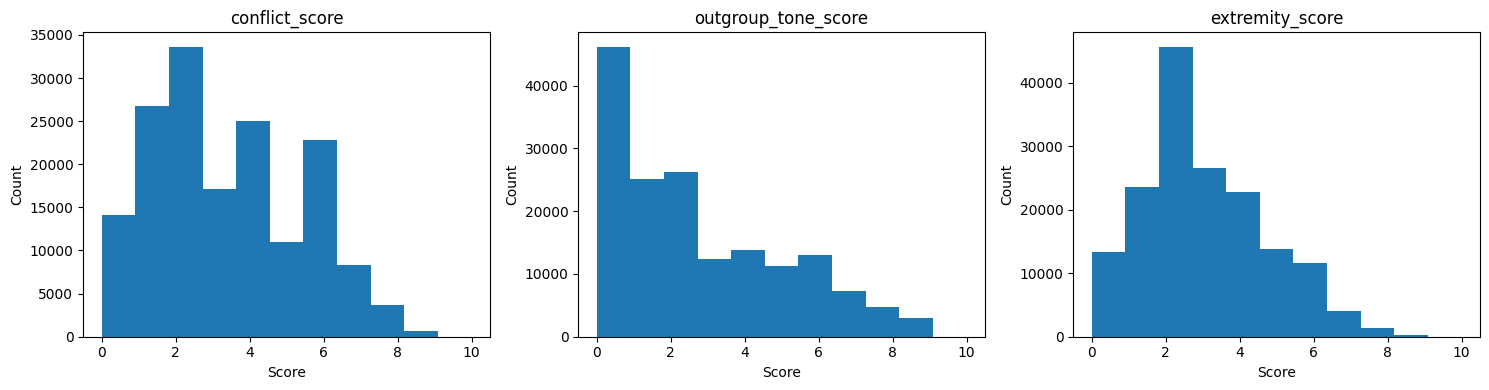

In [75]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, col in zip(axes, score_cols):
    ax.hist(df[col].dropna(), bins=11, range=(0, 10))
    ax.set_title(col)
    ax.set_xlabel("Score")
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()


In [76]:
def high_share(col, threshold):
    s = df[col].dropna()
    return (s >= threshold).mean()

for col in score_cols:
    for thr in [7, 8, 9]:
        share = high_share(col, thr)
        print(f"{col} >= {thr}: {share:.3%} of speeches")


conflict_score >= 7: 7.773% of speeches
conflict_score >= 8: 2.659% of speeches
conflict_score >= 9: 0.378% of speeches
outgroup_tone_score >= 7: 9.180% of speeches
outgroup_tone_score >= 8: 4.701% of speeches
outgroup_tone_score >= 9: 1.790% of speeches
extremity_score >= 7: 3.569% of speeches
extremity_score >= 8: 1.042% of speeches
extremity_score >= 9: 0.173% of speeches


In [77]:
corr = df[score_cols].corr()
print("Correlation matrix:")
print(corr)


Correlation matrix:
                     conflict_score  outgroup_tone_score  extremity_score
conflict_score             1.000000             0.897243         0.928967
outgroup_tone_score        0.897243             1.000000         0.871563
extremity_score            0.928967             0.871563         1.000000


In [78]:
topic_group = (
    df.groupby("macro_topic")[score_cols]
      .agg(["mean", "median", "count"])
)

# Keep only topics with at least 500 speeches
min_n = 500
topic_group = topic_group[topic_group[(score_cols[0], "count")] >= min_n]
topic_group.sort_index(inplace=True)

topic_group


conflict_score                \
                                                           mean median  count   
macro_topic                                                                     
Agriculture & fisheries                                2.890645    2.0   5505   
Climate, environment & biodiversity                    2.940336    2.0   9654   
Development & humanitarian aid                         2.977725    2.0   3771   
Digital policy & data protection                       2.768532    2.0   4735   
EU budget & MFF                                        2.788439    2.0   6868   
Economy & industrial policy                            2.935817    2.0   4939   
Education, culture & sport                             2.341959    2.0   2705   
Energy & energy security                               3.202982    3.0   4493   
Enlargement & neighbourhood policy                     3.176512    3.0   2844   
Foreign policy — Americas                              4.082486    4.0   2655   
Foreign policy — Asia-Pacific                          3.779289    4.0    956   
Foreign policy — Asia‑Pacific                          3.900000    4.0    670   
Foreign policy — Europe & Eastern Neighbourhood        4.055678    4.0   6807   
Foreign policy — Middle East & North Africa            4.221931    4.0   4195   
Foreign policy — Sub-Saharan Africa                    3.773126    4.0   1027   
Health                                                 2.582027    2.0   4529   
Institutional affairs & governance                     3.040721    3.0   5378   
Justice, security & policing                           3.234460    3.0   3314   
Media, information & disinformation                    4.011928    4.0   2012   
Migration & asylum                                     3.870173    4.0   6863   
Monetary & financial stability                         2.951261    2.0   2339   
Procedural & Parliamentary business                    2.954402    2.0  23685   
Research, innovation & space                           2.255920    2.0   1098   
Rule of law & fundamental rights                       4.010460    4.0  17208   
Security & defence                                     3.604554    4.0   4084   
Single market, competition & consumer protection       2.373410    2.0   3302   
Social policy & employment                             2.661528    2.0   7525   
Taxation & anti–money laundering                       3.256317    3.0   3285   
Trade & globalization                                  3.088476    3.0   5979   
Transport & mobility                                   2.481401    2.0   2769   

                                                 outgroup_tone_score         \
                                                                mean median   
macro_topic                                                                   
Agriculture & fisheries                                     1.823615    1.0   
Climate, environment & biodiversity                         2.003418    1.0   
Development & humanitarian aid                              2.336781    2.0   
Digital policy & data protection                            2.051109    1.0   
EU budget & MFF                                             1.900553    1.0   
Economy & industrial policy                                 2.046163    1.0   
Education, culture & sport                                  1.700555    1.0   
Energy & energy security                                    2.385266    2.0   
Enlargement & neighbourhood policy                          2.693390    2.0   
Foreign policy — Americas                                   3.860264    4.0   
Foreign policy — Asia-Pacific                               3.413180    3.0   
Foreign policy — Asia‑Pacific                               3.567164    4.0   
Foreign policy — Europe & Eastern Neighbourhood             3.812987    4.0   
Foreign policy — Middle East & North Africa                 3.810012    4.0   
Foreign policy — Sub-Saharan Afr

In [79]:
def top_topics(dim, k=10):
    col_mean = (dim, "mean")
    col_count = (score_cols[0], "count")  # any count col
    out = (
        topic_group[[col_mean, col_count]]
        .sort_values(col_mean, ascending=False)
        .head(k)
    )
    print(f"\nTop {k} macro_topics by average {dim}:")
    print(out)

for dim in score_cols:
    top_topics(dim)



Top 10 macro_topics by average conflict_score:
                                                conflict_score       
                                                          mean  count
macro_topic                                                          
Foreign policy — Middle East & North Africa           4.221931   4195
Foreign policy — Americas                             4.082486   2655
Foreign policy — Europe & Eastern Neighbourhood       4.055678   6807
Media, information & disinformation                   4.011928   2012
Rule of law & fundamental rights                      4.010460  17208
Foreign policy — Asia‑Pacific                         3.900000    670
Migration & asylum                                    3.870173   6863
Foreign policy — Asia-Pacific                         3.779289    956
Foreign policy — Sub-Saharan Africa                   3.773126   1027
Security & defence                                    3.604554   4084

Top 10 macro_topics by average outgroup_t

In [80]:
df["polarization_index"] = df[score_cols].mean(axis=1)

topic_group_poly = (
    df.groupby("macro_topic")["polarization_index"]
      .agg(["mean", "median", "count"])
)

topic_group_poly = topic_group_poly[topic_group_poly["count"] >= min_n]
print(topic_group_poly.sort_values("mean", ascending=False).head(15))


                                                     mean    median  count
macro_topic                                                               
Foreign policy — Middle East & North Africa      3.863965  3.666667   4195
Foreign policy — Americas                        3.809416  3.666667   2655
Foreign policy — Europe & Eastern Neighbourhood  3.777533  3.666667   6807
Media, information & disinformation              3.737906  3.666667   2012
Rule of law & fundamental rights                 3.676003  3.666667  17208
Foreign policy — Asia‑Pacific                    3.567662  3.666667    670
Migration & asylum                               3.481714  3.333333   6863
Foreign policy — Asia-Pacific                    3.463738  3.333333    956
Foreign policy — Sub-Saharan Africa              3.320675  3.333333   1027
Security & defence                               3.259060  3.000000   4084
Enlargement & neighbourhood policy               2.860525  2.333333   2844
Energy & energy security 

In [81]:
party_group = (
    df.groupby("political_group")[score_cols + ["polarization_index"]]
      .agg(["mean", "median", "count"])
      .sort_values(("polarization_index", "mean"), ascending=False)
)

print(party_group)


                conflict_score               outgroup_tone_score         \
                          mean median  count                mean median   
political_group                                                           
ESN                   5.947867    6.0    211            5.895735    6.0   
PfE                   5.955102    6.0    245            5.873469    6.0   
ID                    5.362515    6.0   5106            5.023698    5.0   
The Left              5.025825    5.0   6002            4.426358    5.0   
NI                    4.524289    5.0   8646            3.927365    4.0   
EFDD                  4.571788    5.0   1191            3.705290    3.0   
ECR                   4.198693    4.0  14077            3.519642    3.0   
Verts/ALE             4.044709    4.0   9394            3.296146    3.0   
Renew                 3.268225    3.0  13429            2.549482    2.0   
S&D                   3.183727    3.0  28009            2.379628    2.0   
PPE                   2.9

In [82]:
min_n_party = 1000

base = party_group[party_group[("polarization_index", "count")] >= min_n_party]

for dim in score_cols + ["polarization_index"]:
    print(f"\nTop groups by {dim} (mean, N >= {min_n_party}):")
    col_mean = (dim, "mean")
    col_count = (dim, "count")
    print(
        base[[col_mean, col_count]]
        .sort_values(col_mean, ascending=False)
        .head(10)
    )



Top groups by conflict_score (mean, N >= 1000):
                conflict_score       
                          mean  count
political_group                      
ID                    5.362515   5106
The Left              5.025825   6002
EFDD                  4.571788   1191
NI                    4.524289   8646
ECR                   4.198693  14077
Verts/ALE             4.044709   9394
Renew                 3.268225  13429
S&D                   3.183727  28009
PPE                   2.954523  31796

Top groups by outgroup_tone_score (mean, N >= 1000):
                outgroup_tone_score       
                               mean  count
political_group                           
ID                         5.023698   5106
The Left                   4.426358   6002
NI                         3.927365   8646
EFDD                       3.705290   1191
ECR                        3.519642  14077
Verts/ALE                  3.296146   9394
Renew                      2.549482  13429
S&D        

In [83]:
speaker_stats = (
    df.groupby("speaker_name")[score_cols + ["polarization_index"]]
      .agg(["mean", "median", "count"])
)

min_speeches = 20
speaker_filtered = speaker_stats[speaker_stats[("polarization_index", "count")] >= min_speeches]

for dim in score_cols + ["polarization_index"]:
    print(f"\nTop speakers by {dim} (mean, N >= {min_speeches}):")
    col_mean = (dim, "mean")
    col_count = (dim, "count")
    print(
        speaker_filtered[[col_mean, col_count]]
        .sort_values(col_mean, ascending=False)
        .head(20)
    )



Top speakers by conflict_score (mean, N >= 20):
                           conflict_score      
                                     mean count
speaker_name                                   
Anna Bryłka                      7.583333    24
Milan Mazurek                    7.423077    26
Marcel de Graaff                 7.373494    83
Tom Vandendriessche              7.294118    51
Κώστας Παπαδάκης                 7.217054   129
Petar Volgin                     7.166667    24
Irene Montero                    7.076923    26
Λευτέρης Νικολάου-Αλαβάνος       7.040268   149
Grzegorz Braun                   7.023256    43
Jaume Asens Llodrà               7.000000    26
Martin Sonneborn                 7.000000    23
Filip De Man                     6.894737    38
Hermann Tertsch                  6.883721   172
Jorge Buxadé Villalba            6.882022   178
Fabrice Leggeri                  6.862069    29
Vicky Maeijer                    6.853659    41
Diana Iovanovici Şoşoacă         6.8307

In [84]:
speaker_var = (
    df.groupby("speaker_name")[score_cols + ["polarization_index"]]
      .agg(["mean", "std", "count"])
)

speaker_var_filtered = speaker_var[speaker_var[("polarization_index", "count")] >= min_speeches]

print(
    speaker_var_filtered[[("polarization_index", "std"), ("polarization_index", "count")]]
    .sort_values(("polarization_index", "std"), ascending=False)
    .head(20)
)


                      polarization_index      
                                     std count
speaker_name                                  
Λουκάς Φουρλάς                  2.564408   124
Ελένη Σταύρου                   2.547733    24
Dolors Montserrat               2.547411   114
Hans Neuhoff                    2.512930    21
Adrián Vázquez Lázara           2.505057    44
Angel Dzhambazki                2.502949    31
Ελένη Θεοχάρους                 2.463805    55
Cynthia Ní Mhurchú              2.463535    20
François Alfonsi                2.462482    40
Βαγγέλης Μεϊμαράκης             2.453755    35
Michał Wawrykiewicz             2.415749    31
Fidias Panayiotou               2.414607    27
Dace Melbārde                   2.409905    37
Fernand Kartheiser              2.392438    26
Ioan-Rareş Bogdan               2.389328    50
Klára Dobrev                    2.358575    36
Marek Paweł Balt                2.355197    31
Matjaž Nemec                    2.352439   104
Jordi Cañas  

In [85]:
year_stats = (
    df.groupby("year")[score_cols + ["polarization_index"]]
      .mean()
      .sort_index()
)

print(year_stats)


      conflict_score  outgroup_tone_score  extremity_score  polarization_index
year                                                                          
2015        3.091915             2.144458         2.704408            2.646927
2016        3.071160             2.150865         2.689294            2.637106
2017        3.074158             2.142395         2.696350            2.637634
2018        3.086484             2.350089         2.674182            2.703585
2019        3.156325             2.555618         2.701334            2.804426
2020        3.248151             2.606912         2.858992            2.904685
2021        3.253074             2.679572         2.891313            2.941320
2022        3.369997             2.948363         2.980828            3.099729
2023        3.433606             2.924891         3.010331            3.122943
2024        3.629029             3.281824         3.285978            3.398944
2025        3.844187             3.559757         3.

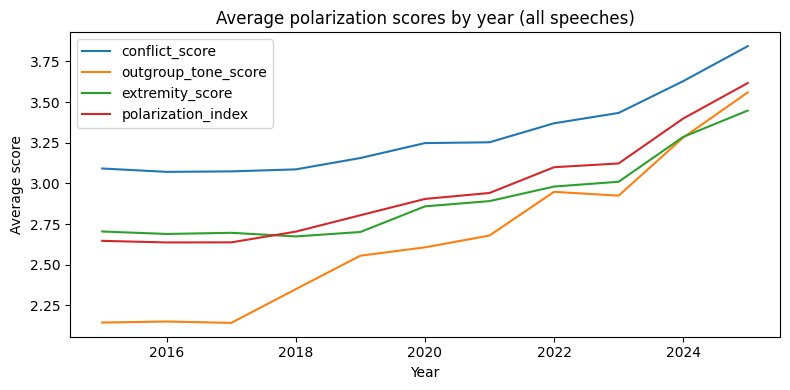

In [86]:
fig, ax = plt.subplots(figsize=(8, 4))

for col in score_cols + ["polarization_index"]:
    ax.plot(year_stats.index, year_stats[col], label=col)

ax.set_xlabel("Year")
ax.set_ylabel("Average score")
ax.set_title("Average polarization scores by year (all speeches)")
ax.legend()
plt.tight_layout()
plt.show()


In [87]:
major_groups = (
    df["political_group"]
    .value_counts()
    .head(8)                   # top 8 groups
    .index.tolist()
)

df_major = df[df["political_group"].isin(major_groups)]

year_party = (
    df_major
    .groupby(["year", "political_group"])[score_cols + ["polarization_index"]]
    .mean()
    .reset_index()
)


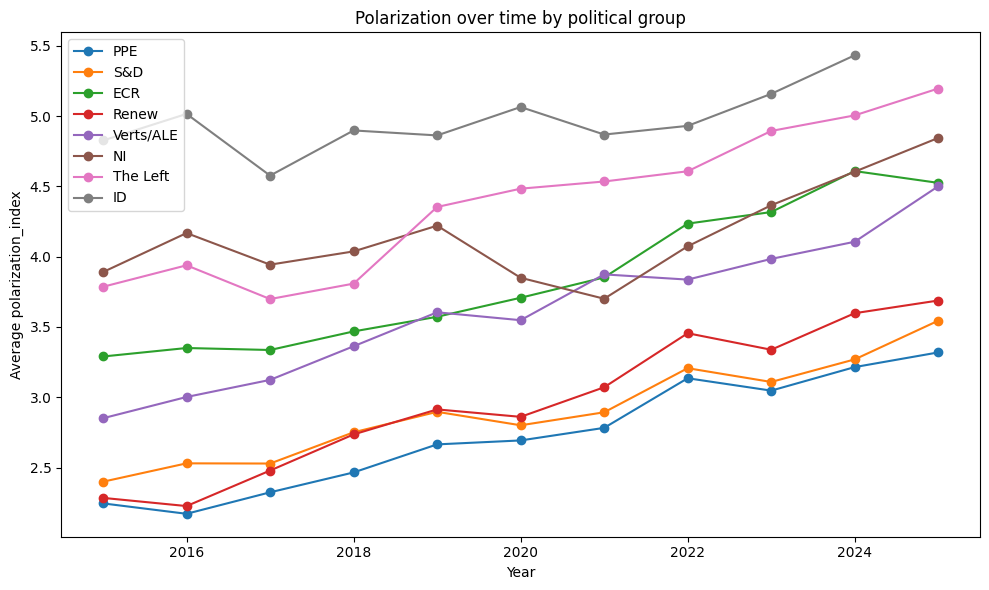

In [88]:
fig, ax = plt.subplots(figsize=(10, 6))

for grp in major_groups:
    sub = year_party[year_party["political_group"] == grp]
    ax.plot(sub["year"], sub["polarization_index"], marker="o", label=grp)

ax.set_xlabel("Year")
ax.set_ylabel("Average polarization_index")
ax.set_title("Polarization over time by political group")
ax.legend()
plt.tight_layout()
plt.show()


In [38]:
# Restrict to major groups + topics with enough speeches
min_topic_n = 500
valid_topics = (
    df["macro_topic"]
    .value_counts()
    [lambda s: s >= min_topic_n]
    .index
)

df_sub = df[
    df["political_group"].isin(major_groups) &
    df["macro_topic"].isin(valid_topics)
]

topic_party = (
    df_sub.groupby(["macro_topic", "political_group"])[score_cols + ["polarization_index"]]
          .mean()
          .reset_index()
)

topic_party.head()


,macro_topic,political_group,conflict_score,outgroup_tone_score,extremity_score,polarization_index
0,Agriculture & fisheries,ECR,3.457627,2.372881,2.941889,2.924132
1,Agriculture & fisheries,ID,4.632979,3.893617,4.085106,4.203901
2,Agriculture & fisheries,NI,3.868687,2.818182,3.398990,3.361953
3,Agriculture & fisheries,PPE,2.724250,1.581509,2.465531,2.257097
4,Agriculture & fisheries,Renew,2.632812,1.486328,2.365234,2.161458


In [89]:
dim = "polarization_index"

top_combos = (
    topic_party
    .sort_values(dim, ascending=False)
    .head(30)
)

print(top_combos[["macro_topic", "political_group", dim]])


                                         macro_topic political_group  \
153                               Migration & asylum              ID   
110      Foreign policy — Middle East & North Africa        The Left   
65                Enlargement & neighbourhood policy              ID   
78                         Foreign policy — Americas        The Left   
118              Foreign policy — Sub-Saharan Africa        The Left   
185                 Rule of law & fundamental rights              ID   
97   Foreign policy — Europe & Eastern Neighbourhood              ID   
89                     Foreign policy — Asia‑Pacific              ID   
105      Foreign policy — Middle East & North Africa              ID   
161                   Monetary & financial stability              ID   
158                               Migration & asylum        The Left   
145              Media, information & disinformation              ID   
146              Media, information & disinformation            

In [40]:
pivot_topic_party = topic_party.pivot(
    index="macro_topic",
    columns="political_group",
    values="polarization_index"
)

pivot_topic_party


political_group,ECR,ID,NI,PPE,Renew,S&D,The Left,Verts/ALE
macro_topic,,,,,,,,
Agriculture & fisheries,2.924132,4.203901,3.361953,2.257097,2.161458,2.289504,4.050162,3.587975
"Climate, environment & biodiversity",3.418372,4.668459,3.671076,2.103369,2.497933,2.409392,4.178686,3.488353
Development & humanitarian aid,3.543933,5.056911,3.477169,2.220438,2.819444,2.533065,4.995585,3.258772
Digital policy & data protection,2.976889,3.823529,3.485294,2.098211,2.529895,2.318770,4.286008,3.479401
EU budget & MFF,3.183865,4.982026,3.376374,1.954502,2.343353,2.189440,4.372659,2.818260
Economy & industrial policy,3.456790,4.479303,3.656958,2.138011,2.254902,2.293155,4.617021,3.151866
"Education, culture & sport",3.100694,4.493671,3.461059,1.665104,2.109034,1.902865,3.602410,2.682243
Energy & energy security,3.731810,4.867769,4.103093,2.401361,2.658395,2.552251,4.849711,3.432602
Enlargement & neighbourhood policy,3.962766,5.925926,4.358333,2.722727,2.657623,2.697189,5.025641,3.279221


In [41]:
def top_speeches(dim, k=20):
    cols_show = [
        "id", "date", "speaker_name", "political_group",
        "language", "macro_topic", dim, "speech_content"
    ]
    out = (
        df[cols_show]
        .dropna(subset=[dim])
        .sort_values(dim, ascending=False)
        .head(k)
    )
    return out

top_conflict = top_speeches("conflict_score", 20)
top_outgroup = top_speeches("outgroup_tone_score", 20)
top_extreme = top_speeches("extremity_score", 20)
top_index   = top_speeches("polarization_index", 20)

# For quick preview without huge text:
for name, table in [
    ("conflict_score", top_conflict),
    ("outgroup_tone_score", top_outgroup),
    ("extremity_score", top_extreme),
    ("polarization_index", top_index),
]:
    print(f"\n=== Top {len(table)} speeches by {name} ===")
    print(
        table.assign(
            speech_excerpt=lambda d: d["speech_content"].str.slice(0, 200)
        ).drop(columns=["speech_content"])
    )



=== Top 20 speeches by conflict_score ===
            id       date                speaker_name political_group  \
9049    578798 2025-01-20              Grzegorz Braun              NI   
17691   597678 2024-03-13             Ангел Джамбазки             ECR   
25292   601615 2023-10-18               Ελένη Σταύρου             PPE   
16549   595618 2024-04-23          João Pimenta Lopes        The Left   
28866   596930 2023-07-12                 Nicolas Bay              NI   
37054   607276 2023-01-18        Clara Ponsatí Obiols              NI   
134323  729763 2016-04-13            Marcel de Graaff             NaN   
46281   611015 2022-06-07             Андрей Слабаков             ECR   
21145   585720 2024-01-17  Gwendoline Delbos-Corfield       Verts/ALE   
37393   598433 2023-01-17                 Malin Björk        The Left   
85166   661942 2019-01-16         Miguel Urbán Crespo             NaN   
76319   649502 2019-10-23                  David Lega             PPE   
138738  

In [42]:
lang_stats = (
    df.groupby("language")[score_cols + ["polarization_index"]]
      .agg(["mean", "count"])
      .sort_values(("polarization_index", "count"), ascending=False)
)

min_lang_n = 1000
lang_stats_filtered = lang_stats[lang_stats[("polarization_index", "count")] >= min_lang_n]

print(lang_stats_filtered.sort_values(("polarization_index", "mean"), ascending=False).head(20))


         conflict_score        outgroup_tone_score        extremity_score  \
                   mean  count                mean  count            mean   
language                                                                    
EL             4.343184   7072            3.757919   7072        3.832579   
NL             4.032763   4853            3.287451   4853        3.548321   
SV             3.970027   2569            3.327754   2569        3.497859   
DA             3.803468   1211            3.097440   1211        3.433526   
FR             3.765070  16175            3.126615  16175        3.316723   
BG             3.618677   2313            2.960225   2313        3.164721   
ES             3.574824  12369            2.924004  12369        3.178511   
PT             3.436728   6638            2.681531   6638        3.094456   
HU             3.432570   5109            2.701311   5109        2.985516   
PL             3.351040   9187            2.644280   9187        2.934146   

Top 10 most polarizing macro_topics (overall):
                                                 mean_pol     n
macro_topic                                                    
Foreign policy — Middle East & North Africa      3.863965  4195
Foreign policy — Americas                        3.809416  2655
Foreign policy — Europe & Eastern Neighbourhood  3.777533  6807


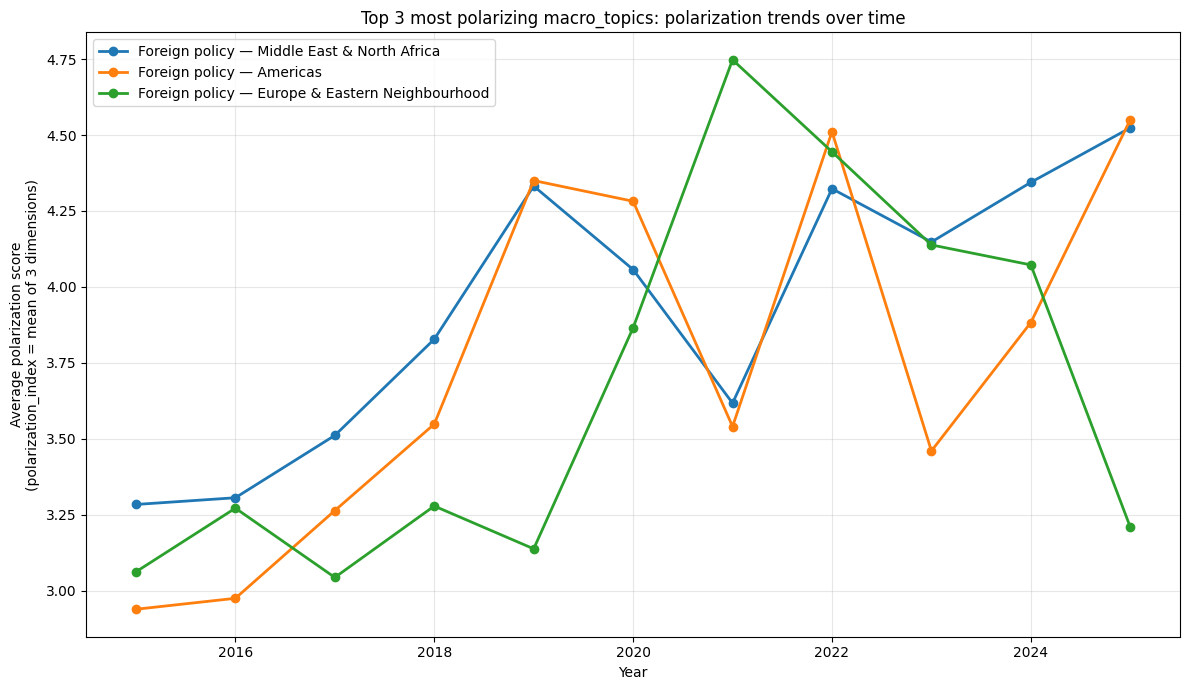

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------------
# 1. Load data and prepare basic variables
# ----------------------------------------
DATA_PATH = "eu_speeches_with_scores_final.csv"  # change if needed

df = pd.read_csv(DATA_PATH)

# Ensure numeric scores
score_cols = ["conflict_score", "outgroup_tone_score", "extremity_score"]
for c in score_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Date & year
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["year"] = df["date"].dt.year

# Drop rows without a valid year
df = df.dropna(subset=["year"])
df["year"] = df["year"].astype(int)

# ----------------------------------------
# 2. Define a single polarization index
#    (simple average of the three scores)
# ----------------------------------------
df["polarization_index"] = df[score_cols].mean(axis=1)

# Optional: restrict to speeches with all three scores present
df = df.dropna(subset=score_cols + ["polarization_index"])

# ----------------------------------------
# 3. Find top 10 most polarizing topics overall
# ----------------------------------------
# Require at least some minimum number of speeches per topic
min_n_per_topic = 200  # tweak if you want more / fewer topics considered

topic_stats = (
    df.groupby("macro_topic")["polarization_index"]
      .agg(["mean", "count"])
      .rename(columns={"mean": "mean_pol", "count": "n"})
)

topic_stats = topic_stats[topic_stats["n"] >= min_n_per_topic]

# Top 10 macro_topics by mean polarization
top10_topics = (
    topic_stats
    .sort_values("mean_pol", ascending=False)
    .head(3)
)

print("Top 10 most polarizing macro_topics (overall):")
print(top10_topics)

top10_list = top10_topics.index.tolist()

# ----------------------------------------
# 4. Compute yearly polarization for those topics
# ----------------------------------------
df_top = df[df["macro_topic"].isin(top10_list)]

year_topic = (
    df_top
    .groupby(["year", "macro_topic"])["polarization_index"]
    .agg(["mean", "count"])
    .reset_index()
    .rename(columns={"mean": "mean_pol", "count": "n"})
)

# Optional: filter out very sparse year-topic cells
min_n_per_year_topic = 20  # tweak or drop this line if you want all cells
year_topic = year_topic[year_topic["n"] >= min_n_per_year_topic]

# ----------------------------------------
# 5. Plot: trends over time for top 10 topics
# ----------------------------------------
plt.figure(figsize=(12, 7))

for topic in top10_list:
    sub = year_topic[year_topic["macro_topic"] == topic].sort_values("year")
    if sub.empty:
        continue
    plt.plot(
        sub["year"],
        sub["mean_pol"],
        marker="o",
        linewidth=2,
        label=topic
    )

plt.xlabel("Year")
plt.ylabel("Average polarization score\n(polarization_index = mean of 3 dimensions)")
plt.title("Top 3 most polarizing macro_topics: polarization trends over time")
plt.legend(loc="upper left")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


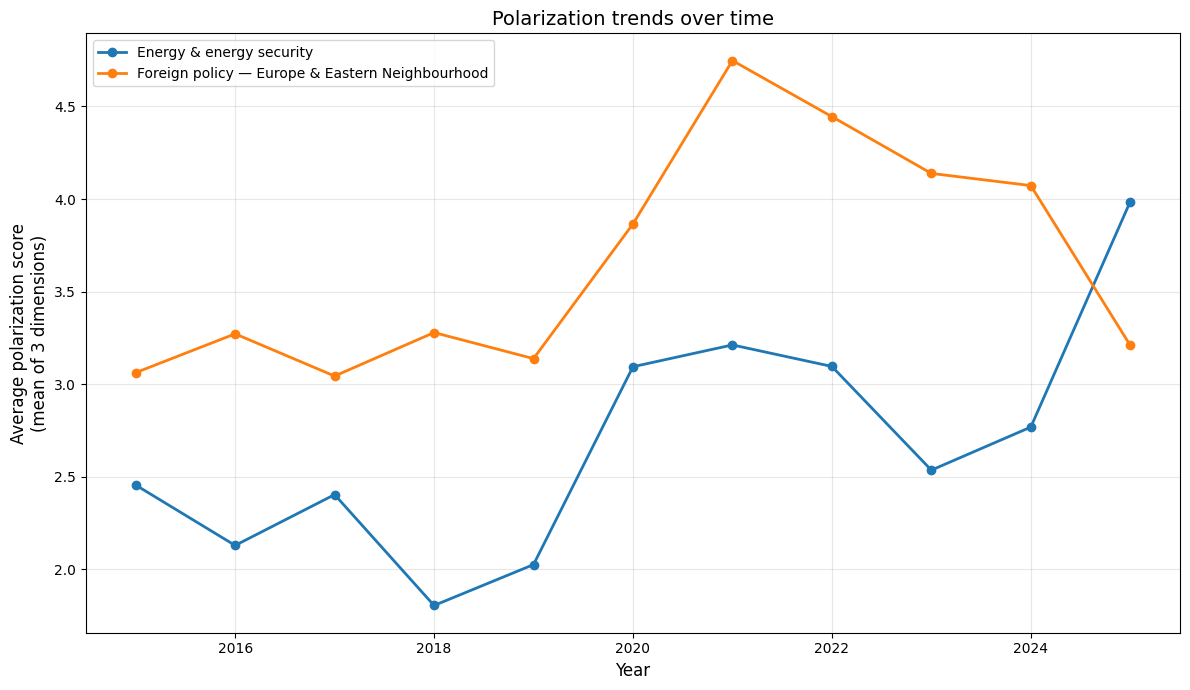

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_topic_polarization(topics, df=None, data_path="eu_speeches_with_scores_final.csv",
                           min_n_per_year_topic=20, figsize=(12, 7)):
    """
    Plot polarization trends over time for specific macro topics.
    
    Parameters:
    -----------
    topics : str or list of str
        One or more macro_topic names to plot
    df : pd.DataFrame, optional
        Pre-loaded dataframe. If None, loads from data_path
    data_path : str
        Path to CSV file (used if df is None)
    min_n_per_year_topic : int
        Minimum speeches per year-topic to include
    figsize : tuple
        Figure size (width, height)
    """
    
    # Convert single topic to list
    if isinstance(topics, str):
        topics = [topics]
    
    # Load data if not provided
    if df is None:
        df = pd.read_csv(data_path)
    
    # Prepare data
    score_cols = ["conflict_score", "outgroup_tone_score", "extremity_score"]
    for c in score_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df["year"] = df["date"].dt.year
    df = df.dropna(subset=["year"])
    df["year"] = df["year"].astype(int)
    
    df["polarization_index"] = df[score_cols].mean(axis=1)
    df = df.dropna(subset=score_cols + ["polarization_index"])
    
    # Filter to selected topics
    df_selected = df[df["macro_topic"].isin(topics)]
    
    if df_selected.empty:
        print(f"No data found for topics: {topics}")
        return
    
    # Compute yearly averages
    year_topic = (
        df_selected
        .groupby(["year", "macro_topic"])["polarization_index"]
        .agg(["mean", "count"])
        .reset_index()
        .rename(columns={"mean": "mean_pol", "count": "n"})
    )
    
    year_topic = year_topic[year_topic["n"] >= min_n_per_year_topic]
    
    # Plot
    plt.figure(figsize=figsize)
    
    for topic in topics:
        sub = year_topic[year_topic["macro_topic"] == topic].sort_values("year")
        if sub.empty:
            print(f"Warning: No data for '{topic}' after filtering")
            continue
        
        plt.plot(
            sub["year"],
            sub["mean_pol"],
            marker="o",
            linewidth=2,
            label=topic
        )
    
    plt.xlabel("Year", fontsize=12)
    plt.ylabel("Average polarization score\n(mean of 3 dimensions)", fontsize=12)
    plt.title(f"Polarization trends over time", fontsize=14)
    plt.legend(loc="best")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# ==========================================
# USAGE EXAMPLES
# ==========================================

# Example 1: Single topic
#plot_topic_polarization("Climate, environment & biodiversity")

# Example 2: Multiple specific topics
plot_topic_polarization([
    "Energy & energy security",
    "Foreign policy — Europe & Eastern Neighbourhood",
])

# # Example 3: Using pre-loaded dataframe (more efficient for multiple plots)
# #df = pd.read_csv("eu_speeches_with_scores_final.csv")

# plot_topic_polarization("Climate, environment & biodiversity", df=df)
# plot_topic_polarization(["Health", "Education, culture & sport"], df=df)

# # Example 4: Lower threshold for sparse topics
# plot_topic_polarization(
#     ["Research, innovation & space", "Transport & mobility"],
#     min_n_per_year_topic=10,
#     figsize=(14, 8)
# )

In [98]:
# List all available macro topics
print(df["macro_topic"].value_counts().head(20))

macro_topic
Procedural & Parliamentary business                 23685
Rule of law & fundamental rights                    17208
Climate, environment & biodiversity                  9654
Social policy & employment                           7525
EU budget & MFF                                      6868
Migration & asylum                                   6863
Foreign policy — Europe & Eastern Neighbourhood      6807
Trade & globalization                                5979
Agriculture & fisheries                              5505
Institutional affairs & governance                   5378
Economy & industrial policy                          4939
Digital policy & data protection                     4735
Health                                               4529
Energy & energy security                             4493
Foreign policy — Middle East & North Africa          4195
Security & defence                                   4084
Development & humanitarian aid                       3771
Ju

## CPC Calculation Pipeline

In [45]:
import pandas as pd

df = pd.read_csv("eu_speeches_with_scores_final.csv")

# make sure scores are numeric
for col in ["conflict_score", "outgroup_tone_score", "extremity_score"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")


In [46]:
SCORE_COLS = ["conflict_score", "outgroup_tone_score", "extremity_score"]

def run_macro_series_scores(
    df,
    macro_topic,
    languages=None,
    *,
    # mode switch:
    mode="speaker",                 # "speaker" | "speech_capped" | "speech_weighted"
    cap_per_speaker=5,              # used only if mode=="speech_capped"
    keep_min_speakers=0,            # speaker-mode only: drop parties with < keep_min_speakers speakers (0 = off)
    min_speeches_per_party=30,      # speech_* modes: min speeches/party/bin (after cap for speech_capped)
    min_unique_speakers_per_party=5,# speech_* modes: also require ≥ this many distinct speakers/party/bin
    require_parties=3,              # both modes: require at least this many parties kept
    weight_by="count",              # speech_weighted only: "count" or "tokens"
    demean_level="language_topic",  # "language_topic" (default), "language", or None
    shuffle_strata="language_topic",# "language_topic" | "language" | "topic" | None
    drop_parties=("ID",),           # parties to drop; set to None or () to keep all
    time_bin=None,                  # override global TIME_BIN if not None
    model_name=None,                # kept for API compatibility (ignored here)
    pca_max_dims=None,              # kept for API compatibility (ignored here)
    use_cpc_adj=True,               # if True, z/CI are based on CPC_adj when defined, else CPC
    null_iters=None,
    boot_iters=None,
):
    """
    Mehlhaff-style CPC pipeline, but instead of embeddings we use
    the 3 LLM scores as a 3D feature space:

        X = [conflict_score, outgroup_tone_score, extremity_score]

    Everything else (three modes, CPC & CPC_adj, permutations, bootstraps,
    pairwise standardized centroid distances) is identical in structure.
    """

    # --------- resolve defaults ----------
    if time_bin is None:
        time_bin = TIME_BIN
    if null_iters is None:
        null_iters = NULL_ITERS
    if boot_iters is None:
        boot_iters = BOOT_ITERS

    # --------- filter / hygiene ----------
    if (macro_topic is None) or (str(macro_topic).lower() in {"all", "__all__", "overall"}):
        d = df.copy()
        macro_label = "All speeches"
    else:
        d = df[df["macro_topic"] == macro_topic].copy()
        macro_label = macro_topic

    if languages is not None:
        d = d[d["language"].isin(languages)].copy()

    needed = ["political_group", "speech_content", "speaker_name",
              "topic", "language", "date"] + SCORE_COLS
    d = d.dropna(subset=needed)

    # crude length guardrail as in original pipeline
    d = d[d["speech_content"].astype(str).str.len() >= 40]

    if drop_parties:
        d = d[~d["political_group"].isin(drop_parties)].copy()

    # time bin
    d["date"] = pd.to_datetime(d["date"], errors="coerce")
    d = d.dropna(subset=["date"])
    d["time_bin"] = d["date"].dt.to_period(time_bin).dt.to_timestamp()
    d = d.reset_index(drop=True)

    if d.empty:
        return pd.DataFrame(
            columns=[
                "languages","macro_topic","time_bin","ok","reason",
                "obs_bss_tss","cpc","cpc_adj","bss","wss","tss",
                "null_mean","null_sd","z","ci_lo","ci_hi",
                "n_docs","n_parties","counts","mode","weight_by"
            ]
        ), None

    # --------- build 3D score matrix for this macro slice ----------
    # X_all[i] = [conflict, outgroup, extremity] for speech i in d
    X_all = d[SCORE_COLS].astype(float).to_numpy()

    # optional demeaning by language / language×topic like in embedding pipeline
    langs  = d["language"].astype(str).values
    topics = d["topic"].astype(str).values

    X_adj = X_all.copy()

    if demean_level in {"language", "language_topic"}:
        # (a) center within language
        for lg in np.unique(langs):
            m = (langs == lg)
            if m.any():
                X_adj[m] -= X_adj[m].mean(axis=0, keepdims=True)
    if demean_level == "language_topic":
        # (b) finer: center within (language × micro-topic)
        for lg in np.unique(langs):
            for tp in np.unique(topics):
                m = (langs == lg) & (topics == tp)
                if m.any():
                    X_adj[m] -= X_adj[m].mean(axis=0, keepdims=True)

    # global centering not needed; CPC is translation-invariant
    # we just work on X_adj directly
    X_full = X_adj

    rows = []
    pw   = None

    def _pick(obs_stats):
        """Choose CPC_adj if defined & requested, otherwise CPC."""
        cpc_raw = obs_stats["CPC"]
        cpc_adj = obs_stats["CPC_adj"]
        if use_cpc_adj and np.isfinite(cpc_adj):
            return cpc_adj
        return cpc_raw

    # --------- per-bin loop ----------
    for bin_val, g in d.groupby("time_bin", sort=True):
        idx   = g.index.to_numpy()
        X_bin = X_full[idx]
        d_bin = d.iloc[idx].copy().reset_index(drop=True)

        if d_bin.empty:
            continue

        # ===== MODE: SPEAKER =====
        if mode == "speaker":
            X_mat, y_lab = _aggregate_by_speaker(X_bin, d_bin)
            counts = pd.Series(y_lab).value_counts()

            if keep_min_speakers and keep_min_speakers > 0:
                keep = counts[counts >= keep_min_speakers].index
                sel  = np.isin(y_lab, keep)
                X_mat, y_lab = X_mat[sel], y_lab[sel]
                counts = pd.Series(y_lab).value_counts()

            ok_bin = (len(counts) >= require_parties) and (counts.min() >= MIN_PER_PARTY)

            if not ok_bin:
                rows.append(
                    {
                        "languages": ",".join(sorted(d_bin["language"].unique())),
                        "macro_topic": macro_label,
                        "time_bin": bin_val,
                        "ok": False,
                        "reason": "low_n",
                        "obs_bss_tss": np.nan,
                        "cpc": np.nan,
                        "cpc_adj": np.nan,
                        "bss": np.nan,
                        "wss": np.nan,
                        "tss": np.nan,
                        "null_mean": np.nan,
                        "null_sd": np.nan,
                        "z": np.nan,
                        "ci_lo": np.nan,
                        "ci_hi": np.nan,
                        "n_docs": int(len(y_lab)),
                        "n_parties": int(len(counts)),
                        "counts": counts.to_dict(),
                        "mode": mode,
                        "weight_by": None,
                    }
                )
                continue

            # observed CPC / CPC_adj
            obs_stats = compute_cpc(X_mat, y_lab)
            obs_val   = _pick(obs_stats)

            # permutation: stratify; shuffle at SPEAKER level
            rng = np.random.default_rng(42)
            spk = d_bin.groupby("speaker_name", sort=False)["political_group"].agg(
                lambda x: x.mode().iloc[0]
            ).astype(str)
            spk_lg = d_bin.groupby("speaker_name", sort=False)["language"].agg(
                lambda x: x.mode().iloc[0]
            ).astype(str)
            spk_tp = d_bin.groupby("speaker_name", sort=False)["topic"].agg(
                lambda x: x.mode().iloc[0]
            ).astype(str)
            spk_df = pd.DataFrame(
                {"lab": spk.values, "lg": spk_lg.values, "tp": spk_tp.values},
                index=spk.index,
            )

            nulls = []
            for _ in range(null_iters):
                perm = spk_df["lab"].copy()
                if shuffle_strata == "language_topic":
                    groups = spk_df.groupby(["lg", "tp"], sort=False)
                elif shuffle_strata == "language":
                    groups = spk_df.groupby(["lg"], sort=False)
                elif shuffle_strata == "topic":
                    groups = spk_df.groupby(["tp"], sort=False)
                else:
                    groups = [("_all", spk_df)]
                for _, block in groups:
                    vals = block["lab"].to_numpy().copy()
                    rng.shuffle(vals)
                    perm.loc[block.index] = vals
                y_perm     = perm.values
                perm_stats = compute_cpc(X_mat, y_perm)
                nulls.append(_pick(perm_stats))
            nulls     = np.array(nulls)
            null_mean = float(nulls.mean())
            null_sd   = float(nulls.std(ddof=1))

            # cluster bootstrap by speaker
            rngb = np.random.default_rng(1000)
            n_spk = len(y_lab)
            boots = []
            for _ in range(boot_iters):
                b = rngb.integers(0, n_spk, size=n_spk)
                boot_stats = compute_cpc(X_mat[b], y_lab[b])
                boots.append(_pick(boot_stats))
            lo, hi = np.percentile(boots, [2.5, 97.5])

        # ===== MODE: SPEECH (capped) =====
        elif mode == "speech_capped":
            out = _build_speech_matrix(X_bin, d_bin, cap_per_speaker=cap_per_speaker)
            X_use, y_use, spk_ids, lg_use, tp_use, w_use = out
            if X_use is None:
                rows.append(
                    {
                        "languages": ",".join(sorted(d_bin["language"].unique())),
                        "macro_topic": macro_label,
                        "time_bin": bin_val,
                        "ok": False,
                        "reason": "empty",
                        "obs_bss_tss": np.nan,
                        "cpc": np.nan,
                        "cpc_adj": np.nan,
                        "bss": np.nan,
                        "wss": np.nan,
                        "tss": np.nan,
                        "null_mean": np.nan,
                        "null_sd": np.nan,
                        "z": np.nan,
                        "ci_lo": np.nan,
                        "ci_hi": np.nan,
                        "n_docs": 0,
                        "n_parties": 0,
                        "counts": {},
                        "mode": mode,
                        "weight_by": None,
                    }
                )
                continue

            counts_speech = pd.Series(y_use).value_counts()
            spk_party = pd.Series(spk_ids).groupby(pd.Series(y_use)).nunique()

            keep_parties = [
                p
                for p in counts_speech.index
                if (counts_speech.get(p, 0) >= min_speeches_per_party)
                and (spk_party.get(p, 0) >= min_unique_speakers_per_party)
            ]

            m = np.isin(y_use, keep_parties)
            X_mat, y_lab = X_use[m], y_use[m]
            spk_ids, lg_use, tp_use, w_use = (
                spk_ids[m],
                lg_use[m],
                tp_use[m],
                w_use[m],
            )
            counts = pd.Series(y_lab).value_counts()
            ok_bin = len(counts) >= require_parties

            if not ok_bin:
                rows.append(
                    {
                        "languages": ",".join(sorted(d_bin["language"].unique())),
                        "macro_topic": macro_label,
                        "time_bin": bin_val,
                        "ok": False,
                        "reason": "low_n",
                        "obs_bss_tss": np.nan,
                        "cpc": np.nan,
                        "cpc_adj": np.nan,
                        "bss": np.nan,
                        "wss": np.nan,
                        "tss": np.nan,
                        "null_mean": np.nan,
                        "null_sd": np.nan,
                        "z": np.nan,
                        "ci_lo": np.nan,
                        "ci_hi": np.nan,
                        "n_docs": int(len(y_lab)),
                        "n_parties": int(len(counts)),
                        "counts": counts.to_dict(),
                        "mode": mode,
                        "weight_by": None,
                    }
                )
                continue

            obs_stats = compute_cpc(X_mat, y_lab)
            obs_val   = _pick(obs_stats)

            # permutation (clustered by speaker)
            rng = np.random.default_rng(42)
            sel = pd.DataFrame(
                {"spk": spk_ids, "lab": y_lab, "lg": lg_use, "tp": tp_use}
            )
            spk_major = sel.groupby("spk", sort=False)["lab"].agg(
                lambda x: x.mode().iloc[0]
            )
            spk_meta = sel.groupby("spk", sort=False)[["lg", "tp"]].agg(
                lambda x: x.iloc[0]
            )

            nulls = []
            for _ in range(null_iters):
                perm_spk_lab = spk_major.copy()
                if shuffle_strata == "language_topic":
                    groups = spk_meta.groupby(["lg", "tp"], sort=False)
                elif shuffle_strata == "language":
                    groups = spk_meta.groupby(["lg"], sort=False)
                elif shuffle_strata == "topic":
                    groups = spk_meta.groupby(["tp"], sort=False)
                else:
                    groups = [("_all", spk_meta)]
                for _, block in groups:
                    vals = perm_spk_lab.loc[block.index].to_numpy().copy()
                    rng.shuffle(vals)
                    perm_spk_lab.loc[block.index] = vals
                y_perm = sel["spk"].map(perm_spk_lab).to_numpy()
                perm_stats = compute_cpc(X_mat, y_perm)
                nulls.append(_pick(perm_stats))
            nulls     = np.array(nulls)
            null_mean = float(nulls.mean())
            null_sd   = float(nulls.std(ddof=1))

            # clustered bootstrap by speaker
            rngb = np.random.default_rng(1000)
            unique_spk = np.unique(spk_ids)
            boots = []
            for _ in range(boot_iters):
                draw = rngb.choice(unique_spk, size=len(unique_spk), replace=True)
                take = np.isin(spk_ids, draw)
                boot_stats = compute_cpc(X_mat[take], y_lab[take])
                boots.append(_pick(boot_stats))
            lo, hi = np.percentile(boots, [2.5, 97.5])

        # ===== MODE: SPEECH (weighted) =====
        elif mode == "speech_weighted":
            X_mat = X_bin
            y_lab = d_bin["political_group"].astype(str).values
            if weight_by == "tokens":
                w = np.array(
                    [_length_in_tokens(t) for t in d_bin["speech_content"]],
                    dtype=float,
                )
            else:
                w = None

            counts_speech = pd.Series(y_lab).value_counts()
            uniq_spk_per_party = d_bin.groupby("political_group")["speaker_name"].nunique()
            keep_parties = [
                p
                for p in counts_speech.index
                if (counts_speech.get(p, 0) >= min_speeches_per_party)
                and (uniq_spk_per_party.get(p, 0) >= min_unique_speakers_per_party)
            ]
            sel = np.isin(y_lab, keep_parties)
            X_mat, y_lab = X_mat[sel], y_lab[sel]
            w = None if w is None else w[sel]
            counts = pd.Series(y_lab).value_counts()
            ok_bin = len(counts) >= require_parties

            if not ok_bin:
                rows.append(
                    {
                        "languages": ",".join(sorted(d_bin["language"].unique())),
                        "macro_topic": macro_label,
                        "time_bin": bin_val,
                        "ok": False,
                        "reason": "low_n",
                        "obs_bss_tss": np.nan,
                        "cpc": np.nan,
                        "cpc_adj": np.nan,
                        "bss": np.nan,
                        "wss": np.nan,
                        "tss": np.nan,
                        "null_mean": np.nan,
                        "null_sd": np.nan,
                        "z": np.nan,
                        "ci_lo": np.nan,
                        "ci_hi": np.nan,
                        "n_docs": int(len(y_lab)),
                        "n_parties": int(len(counts)),
                        "counts": counts.to_dict(),
                        "mode": mode,
                        "weight_by": weight_by,
                    }
                )
                continue

            # weighted CPC (CPC_adj left NaN when weights used)
            obs_stats = compute_cpc(X_mat, y_lab, w=w)
            obs_val   = _pick(obs_stats)

            rng = np.random.default_rng(42)
            spk_cats = pd.Categorical(d_bin["speaker_name"].astype(str).iloc[sel])
            spk_ids  = spk_cats.codes
            lg_use   = d_bin["language"].astype(str).iloc[sel].values
            tp_use   = d_bin["topic"].astype(str).iloc[sel].values

            sel_df = pd.DataFrame(
                {"spk": spk_ids, "lab": y_lab, "lg": lg_use, "tp": tp_use}
            )
            spk_major = sel_df.groupby("spk", sort=False)["lab"].agg(
                lambda x: x.mode().iloc[0]
            )
            spk_meta = sel_df.groupby("spk", sort=False)[["lg", "tp"]].agg(
                lambda x: x.iloc[0]
            )

            nulls = []
            for _ in range(null_iters):
                perm_spk_lab = spk_major.copy()
                if shuffle_strata == "language_topic":
                    groups = spk_meta.groupby(["lg", "tp"], sort=False)
                elif shuffle_strata == "language":
                    groups = spk_meta.groupby(["lg"], sort=False)
                elif shuffle_strata == "topic":
                    groups = spk_meta.groupby(["tp"], sort=False)
                else:
                    groups = [("_all", spk_meta)]
                for _, block in groups:
                    vals = perm_spk_lab.loc[block.index].to_numpy().copy()
                    rng.shuffle(vals)
                    perm_spk_lab.loc[block.index] = vals
                y_perm = sel_df["spk"].map(perm_spk_lab).to_numpy()
                perm_stats = compute_cpc(X_mat, y_perm, w=w)
                nulls.append(_pick(perm_stats))
            nulls     = np.array(nulls)
            null_mean = float(nulls.mean())
            null_sd   = float(nulls.std(ddof=1))

            # clustered bootstrap by speaker
            rngb = np.random.default_rng(1000)
            unique_spk = np.unique(spk_ids)
            boots = []
            for _ in range(boot_iters):
                draw = rngb.choice(unique_spk, size=len(unique_spk), replace=True)
                take = np.isin(spk_ids, draw)
                boot_stats = compute_cpc(
                    X_mat[take],
                    y_lab[take],
                    w=None if w is None else w[take],
                )
                boots.append(_pick(boot_stats))
            lo, hi = np.percentile(boots, [2.5, 97.5])

        else:
            raise ValueError("mode must be 'speaker', 'speech_capped', or 'speech_weighted'")

        rows.append(
            {
                "languages": ",".join(sorted(d_bin["language"].unique())),
                "macro_topic": macro_label,
                "time_bin": bin_val,
                "ok": True,
                "reason": None,
                "obs_bss_tss": float(obs_val),
                "cpc": float(obs_stats["CPC"]),
                "cpc_adj": float(obs_stats["CPC_adj"]),
                "bss": float(obs_stats["BSS"]),
                "wss": float(obs_stats["WSS"]),
                "tss": float(obs_stats["TSS"]),
                "null_mean": float(null_mean),
                "null_sd": float(null_sd),
                "z": float((obs_val - null_mean) / (null_sd + 1e-12)),
                "ci_lo": float(lo),
                "ci_hi": float(hi),
                "n_docs": int(X_mat.shape[0]),
                "n_parties": int(len(counts)),
                "counts": counts.to_dict(),
                "mode": mode,
                "weight_by": (weight_by if mode == "speech_weighted" else None),
            }
        )

    res = pd.DataFrame(rows).sort_values("time_bin")

    # --------- pairwise distances for latest valid bin ----------
    valid = res[res["ok"]]
    if not valid.empty:
        latest_bin = valid["time_bin"].max()
        idx   = d.index[d["time_bin"] == latest_bin].to_numpy()
        X_bin = X_full[idx]
        d_bin = d.iloc[idx].copy().reset_index(drop=True)

        if mode == "speaker":
            X_latest, y_latest = _aggregate_by_speaker(X_bin, d_bin)

        elif mode == "speech_capped":
            out = _build_speech_matrix(X_bin, d_bin, cap_per_speaker=cap_per_speaker)
            X_use, y_use, spk_ids, lg_use, tp_use, w_use = out
            if X_use is None:
                return res, None
            counts_speech = pd.Series(y_use).value_counts()
            spk_party = pd.Series(spk_ids).groupby(pd.Series(y_use)).nunique()
            keep_parties = [
                p
                for p in counts_speech.index
                if (counts_speech.get(p, 0) >= min_speeches_per_party)
                and (spk_party.get(p, 0) >= min_unique_speakers_per_party)
            ]
            m = np.isin(y_use, keep_parties)
            X_latest, y_latest = X_use[m], y_use[m]

        else:  # speech_weighted
            X_latest = X_bin
            y_latest = d_bin["political_group"].astype(str).values
            counts_speech = pd.Series(y_latest).value_counts()
            uniq_spk_per_party = d_bin.groupby("political_group")["speaker_name"].nunique()
            keep_parties = [
                p
                for p in counts_speech.index
                if (counts_speech.get(p, 0) >= min_speeches_per_party)
                and (uniq_spk_per_party.get(p, 0) >= min_unique_speakers_per_party)
            ]
            m = np.isin(y_latest, keep_parties)
            X_latest, y_latest = X_latest[m], y_latest[m]

        if len(np.unique(y_latest)) >= 2:
            pw = pairwise_std_centroid_dists(X_latest, y_latest)
        else:
            pw = None
    else:
        pw = None

    return res, pw


In [47]:
import numpy as np, pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA

# ===== settings (defaults; can be overridden in run_macro_series) =====
TIME_BIN   = "Y"   # "Y", "2Y", "3Y"
MIN_PER_PARTY = 10
NULL_ITERS = 300
BOOT_ITERS = 300
MODEL_NAME = "sentence-transformers/paraphrase-multilingual-mpnet-base-v2"
MAX_DIMS   = 100
BOILER = [
    "mr president","madam president","honourable members",
    "president","commissioner","high representative","thank you"
]

# ===== helpers =====

def _scrub_boiler(s: str) -> str:
    s = str(s).lower()
    for b in BOILER:
        s = s.replace(b, " ")
    return s

def _length_in_tokens(text) -> int:
    """Crude proxy for speaking time; replace with duration if available."""
    return max(1, len(str(text).split()))

def compute_cpc(X, y, w=None):
    """
    Compute Cluster-Polarization Coefficient (CPC) and adjusted CPC (CPC_adj).

    Parameters
    ----------
    X : array-like, shape (N, J)
        Data matrix (e.g., embeddings or PCA scores).
    y : array-like, shape (N,)
        Group labels (e.g., party IDs).
    w : array-like, shape (N,), optional
        Optional non-negative weights. If provided, returns a weighted CPC.
        CPC_adj is only computed for the unweighted case (w is None).

    Returns
    -------
    stats : dict
        {
          "BSS", "WSS", "TSS",
          "CPC", "CPC_adj",
          "N", "J", "K"
        }
    """
    X = np.asarray(X)
    y = np.asarray(y)
    N, J = X.shape
    groups, counts = np.unique(y, return_counts=True)
    K = len(groups)

    if w is None:
        # Unweighted CPC
        mu = X.mean(axis=0)
        WSS = 0.0
        BSS = 0.0
        for g, n_g in zip(groups, counts):
            Xg = X[y == g]
            mug = Xg.mean(axis=0)
            WSS += ((Xg - mug) ** 2).sum()
            BSS += n_g * ((mug - mu) ** 2).sum()
        TSS = BSS + WSS
        CPC = BSS / (TSS + 1e-12)

        # Adjusted CPC (Equation 3 in Mehlhaff)
        if (N > J) and (N > J * K) and (N - J * K) != 0:
            CPC_adj = 1.0 - (1.0 - CPC) * (N - J) / (N - J * K)
        else:
            CPC_adj = np.nan
    else:
        # Weighted case: CPC is well-defined; CPC_adj is left as NaN
        w = np.asarray(w, dtype=float)
        w = np.clip(w, 0.0, None)
        if w.sum() <= 0:
            raise ValueError("All weights are zero or negative.")
        W = w / w.sum()

        mu = (W[:, None] * X).sum(axis=0)
        TSS = (W[:, None] * (X - mu) ** 2).sum()

        BSS = 0.0
        WSS = 0.0
        for g in groups:
            m = (y == g)
            Wg = W[m]
            Xg = X[m]
            wg_sum = Wg.sum()
            if wg_sum <= 0:
                continue
            mug = (Wg[:, None] * Xg).sum(axis=0) / wg_sum
            WSS += (Wg[:, None] * (Xg - mug) ** 2).sum()
            BSS += wg_sum * ((mug - mu) ** 2).sum()

        CPC = BSS / (TSS + 1e-12)
        CPC_adj = np.nan  # not defined in Mehlhaff for weighted case

    return {
        "BSS": float(BSS),
        "WSS": float(WSS),
        "TSS": float(TSS),
        "CPC": float(CPC),
        "CPC_adj": float(CPC_adj),
        "N": int(N),
        "J": int(J),
        "K": int(len(groups)),
    }

def between_within_scatter(X, labels):
    """Legacy helper returning (BSS, WSS, TSS); thin wrapper around compute_cpc."""
    stats = compute_cpc(X, labels)
    return stats["BSS"], stats["WSS"], stats["TSS"]

def bss_tss(X, y):
    """Legacy helper: returns raw CPC = BSS/TSS (unadjusted)."""
    stats = compute_cpc(X, y)
    return stats["CPC"]

def _weighted_cpc(X, y, w):
    """Weighted CPC convenience wrapper."""
    stats = compute_cpc(X, y, w=w)
    return stats["CPC"]

def pairwise_std_centroid_dists(X, y):
    """
    Pairwise standardized centroid distances between groups.

    Effect-size style metric: ||mu_a - mu_b|| divided by the average
    within-group spread of a and b. Not part of CPC; purely descriptive.
    """
    X = np.asarray(X)
    y = np.asarray(y)
    groups = np.unique(y)
    cents = {g: X[y == g].mean(axis=0) for g in groups}
    pooled = {}
    for g in groups:
        Xg = X[y == g]
        mu = cents[g]
        if Xg.shape[0] <= 1:
            pooled[g] = 0.0
        else:
            pooled[g] = float(
                np.sqrt(((Xg - mu) ** 2).sum() / max(Xg.shape[0] - 1, 1))
            )
    rows = []
    for i, a in enumerate(groups):
        for b in groups[i + 1 :]:
            num = float(np.linalg.norm(cents[a] - cents[b]))
            denom = 0.5 * (pooled[a] + pooled[b]) + 1e-12
            rows.append((a, b, num / denom))
    return pd.DataFrame(rows, columns=["party_a", "party_b", "std_dist"]).sort_values(
        "std_dist", ascending=False
    )

def _aggregate_by_speaker(X_bin, df_bin):
    """Equal weight per speaker (one vector per MEP per bin)."""
    Xs, ys = [], []
    for _, g in df_bin.groupby("speaker_name", sort=False):
        pos = g.index.to_numpy()  # df_bin must be 0..N-1 (reset_index done upstream)
        Xs.append(X_bin[pos].mean(axis=0))
        ys.append(g["political_group"].mode().iloc[0])
    return np.stack(Xs), np.array(ys)

def _build_speech_matrix(X_bin, d_bin, cap_per_speaker=5):
    """
    Speech-level design with a per-speaker cap to avoid dominance.
    Returns: X_use, y_use, spk_ids, lg_use, tp_use, w_use  (aligned arrays)
    """
    take_idx, spk_codes = [], []
    spk_cats = pd.Categorical(d_bin["speaker_name"].astype(str))
    spk_id_all = spk_cats.codes  # 0..S-1 for all rows

    # take first `cap_per_speaker` speeches per speaker (stable order)
    for sid in np.unique(spk_id_all):
        idxs = np.where(spk_id_all == sid)[0]
        take_idx.extend(idxs[:cap_per_speaker])
        spk_codes.extend([sid] * min(len(idxs), cap_per_speaker))

    if not take_idx:
        return None, None, None, None, None, None

    take_idx = np.array(take_idx, dtype=int)
    spk_codes = np.array(spk_codes, dtype=int)

    X_use = X_bin[take_idx]
    y_use = d_bin["political_group"].astype(str).iloc[take_idx].values
    lg_use = d_bin["language"].astype(str).iloc[take_idx].values
    tp_use = d_bin["topic"].astype(str).iloc[take_idx].values
    w_use = np.array(
        [_length_in_tokens(t) for t in d_bin["speech_content"].iloc[take_idx]],
        dtype=float,
    )
    return X_use, y_use, spk_codes, lg_use, tp_use, w_use

# ===== main: multilingual, language-centered, agenda-controlled =====
SCORE_COLS = ["conflict_score", "outgroup_tone_score", "extremity_score"]

def run_macro_series_scores(
    df,
    macro_topic,
    languages=None,
    *,
    # mode switch:
    mode="speaker",                 # "speaker" | "speech_capped" | "speech_weighted"
    cap_per_speaker=5,              # used only if mode=="speech_capped"
    keep_min_speakers=0,            # speaker-mode only: drop parties with < keep_min_speakers speakers (0 = off)
    min_speeches_per_party=30,      # speech_* modes: min speeches/party/bin (after cap for speech_capped)
    min_unique_speakers_per_party=5,# speech_* modes: also require ≥ this many distinct speakers/party/bin
    require_parties=3,              # both modes: require at least this many parties kept
    weight_by="count",              # speech_weighted only: "count" or "tokens"
    demean_level="language_topic",  # "language_topic" (default), "language", or None
    shuffle_strata="language_topic",# "language_topic" | "language" | "topic" | None
    drop_parties=("ID",),           # parties to drop; set to None or () to keep all
    time_bin=None,                  # override global TIME_BIN if not None
    model_name=None,                # kept for API compatibility (ignored here)
    pca_max_dims=None,              # kept for API compatibility (ignored here)
    use_cpc_adj=True,               # if True, z/CI are based on CPC_adj when defined, else CPC
    null_iters=None,
    boot_iters=None,
):
    """
    Mehlhaff-style CPC pipeline, but instead of embeddings we use
    the 3 LLM scores as a 3D feature space:

        X = [conflict_score, outgroup_tone_score, extremity_score]

    Everything else (three modes, CPC & CPC_adj, permutations, bootstraps,
    pairwise standardized centroid distances) is identical in structure.
    """

    # --------- resolve defaults ----------
    if time_bin is None:
        time_bin = TIME_BIN
    if null_iters is None:
        null_iters = NULL_ITERS
    if boot_iters is None:
        boot_iters = BOOT_ITERS

    # --------- filter / hygiene ----------
    if (macro_topic is None) or (str(macro_topic).lower() in {"all", "__all__", "overall"}):
        d = df.copy()
        macro_label = "All speeches"
    else:
        d = df[df["macro_topic"] == macro_topic].copy()
        macro_label = macro_topic

    if languages is not None:
        d = d[d["language"].isin(languages)].copy()

    needed = ["political_group", "speech_content", "speaker_name",
              "topic", "language", "date"] + SCORE_COLS
    d = d.dropna(subset=needed)

    # crude length guardrail as in original pipeline
    d = d[d["speech_content"].astype(str).str.len() >= 40]

    if drop_parties:
        d = d[~d["political_group"].isin(drop_parties)].copy()

    # time bin
    d["date"] = pd.to_datetime(d["date"], errors="coerce")
    d = d.dropna(subset=["date"])
    d["time_bin"] = d["date"].dt.to_period(time_bin).dt.to_timestamp()
    d = d.reset_index(drop=True)

    if d.empty:
        return pd.DataFrame(
            columns=[
                "languages","macro_topic","time_bin","ok","reason",
                "obs_bss_tss","cpc","cpc_adj","bss","wss","tss",
                "null_mean","null_sd","z","ci_lo","ci_hi",
                "n_docs","n_parties","counts","mode","weight_by"
            ]
        ), None

    # --------- build 3D score matrix for this macro slice ----------
    # X_all[i] = [conflict, outgroup, extremity] for speech i in d
    X_all = d[SCORE_COLS].astype(float).to_numpy()

    # optional demeaning by language / language×topic like in embedding pipeline
    langs  = d["language"].astype(str).values
    topics = d["topic"].astype(str).values

    X_adj = X_all.copy()

    if demean_level in {"language", "language_topic"}:
        # (a) center within language
        for lg in np.unique(langs):
            m = (langs == lg)
            if m.any():
                X_adj[m] -= X_adj[m].mean(axis=0, keepdims=True)
    if demean_level == "language_topic":
        # (b) finer: center within (language × micro-topic)
        for lg in np.unique(langs):
            for tp in np.unique(topics):
                m = (langs == lg) & (topics == tp)
                if m.any():
                    X_adj[m] -= X_adj[m].mean(axis=0, keepdims=True)

    # global centering not needed; CPC is translation-invariant
    # we just work on X_adj directly
    X_full = X_adj

    rows = []
    pw   = None

    def _pick(obs_stats):
        """Choose CPC_adj if defined & requested, otherwise CPC."""
        cpc_raw = obs_stats["CPC"]
        cpc_adj = obs_stats["CPC_adj"]
        if use_cpc_adj and np.isfinite(cpc_adj):
            return cpc_adj
        return cpc_raw

    # --------- per-bin loop ----------
    for bin_val, g in d.groupby("time_bin", sort=True):
        idx   = g.index.to_numpy()
        X_bin = X_full[idx]
        d_bin = d.iloc[idx].copy().reset_index(drop=True)

        if d_bin.empty:
            continue

        # ===== MODE: SPEAKER =====
        if mode == "speaker":
            X_mat, y_lab = _aggregate_by_speaker(X_bin, d_bin)
            counts = pd.Series(y_lab).value_counts()

            if keep_min_speakers and keep_min_speakers > 0:
                keep = counts[counts >= keep_min_speakers].index
                sel  = np.isin(y_lab, keep)
                X_mat, y_lab = X_mat[sel], y_lab[sel]
                counts = pd.Series(y_lab).value_counts()

            ok_bin = (len(counts) >= require_parties) and (counts.min() >= MIN_PER_PARTY)

            if not ok_bin:
                rows.append(
                    {
                        "languages": ",".join(sorted(d_bin["language"].unique())),
                        "macro_topic": macro_label,
                        "time_bin": bin_val,
                        "ok": False,
                        "reason": "low_n",
                        "obs_bss_tss": np.nan,
                        "cpc": np.nan,
                        "cpc_adj": np.nan,
                        "bss": np.nan,
                        "wss": np.nan,
                        "tss": np.nan,
                        "null_mean": np.nan,
                        "null_sd": np.nan,
                        "z": np.nan,
                        "ci_lo": np.nan,
                        "ci_hi": np.nan,
                        "n_docs": int(len(y_lab)),
                        "n_parties": int(len(counts)),
                        "counts": counts.to_dict(),
                        "mode": mode,
                        "weight_by": None,
                    }
                )
                continue

            # observed CPC / CPC_adj
            obs_stats = compute_cpc(X_mat, y_lab)
            obs_val   = _pick(obs_stats)

            # permutation: stratify; shuffle at SPEAKER level
            rng = np.random.default_rng(42)
            spk = d_bin.groupby("speaker_name", sort=False)["political_group"].agg(
                lambda x: x.mode().iloc[0]
            ).astype(str)
            spk_lg = d_bin.groupby("speaker_name", sort=False)["language"].agg(
                lambda x: x.mode().iloc[0]
            ).astype(str)
            spk_tp = d_bin.groupby("speaker_name", sort=False)["topic"].agg(
                lambda x: x.mode().iloc[0]
            ).astype(str)
            spk_df = pd.DataFrame(
                {"lab": spk.values, "lg": spk_lg.values, "tp": spk_tp.values},
                index=spk.index,
            )

            nulls = []
            for _ in range(null_iters):
                perm = spk_df["lab"].copy()
                if shuffle_strata == "language_topic":
                    groups = spk_df.groupby(["lg", "tp"], sort=False)
                elif shuffle_strata == "language":
                    groups = spk_df.groupby(["lg"], sort=False)
                elif shuffle_strata == "topic":
                    groups = spk_df.groupby(["tp"], sort=False)
                else:
                    groups = [("_all", spk_df)]
                for _, block in groups:
                    vals = block["lab"].to_numpy().copy()
                    rng.shuffle(vals)
                    perm.loc[block.index] = vals
                y_perm     = perm.values
                perm_stats = compute_cpc(X_mat, y_perm)
                nulls.append(_pick(perm_stats))
            nulls     = np.array(nulls)
            null_mean = float(nulls.mean())
            null_sd   = float(nulls.std(ddof=1))

            # cluster bootstrap by speaker
            rngb = np.random.default_rng(1000)
            n_spk = len(y_lab)
            boots = []
            for _ in range(boot_iters):
                b = rngb.integers(0, n_spk, size=n_spk)
                boot_stats = compute_cpc(X_mat[b], y_lab[b])
                boots.append(_pick(boot_stats))
            lo, hi = np.percentile(boots, [2.5, 97.5])

        # ===== MODE: SPEECH (capped) =====
        elif mode == "speech_capped":
            out = _build_speech_matrix(X_bin, d_bin, cap_per_speaker=cap_per_speaker)
            X_use, y_use, spk_ids, lg_use, tp_use, w_use = out
            if X_use is None:
                rows.append(
                    {
                        "languages": ",".join(sorted(d_bin["language"].unique())),
                        "macro_topic": macro_label,
                        "time_bin": bin_val,
                        "ok": False,
                        "reason": "empty",
                        "obs_bss_tss": np.nan,
                        "cpc": np.nan,
                        "cpc_adj": np.nan,
                        "bss": np.nan,
                        "wss": np.nan,
                        "tss": np.nan,
                        "null_mean": np.nan,
                        "null_sd": np.nan,
                        "z": np.nan,
                        "ci_lo": np.nan,
                        "ci_hi": np.nan,
                        "n_docs": 0,
                        "n_parties": 0,
                        "counts": {},
                        "mode": mode,
                        "weight_by": None,
                    }
                )
                continue

            counts_speech = pd.Series(y_use).value_counts()
            spk_party = pd.Series(spk_ids).groupby(pd.Series(y_use)).nunique()

            keep_parties = [
                p
                for p in counts_speech.index
                if (counts_speech.get(p, 0) >= min_speeches_per_party)
                and (spk_party.get(p, 0) >= min_unique_speakers_per_party)
            ]

            m = np.isin(y_use, keep_parties)
            X_mat, y_lab = X_use[m], y_use[m]
            spk_ids, lg_use, tp_use, w_use = (
                spk_ids[m],
                lg_use[m],
                tp_use[m],
                w_use[m],
            )
            counts = pd.Series(y_lab).value_counts()
            ok_bin = len(counts) >= require_parties

            if not ok_bin:
                rows.append(
                    {
                        "languages": ",".join(sorted(d_bin["language"].unique())),
                        "macro_topic": macro_label,
                        "time_bin": bin_val,
                        "ok": False,
                        "reason": "low_n",
                        "obs_bss_tss": np.nan,
                        "cpc": np.nan,
                        "cpc_adj": np.nan,
                        "bss": np.nan,
                        "wss": np.nan,
                        "tss": np.nan,
                        "null_mean": np.nan,
                        "null_sd": np.nan,
                        "z": np.nan,
                        "ci_lo": np.nan,
                        "ci_hi": np.nan,
                        "n_docs": int(len(y_lab)),
                        "n_parties": int(len(counts)),
                        "counts": counts.to_dict(),
                        "mode": mode,
                        "weight_by": None,
                    }
                )
                continue

            obs_stats = compute_cpc(X_mat, y_lab)
            obs_val   = _pick(obs_stats)

            # permutation (clustered by speaker)
            rng = np.random.default_rng(42)
            sel = pd.DataFrame(
                {"spk": spk_ids, "lab": y_lab, "lg": lg_use, "tp": tp_use}
            )
            spk_major = sel.groupby("spk", sort=False)["lab"].agg(
                lambda x: x.mode().iloc[0]
            )
            spk_meta = sel.groupby("spk", sort=False)[["lg", "tp"]].agg(
                lambda x: x.iloc[0]
            )

            nulls = []
            for _ in range(null_iters):
                perm_spk_lab = spk_major.copy()
                if shuffle_strata == "language_topic":
                    groups = spk_meta.groupby(["lg", "tp"], sort=False)
                elif shuffle_strata == "language":
                    groups = spk_meta.groupby(["lg"], sort=False)
                elif shuffle_strata == "topic":
                    groups = spk_meta.groupby(["tp"], sort=False)
                else:
                    groups = [("_all", spk_meta)]
                for _, block in groups:
                    vals = perm_spk_lab.loc[block.index].to_numpy().copy()
                    rng.shuffle(vals)
                    perm_spk_lab.loc[block.index] = vals
                y_perm = sel["spk"].map(perm_spk_lab).to_numpy()
                perm_stats = compute_cpc(X_mat, y_perm)
                nulls.append(_pick(perm_stats))
            nulls     = np.array(nulls)
            null_mean = float(nulls.mean())
            null_sd   = float(nulls.std(ddof=1))

            # clustered bootstrap by speaker
            rngb = np.random.default_rng(1000)
            unique_spk = np.unique(spk_ids)
            boots = []
            for _ in range(boot_iters):
                draw = rngb.choice(unique_spk, size=len(unique_spk), replace=True)
                take = np.isin(spk_ids, draw)
                boot_stats = compute_cpc(X_mat[take], y_lab[take])
                boots.append(_pick(boot_stats))
            lo, hi = np.percentile(boots, [2.5, 97.5])

        # ===== MODE: SPEECH (weighted) =====
        elif mode == "speech_weighted":
            X_mat = X_bin
            y_lab = d_bin["political_group"].astype(str).values
            if weight_by == "tokens":
                w = np.array(
                    [_length_in_tokens(t) for t in d_bin["speech_content"]],
                    dtype=float,
                )
            else:
                w = None

            counts_speech = pd.Series(y_lab).value_counts()
            uniq_spk_per_party = d_bin.groupby("political_group")["speaker_name"].nunique()
            keep_parties = [
                p
                for p in counts_speech.index
                if (counts_speech.get(p, 0) >= min_speeches_per_party)
                and (uniq_spk_per_party.get(p, 0) >= min_unique_speakers_per_party)
            ]
            sel = np.isin(y_lab, keep_parties)
            X_mat, y_lab = X_mat[sel], y_lab[sel]
            w = None if w is None else w[sel]
            counts = pd.Series(y_lab).value_counts()
            ok_bin = len(counts) >= require_parties

            if not ok_bin:
                rows.append(
                    {
                        "languages": ",".join(sorted(d_bin["language"].unique())),
                        "macro_topic": macro_label,
                        "time_bin": bin_val,
                        "ok": False,
                        "reason": "low_n",
                        "obs_bss_tss": np.nan,
                        "cpc": np.nan,
                        "cpc_adj": np.nan,
                        "bss": np.nan,
                        "wss": np.nan,
                        "tss": np.nan,
                        "null_mean": np.nan,
                        "null_sd": np.nan,
                        "z": np.nan,
                        "ci_lo": np.nan,
                        "ci_hi": np.nan,
                        "n_docs": int(len(y_lab)),
                        "n_parties": int(len(counts)),
                        "counts": counts.to_dict(),
                        "mode": mode,
                        "weight_by": weight_by,
                    }
                )
                continue

            # weighted CPC (CPC_adj left NaN when weights used)
            obs_stats = compute_cpc(X_mat, y_lab, w=w)
            obs_val   = _pick(obs_stats)

            rng = np.random.default_rng(42)
            spk_cats = pd.Categorical(d_bin["speaker_name"].astype(str).iloc[sel])
            spk_ids  = spk_cats.codes
            lg_use   = d_bin["language"].astype(str).iloc[sel].values
            tp_use   = d_bin["topic"].astype(str).iloc[sel].values

            sel_df = pd.DataFrame(
                {"spk": spk_ids, "lab": y_lab, "lg": lg_use, "tp": tp_use}
            )
            spk_major = sel_df.groupby("spk", sort=False)["lab"].agg(
                lambda x: x.mode().iloc[0]
            )
            spk_meta = sel_df.groupby("spk", sort=False)[["lg", "tp"]].agg(
                lambda x: x.iloc[0]
            )

            nulls = []
            for _ in range(null_iters):
                perm_spk_lab = spk_major.copy()
                if shuffle_strata == "language_topic":
                    groups = spk_meta.groupby(["lg", "tp"], sort=False)
                elif shuffle_strata == "language":
                    groups = spk_meta.groupby(["lg"], sort=False)
                elif shuffle_strata == "topic":
                    groups = spk_meta.groupby(["tp"], sort=False)
                else:
                    groups = [("_all", spk_meta)]
                for _, block in groups:
                    vals = perm_spk_lab.loc[block.index].to_numpy().copy()
                    rng.shuffle(vals)
                    perm_spk_lab.loc[block.index] = vals
                y_perm = sel_df["spk"].map(perm_spk_lab).to_numpy()
                perm_stats = compute_cpc(X_mat, y_perm, w=w)
                nulls.append(_pick(perm_stats))
            nulls     = np.array(nulls)
            null_mean = float(nulls.mean())
            null_sd   = float(nulls.std(ddof=1))

            # clustered bootstrap by speaker
            rngb = np.random.default_rng(1000)
            unique_spk = np.unique(spk_ids)
            boots = []
            for _ in range(boot_iters):
                draw = rngb.choice(unique_spk, size=len(unique_spk), replace=True)
                take = np.isin(spk_ids, draw)
                boot_stats = compute_cpc(
                    X_mat[take],
                    y_lab[take],
                    w=None if w is None else w[take],
                )
                boots.append(_pick(boot_stats))
            lo, hi = np.percentile(boots, [2.5, 97.5])

        else:
            raise ValueError("mode must be 'speaker', 'speech_capped', or 'speech_weighted'")

        rows.append(
            {
                "languages": ",".join(sorted(d_bin["language"].unique())),
                "macro_topic": macro_label,
                "time_bin": bin_val,
                "ok": True,
                "reason": None,
                "obs_bss_tss": float(obs_val),
                "cpc": float(obs_stats["CPC"]),
                "cpc_adj": float(obs_stats["CPC_adj"]),
                "bss": float(obs_stats["BSS"]),
                "wss": float(obs_stats["WSS"]),
                "tss": float(obs_stats["TSS"]),
                "null_mean": float(null_mean),
                "null_sd": float(null_sd),
                "z": float((obs_val - null_mean) / (null_sd + 1e-12)),
                "ci_lo": float(lo),
                "ci_hi": float(hi),
                "n_docs": int(X_mat.shape[0]),
                "n_parties": int(len(counts)),
                "counts": counts.to_dict(),
                "mode": mode,
                "weight_by": (weight_by if mode == "speech_weighted" else None),
            }
        )

    res = pd.DataFrame(rows).sort_values("time_bin")

    # --------- pairwise distances for latest valid bin ----------
    valid = res[res["ok"]]
    if not valid.empty:
        latest_bin = valid["time_bin"].max()
        idx   = d.index[d["time_bin"] == latest_bin].to_numpy()
        X_bin = X_full[idx]
        d_bin = d.iloc[idx].copy().reset_index(drop=True)

        if mode == "speaker":
            X_latest, y_latest = _aggregate_by_speaker(X_bin, d_bin)

        elif mode == "speech_capped":
            out = _build_speech_matrix(X_bin, d_bin, cap_per_speaker=cap_per_speaker)
            X_use, y_use, spk_ids, lg_use, tp_use, w_use = out
            if X_use is None:
                return res, None
            counts_speech = pd.Series(y_use).value_counts()
            spk_party = pd.Series(spk_ids).groupby(pd.Series(y_use)).nunique()
            keep_parties = [
                p
                for p in counts_speech.index
                if (counts_speech.get(p, 0) >= min_speeches_per_party)
                and (spk_party.get(p, 0) >= min_unique_speakers_per_party)
            ]
            m = np.isin(y_use, keep_parties)
            X_latest, y_latest = X_use[m], y_use[m]

        else:  # speech_weighted
            X_latest = X_bin
            y_latest = d_bin["political_group"].astype(str).values
            counts_speech = pd.Series(y_latest).value_counts()
            uniq_spk_per_party = d_bin.groupby("political_group")["speaker_name"].nunique()
            keep_parties = [
                p
                for p in counts_speech.index
                if (counts_speech.get(p, 0) >= min_speeches_per_party)
                and (uniq_spk_per_party.get(p, 0) >= min_unique_speakers_per_party)
            ]
            m = np.isin(y_latest, keep_parties)
            X_latest, y_latest = X_latest[m], y_latest[m]

        if len(np.unique(y_latest)) >= 2:
            pw = pairwise_std_centroid_dists(X_latest, y_latest)
        else:
            pw = None
    else:
        pw = None

    return res, pw


/Users/paulkoslowsky/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [49]:
# =========================
# EP Polarization: V6 Batch Runner (VERBOSE)
# =========================
# Prereqs in memory: df, run_macro_series (V6 version)
# Creates per-topic folders under reports_v6/<topic-slug>/ with CSVs + a one-page PDF,
# plus an ALL-speeches slice under reports_v6/_all_speeches/.

import os, re, sys, time, math, datetime as dt
import numpy as np
import pandas as pd

import matplotlib
matplotlib.use("Agg")  # headless-safe
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
from matplotlib.gridspec import GridSpec

# ---------- Pretty logging ----------
def _now():
    return dt.datetime.now().strftime("%H:%M:%S")

def log(msg):
    print(f"[{_now()}] {msg}", flush=True)

# ---------- Progress bar helper ----------
try:
    from tqdm import tqdm
except Exception:
    tqdm = None

def _progress(iterable, desc):
    if tqdm is not None:
        return tqdm(iterable, desc=desc, ncols=100)
    log(desc); return iterable

# ---------- Topics (deduped + normalized) ----------
RAW_TOPICS = [
    "Agriculture & fisheries",
    "Climate, environment & biodiversity",
    "Development & humanitarian aid",
    "Digital policy & data protection",
    "EU budget & MFF",
    "Economy & industrial policy",
    "Education, culture & sport",
    "Energy & energy security",
    "Enlargement & neighbourhood policy",
    "Foreign policy — Americas",
    "Foreign policy — Asia-Pacific",
    "Foreign policy — Asia-Pacific",
    "Foreign policy — Europe & Eastern Neighbourhood",
    "Foreign policy — Europe &amp; Eastern Neighbourhood",
    "Foreign policy — Middle East & North Africa",
    "Foreign policy — Sub-Saharan Africa",
    "Foreign policy — Sub-Saharan Africa",
    "Health",
    "Institutional affairs & governance",
    "Justice, security & policing",
    "Media, information & disinformation",
    "Migration & asylum",
    "Monetary & financial stability",
    "Procedural & Parliamentary business",
    "Research, innovation & space",
    "Rule of law & fundamental rights",
    "Security & defence",
    "Security & policing",
    "Single market, competition & consumer protection",
    "Social policy & employment",
    "Taxation & anti–money laundering",
    "Trade & globalization",
    "Transport & mobility",
]

def _normalize_topic(t):
    t = t.replace("&amp;", "&")
    t = t.replace("\u2011", "-")   # non-breaking hyphen → hyphen
    t = t.replace("\u2013", "-")   # en dash → hyphen
    t = t.replace("\u2014", "—")   # keep em dash for display
    t = re.sub(r"\s+", " ", t).strip()
    return t

TOPICS = sorted(set(_normalize_topic(t) for t in RAW_TOPICS))

# ---------- Filenames & folders ----------
BASE_DIR = "reports_v6"
os.makedirs(BASE_DIR, exist_ok=True)

def _slugify(name: str) -> str:
    s = name.lower()
    s = s.replace("&", "and")
    s = re.sub(r"[^\w\s-]", "", s)
    s = re.sub(r"\s+", "-", s).strip("-")
    s = re.sub(r"-+", "-", s)
    return s

# ---------- Robust plotting helpers ----------
def _ensure_time_and_numeric(df):
    df = df.copy()
    if "time_bin" in df:
        df["time_bin"] = pd.to_datetime(df["time_bin"], errors="coerce")
    for col in ["obs_bss_tss","ci_lo","ci_hi"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
    return df

def _split_ok_low(df):
    if "ok" not in df.columns:
        ok = df.copy(); low = df.iloc[0:0].copy()
    else:
        ok  = df[df["ok"]==True].copy()
        low = df[df["ok"]!=True].copy()
    ok  = ok.sort_values("time_bin")
    low = low.sort_values("time_bin")
    return ok, low

def _shared_ylim(res_list):
    hi = []
    for r in res_list:
        r = _ensure_time_and_numeric(r)
        ok, _ = _split_ok_low(r)
        if not ok.empty:
            if "ci_hi" in ok:
                hi.extend(ok["ci_hi"].dropna().tolist())
            elif "obs_bss_tss" in ok:
                hi.extend(ok["obs_bss_tss"].dropna().tolist())
    ymax = max(hi) if hi else 0.05
    return (0, ymax * 1.15)

def _heat_cbar_limits(pw_list):
    mx = 0.0
    for pw in pw_list:
        if pw is None or len(pw)==0 or "std_dist" not in (pw.columns if hasattr(pw, "columns") else []): 
            continue
        vals = pd.to_numeric(pw["std_dist"], errors="coerce").dropna()
        if not vals.empty: mx = max(mx, float(vals.max()))
    if mx <= 0: mx = 0.01
    return (0.0, mx)

def plot_time_series(ax, res_df, title, show_legend=False, ylim=None):
    df = _ensure_time_and_numeric(res_df)
    ok, low = _split_ok_low(df)
    drew = False

    if not ok.empty and {"time_bin","obs_bss_tss"} <= set(ok.columns):
        if {"ci_lo","ci_hi"} <= set(ok.columns):
            x_ord = mdates.date2num(ok["time_bin"])
            ax.fill_between(x_ord, ok["ci_lo"].values, ok["ci_hi"].values, alpha=0.2, label="95% CI")
        ax.plot(ok["time_bin"], ok["obs_bss_tss"], marker="o", lw=1.8, label="CPC (adj/unadj)")
        ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
        drew = True

    if not low.empty and "time_bin" in low:
        ax.scatter(low["time_bin"], np.zeros(len(low)), facecolors="none", edgecolors="grey", lw=1.0, label="low_n")
        drew = True

    ax.set_title(title, fontsize=11)
    ax.set_ylabel("CPC"); ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    if ylim: ax.set_ylim(*ylim)
    ax.grid(alpha=0.25)

    if show_legend and drew:
        ax.legend(loc="upper left", fontsize=8, frameon=False)
    if not drew:
        ax.axis("off"); ax.text(0.5, 0.5, "No valid rows", ha="center", va="center", fontsize=9)

def plot_heatmap(ax, pw_df, title, vmin=0.0, vmax=0.4):
    if pw_df is None or len(pw_df)==0 or {"party_a","party_b","std_dist"} - set(pw_df.columns):
        ax.axis("off"); ax.set_title(title, fontsize=11)
        ax.text(0.5, 0.5, "No pairwise table for latest valid bin.", ha="center", va="center", fontsize=9)
        return

    d = pw_df.copy()
    d["std_dist"] = pd.to_numeric(d["std_dist"], errors="coerce")
    d = d.dropna(subset=["std_dist"])
    if d.empty:
        ax.axis("off"); ax.set_title(title, fontsize=11)
        ax.text(0.5, 0.5, "No numeric distances.", ha="center", va="center", fontsize=9)
        return

    parties = sorted(set(d["party_a"]).union(set(d["party_b"])))
    idx = {p:i for i,p in enumerate(parties)}
    M = np.zeros((len(parties), len(parties)), dtype=float)
    for _, r in d.iterrows():
        i, j = idx[r["party_a"]], idx[r["party_b"]]
        M[i, j] = r["std_dist"]; M[j, i] = r["std_dist"]
    np.fill_diagonal(M, 0.0)

    im = ax.imshow(M, aspect="auto", vmin=vmin, vmax=vmax)
    ax.set_xticks(range(len(parties))); ax.set_yticks(range(len(parties)))
    ax.set_xticklabels(parties, rotation=45, ha="right", fontsize=8)
    ax.set_yticklabels(parties, fontsize=8)
    ax.set_title(title, fontsize=11)
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("std. centroid distance", fontsize=8)
    for t in cbar.ax.get_yticklabels(): t.set_fontsize(8)

# ---------- One-page PDF ----------
def build_topic_pdf(topic_title, res_meps, res_cap, res_w, pw_meps, pw_cap, pw_w, outpath):
    log(f'  step: build PDF layout for "{topic_title}"')
    ylim = _shared_ylim([res_meps, res_cap, res_w])
    vmin, vmax = _heat_cbar_limits([pw_meps, pw_cap, pw_w])

    plt.rcParams.update({"font.size": 10})
    fig = plt.figure(figsize=(11.69, 8.27))
    gs  = GridSpec(4, 3, figure=fig,
                   height_ratios=[0.9, 3, 3, 0.6],
                   hspace=0.75, wspace=0.6)

    # Title + subtitle
    ax_title = fig.add_subplot(gs[0, :]); ax_title.axis("off")
    ax_title.text(0.5, 0.78,
                  f"European Parliament Rhetorical Polarization — {topic_title}",
                  ha="center", va="center", fontsize=16, weight="bold")
    ax_title.text(0.5, 0.22,
                  "Line charts: CPC per year (higher = parties sound more distinct); shaded = 95% CI; "
                  "hollow circles at 0% = years failing data thresholds.  "
                  "Heatmaps: who is far/near in the latest valid year (larger = farther, relative to within-party variation).",
                  ha="center", va="center", fontsize=9, color="dimgray")

    # Time series row
    ax_ts1 = fig.add_subplot(gs[1, 0])
    ax_ts2 = fig.add_subplot(gs[1, 1], sharey=ax_ts1)
    ax_ts3 = fig.add_subplot(gs[1, 2], sharey=ax_ts1)
    plot_time_series(ax_ts1, res_meps, "MEP-averaged (speaker-equal)", show_legend=True,  ylim=ylim)
    plot_time_series(ax_ts2, res_cap,  "Speech-capped (per-MEP cap)", show_legend=False, ylim=ylim)
    plot_time_series(ax_ts3, res_w,    "Speech-weighted (as heard)",  show_legend=False, ylim=ylim)
    for ax in (ax_ts2, ax_ts3):
        plt.setp(ax.get_yticklabels(), visible=False)
        ax.set_ylabel("")

    # Heatmaps row
    ax_hm1 = fig.add_subplot(gs[2, 0])
    ax_hm2 = fig.add_subplot(gs[2, 1])
    ax_hm3 = fig.add_subplot(gs[2, 2])
    plot_heatmap(ax_hm1, pw_meps, "Pairwise — MEP-averaged", vmin, vmax)
    plot_heatmap(ax_hm2, pw_cap,  "Pairwise — Speech-capped", vmin, vmax)
    plot_heatmap(ax_hm3, pw_w,    "Pairwise — Speech-weighted", vmin, vmax)

    # Footnote
    ax_foot = fig.add_subplot(gs[3, :]); ax_foot.axis("off")
    ax_foot.text(
        0.01, 0.55,
        "Notes: CPC = BSS/TSS (Mehlhaff’s group-based polarization). For unweighted modes we use the small-sample adjusted CPC (CPC_adj); "
        "uncertainty via speaker-cluster bootstrap. Distances standardized by within-party spread. "
        "Language/topic de-meaning and one PCA keep years comparable; guardrails can yield low_n (no valid bin).",
        ha="left", va="center", fontsize=8, color="dimgray"
    )

    fig.savefig(outpath, dpi=300, bbox_inches="tight")
    plt.close(fig)
    log(f"  step: PDF saved → {outpath}")

# ---------- Small summaries ----------
def _summarize_res(df):
    df = _ensure_time_and_numeric(df)
    ok, low = _split_ok_low(df)
    info = {}
    if not ok.empty:
        info["n_bins_total"] = int(len(df))
        info["n_bins_ok"]    = int(len(ok))
        info["first_ok"]     = pd.to_datetime(ok["time_bin"]).min()
        info["latest_ok"]    = pd.to_datetime(ok["time_bin"]).max()
        info["eta_mean"]     = float(ok["obs_bss_tss"].mean())
        info["eta_max"]      = float(ok["obs_bss_tss"].max())
    else:
        info["n_bins_total"] = int(len(df))
        info["n_bins_ok"]    = 0
        info["first_ok"]     = None
        info["latest_ok"]    = None
        info["eta_mean"]     = None
        info["eta_max"]      = None
    return info

# ---------- Core runner for one topic (VERBOSE) ----------
def run_one_topic(df, topic, out_dir,
                  cap_per_speaker=5,
                  min_speeches_per_party=20,
                  min_unique_speakers_per_party=5,
                  require_parties=3):
    """
    topic: macro_topic string, or the special label 'ALL' for all speeches.
    """
    os.makedirs(out_dir, exist_ok=True)
    pretty_name = "All speeches" if str(topic).upper() == "ALL" else topic
    log(f'▶ topic: "{pretty_name}" → {out_dir}')
    t0 = time.time()

    # quick pre-count
    if str(topic).upper() == "ALL":
        pre_n = len(df)
    else:
        pre_n = int((df["macro_topic"]==topic).sum()) if "macro_topic" in df.columns else None
    if pre_n is not None:
        log(f"  step: filter count → {pre_n} speeches in df for this topic (before guardrails)")

    # 1) MEP-averaged
    log("  step: run mode=speaker (MEP-averaged)")
    s = time.time()
    res_meps, pw_meps = run_macro_series_scores(
        df, topic, mode="speaker",
        keep_min_speakers=0, require_parties=require_parties
    )
    log(f"    done in {time.time()-s:.1f}s | rows={len(res_meps)} | pw={'ok' if pw_meps is not None else 'none'}")
    info = _summarize_res(res_meps); log(f"    bins_ok={info['n_bins_ok']} latest_ok={info['latest_ok']} CPC_max={info['eta_max']}")

    # 2) Speech-capped
    log("  step: run mode=speech_capped (per-MEP cap)")
    s = time.time()
    res_cap, pw_cap = run_macro_series_scores(
        df, topic, mode="speech_capped", cap_per_speaker=cap_per_speaker,
        min_speeches_per_party=min_speeches_per_party,
        min_unique_speakers_per_party=min_unique_speakers_per_party,
        require_parties=require_parties
    )
    log(f"    done in {time.time()-s:.1f}s | rows={len(res_cap)} | pw={'ok' if pw_cap is not None else 'none'}")
    info = _summarize_res(res_cap); log(f"    bins_ok={info['n_bins_ok']} latest_ok={info['latest_ok']} CPC_max={info['eta_max']}")

    # 3) Speech-weighted
    log("  step: run mode=speech_weighted (as heard)")
    s = time.time()
    res_w, pw_w = run_macro_series_scores(
        df, topic, mode="speech_weighted", weight_by="tokens",
        min_speeches_per_party=min_speeches_per_party,
        min_unique_speakers_per_party=min_unique_speakers_per_party,
        require_parties=require_parties
    )
    log(f"    done in {time.time()-s:.1f}s | rows={len(res_w)} | pw={'ok' if pw_w is not None else 'none'}")
    info = _summarize_res(res_w); log(f"    bins_ok={info['n_bins_ok']} latest_ok={info['latest_ok']} CPC_max={info['eta_max']}")

    # 4) Save CSVs
    log("  step: save CSVs")
    res_meps.to_csv(os.path.join(out_dir, "res_meps.csv"), index=False)
    res_cap.to_csv( os.path.join(out_dir, "res_cap.csv"),  index=False)
    res_w.to_csv(   os.path.join(out_dir, "res_w.csv"),    index=False)
    if pw_meps is not None: pw_meps.to_csv(os.path.join(out_dir, "pw_meps.csv"), index=False)
    if pw_cap  is not None: pw_cap.to_csv( os.path.join(out_dir, "pw_cap.csv"),  index=False)
    if pw_w    is not None: pw_w.to_csv(   os.path.join(out_dir, "pw_w.csv"),    index=False)
    log("    CSVs saved.")

    # 5) PDF
    pdf_path = os.path.join(out_dir, "topic_report.pdf")
    build_topic_pdf(pretty_name, res_meps, res_cap, res_w, pw_meps, pw_cap, pw_w, pdf_path)

    log(f'✔ topic done: "{pretty_name}" in {time.time()-t0:.1f}s | PDF → {pdf_path}\n')

    # return summary row
    def _last_ok(df_):
        v = df_[df_["ok"]==True]
        return pd.to_datetime(v["time_bin"]).max() if not v.empty else pd.NaT
    return {
        "topic": pretty_name,
        "macro_topic": topic,
        "out_dir": out_dir,
        "latest_ok_meps": _last_ok(res_meps),
        "latest_ok_cap":  _last_ok(res_cap),
        "latest_ok_w":    _last_ok(res_w),
        "pdf": pdf_path
    }

# ---------- Topics summary based on saved CSVs ----------
def _metrics_for_mode(res_df, base_end_year=2018):
    if res_df is None or res_df.empty:
        return {
            "base_eta": np.nan,
            "peak_eta": np.nan,
            "peak_year": np.nan,
            "peak_z": np.nan,
            "latest_eta": np.nan,
            "latest_year": np.nan,
            "last3_eta": np.nan,
            "uplift_latest": np.nan,
            "uplift_last3": np.nan,
            "coverage": 0.0,
        }
    df = _ensure_time_and_numeric(res_df)
    df["year"] = pd.to_datetime(df["time_bin"], errors="coerce").dt.year
    ok = df[df["ok"]==True].copy()
    if ok.empty:
        return {
            "base_eta": np.nan,
            "peak_eta": np.nan,
            "peak_year": np.nan,
            "peak_z": np.nan,
            "latest_eta": np.nan,
            "latest_year": np.nan,
            "last3_eta": np.nan,
            "uplift_latest": np.nan,
            "uplift_last3": np.nan,
            "coverage": 0.0,
        }

    coverage = len(ok) / len(df)
    base = ok[ok["year"] <= base_end_year]
    base_eta = float(base["obs_bss_tss"].mean()) if not base.empty else np.nan

    idx_peak = ok["obs_bss_tss"].idxmax()
    peak_eta = float(ok.loc[idx_peak, "obs_bss_tss"])
    peak_year = int(ok.loc[idx_peak, "year"])
    peak_z = float(ok.loc[idx_peak, "z"])

    latest_year = int(ok["year"].max())
    latest_row = ok[ok["year"]==latest_year].sort_values("time_bin").iloc[-1]
    latest_eta = float(latest_row["obs_bss_tss"])

    years = sorted(ok["year"].dropna().unique())
    last3_years = years[-3:] if len(years) >= 3 else years
    last3 = ok[ok["year"].isin(last3_years)]
    last3_eta = float(last3["obs_bss_tss"].mean()) if not last3.empty else np.nan

    def _uplift(x, base):
        if base is None or not np.isfinite(base) or base <= 0:
            return np.nan
        return (x - base) / base

    uplift_latest = _uplift(latest_eta, base_eta)
    uplift_last3 = _uplift(last3_eta, base_eta)

    return {
        "base_eta": base_eta,
        "peak_eta": peak_eta,
        "peak_year": peak_year,
        "peak_z": peak_z,
        "latest_eta": latest_eta,
        "latest_year": latest_year,
        "last3_eta": last3_eta,
        "uplift_latest": uplift_latest,
        "uplift_last3": uplift_last3,
        "coverage": coverage,
    }

def _top_pair_from_pw(pw_df):
    if pw_df is None or pw_df.empty or "std_dist" not in pw_df.columns:
        return (None, np.nan)
    d = pw_df.copy()
    d["std_dist"] = pd.to_numeric(d["std_dist"], errors="coerce")
    d = d.dropna(subset=["std_dist"])
    if d.empty:
        return (None, np.nan)
    row = d.loc[d["std_dist"].idxmax()]
    pair = f"{row['party_a']}–{row['party_b']}"
    return (pair, float(row["std_dist"]))

def build_topics_summary(base_dir=BASE_DIR, topics=None, include_all=True):
    """
    Build a simple topics_summary_v6.csv using the saved res_*.csv and pw_*.csv.
    """
    if topics is None:
        topics = TOPICS
    rows = []

    if include_all:
        topics_for_summary = ["ALL"] + list(topics)
    else:
        topics_for_summary = list(topics)

    for topic in topics_for_summary:
        slug = "_all_speeches" if str(topic).upper()=="ALL" else _slugify(topic)
        out_dir = os.path.join(base_dir, slug)
        pretty_name = "All speeches" if str(topic).upper()=="ALL" else topic

        try:
            res_meps = pd.read_csv(os.path.join(out_dir, "res_meps.csv"))
        except Exception:
            res_meps = None
        try:
            res_cap = pd.read_csv(os.path.join(out_dir, "res_cap.csv"))
        except Exception:
            res_cap = None
        try:
            res_w = pd.read_csv(os.path.join(out_dir, "res_w.csv"))
        except Exception:
            res_w = None

        try:
            pw_meps = pd.read_csv(os.path.join(out_dir, "pw_meps.csv"))
        except Exception:
            pw_meps = None
        try:
            pw_cap = pd.read_csv(os.path.join(out_dir, "pw_cap.csv"))
        except Exception:
            pw_cap = None
        try:
            pw_w = pd.read_csv(os.path.join(out_dir, "pw_w.csv"))
        except Exception:
            pw_w = None

        m_meps = _metrics_for_mode(res_meps)
        m_cap  = _metrics_for_mode(res_cap)
        m_w    = _metrics_for_mode(res_w)

        pair_meps, dist_meps = _top_pair_from_pw(pw_meps)
        pair_cap,  dist_cap  = _top_pair_from_pw(pw_cap)
        pair_w,    dist_w    = _top_pair_from_pw(pw_w)

        rows.append({
            "topic": pretty_name,
            "macro_topic": topic,
            # MEP-avg
            "m_base_eta": m_meps["base_eta"],
            "m_peak_eta": m_meps["peak_eta"],
            "m_peak_year": m_meps["peak_year"],
            "m_peak_z": m_meps["peak_z"],
            "m_latest_eta": m_meps["latest_eta"],
            "m_latest_year": m_meps["latest_year"],
            "m_last3_eta": m_meps["last3_eta"],
            "m_uplift_latest": m_meps["uplift_latest"],
            "m_uplift_last3": m_meps["uplift_last3"],
            "m_coverage": m_meps["coverage"],
            "m_top_pair": pair_meps,
            "m_top_dist": dist_meps,
            # capped
            "c_base_eta": m_cap["base_eta"],
            "c_peak_eta": m_cap["peak_eta"],
            "c_peak_year": m_cap["peak_year"],
            "c_peak_z": m_cap["peak_z"],
            "c_latest_eta": m_cap["latest_eta"],
            "c_latest_year": m_cap["latest_year"],
            "c_last3_eta": m_cap["last3_eta"],
            "c_uplift_latest": m_cap["uplift_latest"],
            "c_uplift_last3": m_cap["uplift_last3"],
            "c_coverage": m_cap["coverage"],
            "c_top_pair": pair_cap,
            "c_top_dist": dist_cap,
            # weighted
            "w_base_eta": m_w["base_eta"],
            "w_peak_eta": m_w["peak_eta"],
            "w_peak_year": m_w["peak_year"],
            "w_peak_z": m_w["peak_z"],
            "w_latest_eta": m_w["latest_eta"],
            "w_latest_year": m_w["latest_year"],
            "w_last3_eta": m_w["last3_eta"],
            "w_uplift_latest": m_w["uplift_latest"],
            "w_uplift_last3": m_w["uplift_last3"],
            "w_coverage": m_w["coverage"],
            "w_top_pair": pair_w,
            "w_top_dist": dist_w,
        })

    ts_df = pd.DataFrame(rows)
    out_path = os.path.join(base_dir, "topics_summary_v6.csv")
    ts_df.to_csv(out_path, index=False)
    log(f"Topics summary saved → {out_path}")
    return ts_df

# ---------- Batch all topics (VERBOSE) ----------
def run_all_topics(df, topics=TOPICS, base_dir=BASE_DIR, include_all=True):
    log(f"Batch start — {len(topics)} topics → base folder: {base_dir}")
    summaries = []

    # ALL-speeches slice first (optional)
    if include_all:
        all_dir = os.path.join(base_dir, "_all_speeches")
        try:
            summary_all = run_one_topic(df, "ALL", all_dir)
            summaries.append(summary_all)
        except Exception as e:
            os.makedirs(all_dir, exist_ok=True)
            msg = f"{type(e).__name__}: {e}"
            log(f"✖ ERROR topic: ALL → {msg}")
            with open(os.path.join(all_dir, "ERROR.txt"), "w", encoding="utf-8") as f:
                f.write(f"ALL\n{msg}\n")
            summaries.append({
                "topic": "All speeches", "macro_topic": "ALL",
                "out_dir": all_dir, "latest_ok_meps": pd.NaT,
                "latest_ok_cap": pd.NaT, "latest_ok_w": pd.NaT,
                "pdf": os.path.join(all_dir, "topic_report.pdf"), "error": msg
            })

    # Macro topics
    for topic in _progress(topics, "Processing topics"):
        slug = _slugify(topic)
        out_dir = os.path.join(base_dir, slug)
        try:
            summary = run_one_topic(df, topic, out_dir)
            summaries.append(summary)
        except Exception as e:
            os.makedirs(out_dir, exist_ok=True)
            msg = f"{type(e).__name__}: {e}"
            log(f"✖ ERROR topic: {topic} → {msg}")
            with open(os.path.join(out_dir, "ERROR.txt"), "w", encoding="utf-8") as f:
                f.write(f"{topic}\n{msg}\n")
            summaries.append({
                "topic": topic, "macro_topic": topic,
                "out_dir": out_dir, "latest_ok_meps": pd.NaT,
                "latest_ok_cap": pd.NaT, "latest_ok_w": pd.NaT,
                "pdf": os.path.join(out_dir, "topic_report.pdf"), "error": msg
            })

    sm_df = pd.DataFrame(summaries)
    out_summary = os.path.join(base_dir, "batch_summary.csv")
    sm_df.to_csv(out_summary, index=False)
    log(f"Batch finished → {out_summary}")

    # Build topics_summary_v6.csv
    _ = build_topics_summary(base_dir=base_dir, topics=topics, include_all=include_all)

    return sm_df



In [63]:
summary_df = run_all_topics(df)

[17:47:21] Batch start — 30 topics → base folder: reports_v6
[17:47:21] ▶ topic: "All speeches" → reports_v6/_all_speeches
[17:47:21]   step: filter count → 163079 speeches in df for this topic (before guardrails)
[17:47:21]   step: run mode=speaker (MEP-averaged)
[17:53:02]     done in 341.7s | rows=11 | pw=ok
[17:53:02]     bins_ok=11 latest_ok=2025-01-01 00:00:00 CPC_max=0.31127436943349707
[17:53:02]   step: run mode=speech_capped (per-MEP cap)
[17:59:22]     done in 379.7s | rows=11 | pw=ok
[17:59:22]     bins_ok=11 latest_ok=2025-01-01 00:00:00 CPC_max=0.11897015449789039
[17:59:22]   step: run mode=speech_weighted (as heard)
[18:05:58]     done in 396.2s | rows=11 | pw=ok
[18:05:58]     bins_ok=11 latest_ok=2025-01-01 00:00:00 CPC_max=0.09654679867909445
[18:05:58]   step: save CSVs
[18:05:58]     CSVs saved.
[18:05:58]   step: build PDF layout for "All speeches"
[18:05:59]   step: PDF saved → reports_v6/_all_speeches/topic_report.pdf
[18:05:59] ✔ topic done: "All speeches" in 1

Processing topics:   0%|                                                     | 0/30 [00:00<?, ?it/s]

[18:05:59] ▶ topic: "Agriculture & fisheries" → reports_v6/agriculture-and-fisheries
[18:05:59]   step: filter count → 5505 speeches in df for this topic (before guardrails)
[18:05:59]   step: run mode=speaker (MEP-averaged)
[18:06:03]     done in 4.0s | rows=11 | pw=ok
[18:06:03]     bins_ok=2 latest_ok=2024-01-01 00:00:00 CPC_max=0.05434285270763495
[18:06:03]   step: run mode=speech_capped (per-MEP cap)
[18:06:29]     done in 26.1s | rows=11 | pw=ok
[18:06:29]     bins_ok=10 latest_ok=2024-01-01 00:00:00 CPC_max=0.0835314363750107
[18:06:29]   step: run mode=speech_weighted (as heard)
[18:06:55]     done in 26.6s | rows=11 | pw=ok
[18:06:55]     bins_ok=10 latest_ok=2024-01-01 00:00:00 CPC_max=0.17036825587606413
[18:06:55]   step: save CSVs
[18:06:55]     CSVs saved.
[18:06:55]   step: build PDF layout for "Agriculture & fisheries"
[18:06:56]   step: PDF saved → reports_v6/agriculture-and-fisheries/topic_report.pdf
[18:06:56] ✔ topic done: "Agriculture & fisheries" in 57.2s | PDF →

Processing topics:   3%|█▌                                           | 1/30 [00:57<27:37, 57.16s/it]

[18:06:56] ▶ topic: "Climate, environment & biodiversity" → reports_v6/climate-environment-and-biodiversity
[18:06:56]   step: filter count → 9654 speeches in df for this topic (before guardrails)
[18:06:56]   step: run mode=speaker (MEP-averaged)
[18:07:08]     done in 12.0s | rows=11 | pw=ok
[18:07:08]     bins_ok=3 latest_ok=2023-01-01 00:00:00 CPC_max=0.14682953791086217
[18:07:08]   step: run mode=speech_capped (per-MEP cap)
[18:07:53]     done in 44.7s | rows=11 | pw=ok
[18:07:53]     bins_ok=11 latest_ok=2025-01-01 00:00:00 CPC_max=0.13247734358816377
[18:07:53]   step: run mode=speech_weighted (as heard)
[18:08:38]     done in 45.9s | rows=11 | pw=ok
[18:08:38]     bins_ok=11 latest_ok=2025-01-01 00:00:00 CPC_max=0.15821336078044593
[18:08:38]   step: save CSVs
[18:08:38]     CSVs saved.
[18:08:38]   step: build PDF layout for "Climate, environment & biodiversity"
[18:08:39]   step: PDF saved → reports_v6/climate-environment-and-biodiversity/topic_report.pdf
[18:08:39] ✔ topic 

Processing topics:   7%|███                                          | 2/30 [02:40<39:19, 84.27s/it]

[18:08:39] ▶ topic: "Development & humanitarian aid" → reports_v6/development-and-humanitarian-aid
[18:08:39]   step: filter count → 3771 speeches in df for this topic (before guardrails)
[18:08:39]   step: run mode=speaker (MEP-averaged)
[18:08:41]     done in 2.2s | rows=11 | pw=ok
[18:08:41]     bins_ok=1 latest_ok=2023-01-01 00:00:00 CPC_max=0.004154070201388915
[18:08:41]   step: run mode=speech_capped (per-MEP cap)
[18:09:03]     done in 21.5s | rows=11 | pw=ok
[18:09:03]     bins_ok=8 latest_ok=2023-01-01 00:00:00 CPC_max=0.0764842943139108
[18:09:03]   step: run mode=speech_weighted (as heard)
[18:09:24]     done in 21.6s | rows=11 | pw=ok
[18:09:24]     bins_ok=8 latest_ok=2023-01-01 00:00:00 CPC_max=0.20531094311150527
[18:09:24]   step: save CSVs
[18:09:24]     CSVs saved.
[18:09:24]   step: build PDF layout for "Development & humanitarian aid"
[18:09:25]   step: PDF saved → reports_v6/development-and-humanitarian-aid/topic_report.pdf
[18:09:25] ✔ topic done: "Development & 

Processing topics:  10%|████▌                                        | 3/30 [03:26<30:00, 66.69s/it]

[18:09:25] ▶ topic: "Digital policy & data protection" → reports_v6/digital-policy-and-data-protection
[18:09:25]   step: filter count → 4735 speeches in df for this topic (before guardrails)
[18:09:25]   step: run mode=speaker (MEP-averaged)
[18:09:29]     done in 3.6s | rows=11 | pw=ok
[18:09:29]     bins_ok=2 latest_ok=2025-01-01 00:00:00 CPC_max=0.049899186097481896
[18:09:29]   step: run mode=speech_capped (per-MEP cap)
[18:09:50]     done in 21.7s | rows=11 | pw=ok
[18:09:50]     bins_ok=8 latest_ok=2025-01-01 00:00:00 CPC_max=0.07931311909815197
[18:09:50]   step: run mode=speech_weighted (as heard)
[18:10:12]     done in 21.7s | rows=11 | pw=ok
[18:10:12]     bins_ok=8 latest_ok=2025-01-01 00:00:00 CPC_max=0.13062621578765127
[18:10:12]   step: save CSVs
[18:10:12]     CSVs saved.
[18:10:12]   step: build PDF layout for "Digital policy & data protection"
[18:10:12]   step: PDF saved → reports_v6/digital-policy-and-data-protection/topic_report.pdf
[18:10:12] ✔ topic done: "Digit

Processing topics:  13%|██████                                       | 4/30 [04:13<25:37, 59.12s/it]

[18:10:12] ▶ topic: "EU budget & MFF" → reports_v6/eu-budget-and-mff
[18:10:12]   step: filter count → 6868 speeches in df for this topic (before guardrails)
[18:10:12]   step: run mode=speaker (MEP-averaged)
[18:10:18]     done in 5.5s | rows=11 | pw=ok
[18:10:18]     bins_ok=2 latest_ok=2022-01-01 00:00:00 CPC_max=0.009299482159355388
[18:10:18]   step: run mode=speech_capped (per-MEP cap)
[18:10:49]     done in 31.4s | rows=11 | pw=ok
[18:10:49]     bins_ok=10 latest_ok=2025-01-01 00:00:00 CPC_max=0.061022342217099124
[18:10:49]   step: run mode=speech_weighted (as heard)
[18:11:21]     done in 32.1s | rows=11 | pw=ok
[18:11:21]     bins_ok=10 latest_ok=2025-01-01 00:00:00 CPC_max=0.1042706812558905
[18:11:21]   step: save CSVs
[18:11:21]     CSVs saved.
[18:11:21]   step: build PDF layout for "EU budget & MFF"
[18:11:22]   step: PDF saved → reports_v6/eu-budget-and-mff/topic_report.pdf
[18:11:22] ✔ topic done: "EU budget & MFF" in 69.5s | PDF → reports_v6/eu-budget-and-mff/topic_re

Processing topics:  17%|███████▌                                     | 5/30 [05:23<26:11, 62.87s/it]

[18:11:22] ▶ topic: "Economy & industrial policy" → reports_v6/economy-and-industrial-policy
[18:11:22]   step: filter count → 4939 speeches in df for this topic (before guardrails)
[18:11:22]   step: run mode=speaker (MEP-averaged)
[18:11:25]     done in 3.2s | rows=11 | pw=ok
[18:11:25]     bins_ok=1 latest_ok=2023-01-01 00:00:00 CPC_max=0.10514731031912927
[18:11:25]   step: run mode=speech_capped (per-MEP cap)
[18:11:49]     done in 23.3s | rows=11 | pw=ok
[18:11:49]     bins_ok=8 latest_ok=2024-01-01 00:00:00 CPC_max=0.11372064771569845
[18:11:49]   step: run mode=speech_weighted (as heard)
[18:12:12]     done in 23.4s | rows=11 | pw=ok
[18:12:12]     bins_ok=8 latest_ok=2024-01-01 00:00:00 CPC_max=0.15998954852543815
[18:12:12]   step: save CSVs
[18:12:12]     CSVs saved.
[18:12:12]   step: build PDF layout for "Economy & industrial policy"
[18:12:12]   step: PDF saved → reports_v6/economy-and-industrial-policy/topic_report.pdf
[18:12:12] ✔ topic done: "Economy & industrial polic

Processing topics:  20%|█████████                                    | 6/30 [06:13<23:27, 58.66s/it]

[18:12:12] ▶ topic: "Education, culture & sport" → reports_v6/education-culture-and-sport
[18:12:12]   step: filter count → 2705 speeches in df for this topic (before guardrails)
[18:12:12]   step: run mode=speaker (MEP-averaged)
[18:12:13]     done in 0.2s | rows=11 | pw=none
[18:12:13]     bins_ok=0 latest_ok=None CPC_max=None
[18:12:13]   step: run mode=speech_capped (per-MEP cap)
[18:12:23]     done in 10.0s | rows=11 | pw=ok
[18:12:23]     bins_ok=5 latest_ok=2021-01-01 00:00:00 CPC_max=0.04648023345320118
[18:12:23]   step: run mode=speech_weighted (as heard)
[18:12:35]     done in 12.2s | rows=11 | pw=ok
[18:12:35]     bins_ok=6 latest_ok=2021-01-01 00:00:00 CPC_max=0.12343477443674798
[18:12:35]   step: save CSVs
[18:12:35]     CSVs saved.
[18:12:35]   step: build PDF layout for "Education, culture & sport"
[18:12:35]   step: PDF saved → reports_v6/education-culture-and-sport/topic_report.pdf
[18:12:35] ✔ topic done: "Education, culture & sport" in 22.8s | PDF → reports_v6/educ

Processing topics:  23%|██████████▌                                  | 7/30 [06:36<17:59, 46.92s/it]

[18:12:35] ▶ topic: "Energy & energy security" → reports_v6/energy-and-energy-security
[18:12:35]   step: filter count → 4493 speeches in df for this topic (before guardrails)
[18:12:35]   step: run mode=speaker (MEP-averaged)
[18:12:40]     done in 5.0s | rows=11 | pw=ok
[18:12:40]     bins_ok=2 latest_ok=2023-01-01 00:00:00 CPC_max=0.07200110120031555
[18:12:40]   step: run mode=speech_capped (per-MEP cap)
[18:12:59]     done in 19.0s | rows=11 | pw=ok
[18:12:59]     bins_ok=8 latest_ok=2025-01-01 00:00:00 CPC_max=0.0787864517896456
[18:12:59]   step: run mode=speech_weighted (as heard)
[18:13:19]     done in 19.7s | rows=11 | pw=ok
[18:13:19]     bins_ok=8 latest_ok=2025-01-01 00:00:00 CPC_max=0.24940126920485833
[18:13:19]   step: save CSVs
[18:13:19]     CSVs saved.
[18:13:19]   step: build PDF layout for "Energy & energy security"
[18:13:20]   step: PDF saved → reports_v6/energy-and-energy-security/topic_report.pdf
[18:13:20] ✔ topic done: "Energy & energy security" in 44.5s | PD

Processing topics:  27%|████████████                                 | 8/30 [07:20<16:55, 46.15s/it]

[18:13:20] ▶ topic: "Enlargement & neighbourhood policy" → reports_v6/enlargement-and-neighbourhood-policy
[18:13:20]   step: filter count → 2844 speeches in df for this topic (before guardrails)
[18:13:20]   step: run mode=speaker (MEP-averaged)
[18:13:20]     done in 0.2s | rows=11 | pw=none
[18:13:20]     bins_ok=0 latest_ok=None CPC_max=None
[18:13:20]   step: run mode=speech_capped (per-MEP cap)
[18:13:30]     done in 10.0s | rows=11 | pw=ok
[18:13:30]     bins_ok=5 latest_ok=2023-01-01 00:00:00 CPC_max=0.13934175374428115
[18:13:30]   step: run mode=speech_weighted (as heard)
[18:13:40]     done in 9.8s | rows=11 | pw=ok
[18:13:40]     bins_ok=5 latest_ok=2023-01-01 00:00:00 CPC_max=0.19456793336952194
[18:13:40]   step: save CSVs
[18:13:40]     CSVs saved.
[18:13:40]   step: build PDF layout for "Enlargement & neighbourhood policy"
[18:13:40]   step: PDF saved → reports_v6/enlargement-and-neighbourhood-policy/topic_report.pdf
[18:13:40] ✔ topic done: "Enlargement & neighbourhood

Processing topics:  30%|█████████████▌                               | 9/30 [07:41<13:20, 38.10s/it]

[18:13:40] ▶ topic: "Foreign policy — Americas" → reports_v6/foreign-policy-americas
[18:13:40]   step: filter count → 2655 speeches in df for this topic (before guardrails)
[18:13:40]   step: run mode=speaker (MEP-averaged)
[18:13:42]     done in 1.5s | rows=11 | pw=ok
[18:13:42]     bins_ok=1 latest_ok=2021-01-01 00:00:00 CPC_max=-0.005971263149293193
[18:13:42]   step: run mode=speech_capped (per-MEP cap)
[18:13:51]     done in 9.2s | rows=11 | pw=ok
[18:13:51]     bins_ok=7 latest_ok=2025-01-01 00:00:00 CPC_max=0.05585393639265668
[18:13:51]   step: run mode=speech_weighted (as heard)
[18:14:00]     done in 9.4s | rows=11 | pw=ok
[18:14:00]     bins_ok=7 latest_ok=2025-01-01 00:00:00 CPC_max=0.2033635365353193
[18:14:00]   step: save CSVs
[18:14:00]     CSVs saved.
[18:14:00]   step: build PDF layout for "Foreign policy — Americas"
[18:14:01]   step: PDF saved → reports_v6/foreign-policy-americas/topic_report.pdf
[18:14:01] ✔ topic done: "Foreign policy — Americas" in 20.5s | PDF →

Processing topics:  33%|██████████████▋                             | 10/30 [08:01<10:53, 32.67s/it]

[18:14:01] ▶ topic: "Foreign policy — Asia-Pacific" → reports_v6/foreign-policy-asia-pacific
[18:14:01]   step: filter count → 956 speeches in df for this topic (before guardrails)
[18:14:01]   step: run mode=speaker (MEP-averaged)
[18:14:01]     done in 0.1s | rows=10 | pw=none
[18:14:01]     bins_ok=0 latest_ok=None CPC_max=None
[18:14:01]   step: run mode=speech_capped (per-MEP cap)
[18:14:02]     done in 0.9s | rows=10 | pw=ok
[18:14:02]     bins_ok=1 latest_ok=2022-01-01 00:00:00 CPC_max=-0.08611924776325064
[18:14:02]   step: run mode=speech_weighted (as heard)
[18:14:03]     done in 0.9s | rows=10 | pw=ok
[18:14:03]     bins_ok=1 latest_ok=2022-01-01 00:00:00 CPC_max=0.0041753883384348595
[18:14:03]   step: save CSVs
[18:14:03]     CSVs saved.
[18:14:03]   step: build PDF layout for "Foreign policy — Asia-Pacific"
[18:14:03]   step: PDF saved → reports_v6/foreign-policy-asia-pacific/topic_report.pdf
[18:14:03] ✔ topic done: "Foreign policy — Asia-Pacific" in 2.3s | PDF → reports

Processing topics:  37%|████████████████▏                           | 11/30 [08:04<07:24, 23.39s/it]

[18:14:03] ▶ topic: "Foreign policy — Europe & Eastern Neighbourhood" → reports_v6/foreign-policy-europe-and-eastern-neighbourhood
[18:14:03]   step: filter count → 6807 speeches in df for this topic (before guardrails)
[18:14:03]   step: run mode=speaker (MEP-averaged)
[18:14:10]     done in 7.5s | rows=11 | pw=ok
[18:14:10]     bins_ok=3 latest_ok=2023-01-01 00:00:00 CPC_max=-0.01587483365239728
[18:14:10]   step: run mode=speech_capped (per-MEP cap)
[18:14:39]     done in 28.4s | rows=11 | pw=ok
[18:14:39]     bins_ok=11 latest_ok=2025-01-01 00:00:00 CPC_max=0.05691724413371524
[18:14:39]   step: run mode=speech_weighted (as heard)
[18:15:08]     done in 29.1s | rows=11 | pw=ok
[18:15:08]     bins_ok=11 latest_ok=2025-01-01 00:00:00 CPC_max=0.23236832089451104
[18:15:08]   step: save CSVs
[18:15:08]     CSVs saved.
[18:15:08]   step: build PDF layout for "Foreign policy — Europe & Eastern Neighbourhood"
[18:15:08]   step: PDF saved → reports_v6/foreign-policy-europe-and-eastern-neig

Processing topics:  40%|█████████████████▌                          | 12/30 [09:09<10:51, 36.20s/it]

[18:15:08] ▶ topic: "Foreign policy — Middle East & North Africa" → reports_v6/foreign-policy-middle-east-and-north-africa
[18:15:08]   step: filter count → 4195 speeches in df for this topic (before guardrails)
[18:15:08]   step: run mode=speaker (MEP-averaged)
[18:15:09]     done in 0.3s | rows=11 | pw=none
[18:15:09]     bins_ok=0 latest_ok=None CPC_max=None
[18:15:09]   step: run mode=speech_capped (per-MEP cap)
[18:15:28]     done in 18.8s | rows=11 | pw=ok
[18:15:28]     bins_ok=9 latest_ok=2024-01-01 00:00:00 CPC_max=0.17672540700963468
[18:15:28]   step: run mode=speech_weighted (as heard)
[18:15:46]     done in 18.8s | rows=11 | pw=ok
[18:15:46]     bins_ok=9 latest_ok=2024-01-01 00:00:00 CPC_max=0.2532294806321856
[18:15:46]   step: save CSVs
[18:15:46]     CSVs saved.
[18:15:46]   step: build PDF layout for "Foreign policy — Middle East & North Africa"
[18:15:47]   step: PDF saved → reports_v6/foreign-policy-middle-east-and-north-africa/topic_report.pdf
[18:15:47] ✔ topic do

Processing topics:  43%|███████████████████                         | 13/30 [09:48<10:26, 36.85s/it]

[18:15:47] ▶ topic: "Foreign policy — Sub-Saharan Africa" → reports_v6/foreign-policy-sub-saharan-africa
[18:15:47]   step: filter count → 1027 speeches in df for this topic (before guardrails)
[18:15:47]   step: run mode=speaker (MEP-averaged)
[18:15:47]     done in 0.1s | rows=10 | pw=none
[18:15:47]     bins_ok=0 latest_ok=None CPC_max=None
[18:15:47]   step: run mode=speech_capped (per-MEP cap)
[18:15:47]     done in 0.0s | rows=10 | pw=none
[18:15:47]     bins_ok=0 latest_ok=None CPC_max=None
[18:15:47]   step: run mode=speech_weighted (as heard)
[18:15:47]     done in 0.0s | rows=10 | pw=none
[18:15:47]     bins_ok=0 latest_ok=None CPC_max=None
[18:15:47]   step: save CSVs
[18:15:47]     CSVs saved.
[18:15:47]   step: build PDF layout for "Foreign policy — Sub-Saharan Africa"
[18:15:47]   step: PDF saved → reports_v6/foreign-policy-sub-saharan-africa/topic_report.pdf
[18:15:47] ✔ topic done: "Foreign policy — Sub-Saharan Africa" in 0.4s | PDF → reports_v6/foreign-policy-sub-sahar

Processing topics:  47%|████████████████████▌                       | 14/30 [09:48<06:53, 25.84s/it]

[18:15:47] ▶ topic: "Health" → reports_v6/health
[18:15:47]   step: filter count → 4529 speeches in df for this topic (before guardrails)
[18:15:47]   step: run mode=speaker (MEP-averaged)
[18:15:56]     done in 8.8s | rows=11 | pw=ok
[18:15:56]     bins_ok=3 latest_ok=2023-01-01 00:00:00 CPC_max=0.10504714250393565
[18:15:56]   step: run mode=speech_capped (per-MEP cap)
[18:16:22]     done in 26.3s | rows=11 | pw=ok
[18:16:22]     bins_ok=9 latest_ok=2023-01-01 00:00:00 CPC_max=0.09826040482660892
[18:16:22]   step: run mode=speech_weighted (as heard)
[18:16:49]     done in 26.2s | rows=11 | pw=ok
[18:16:49]     bins_ok=9 latest_ok=2023-01-01 00:00:00 CPC_max=0.15703266173559172
[18:16:49]   step: save CSVs
[18:16:49]     CSVs saved.
[18:16:49]   step: build PDF layout for "Health"
[18:16:49]   step: PDF saved → reports_v6/health/topic_report.pdf
[18:16:49] ✔ topic done: "Health" in 62.1s | PDF → reports_v6/health/topic_report.pdf



Processing topics:  50%|██████████████████████                      | 15/30 [10:50<09:11, 36.77s/it]

[18:16:49] ▶ topic: "Institutional affairs & governance" → reports_v6/institutional-affairs-and-governance
[18:16:49]   step: filter count → 5378 speeches in df for this topic (before guardrails)
[18:16:49]   step: run mode=speaker (MEP-averaged)
[18:16:56]     done in 7.1s | rows=11 | pw=ok
[18:16:56]     bins_ok=3 latest_ok=2023-01-01 00:00:00 CPC_max=0.07565692738222596
[18:16:56]   step: run mode=speech_capped (per-MEP cap)
[18:17:25]     done in 28.2s | rows=11 | pw=ok
[18:17:25]     bins_ok=9 latest_ok=2023-01-01 00:00:00 CPC_max=0.10234274391443632
[18:17:25]   step: run mode=speech_weighted (as heard)
[18:17:53]     done in 28.3s | rows=11 | pw=ok
[18:17:53]     bins_ok=9 latest_ok=2023-01-01 00:00:00 CPC_max=0.15563002132374665
[18:17:53]   step: save CSVs
[18:17:53]     CSVs saved.
[18:17:53]   step: build PDF layout for "Institutional affairs & governance"
[18:17:53]   step: PDF saved → reports_v6/institutional-affairs-and-governance/topic_report.pdf
[18:17:53] ✔ topic done:

Processing topics:  53%|███████████████████████▍                    | 16/30 [11:54<10:29, 45.00s/it]

[18:17:53] ▶ topic: "Justice, security & policing" → reports_v6/justice-security-and-policing
[18:17:53]   step: filter count → 3314 speeches in df for this topic (before guardrails)
[18:17:53]   step: run mode=speaker (MEP-averaged)
[18:17:54]     done in 0.3s | rows=11 | pw=none
[18:17:54]     bins_ok=0 latest_ok=None CPC_max=None
[18:17:54]   step: run mode=speech_capped (per-MEP cap)
[18:18:07]     done in 13.8s | rows=11 | pw=ok
[18:18:07]     bins_ok=6 latest_ok=2025-01-01 00:00:00 CPC_max=0.06855657760330613
[18:18:07]   step: run mode=speech_weighted (as heard)
[18:18:21]     done in 13.7s | rows=11 | pw=ok
[18:18:21]     bins_ok=6 latest_ok=2025-01-01 00:00:00 CPC_max=0.16840106066973698
[18:18:21]   step: save CSVs
[18:18:21]     CSVs saved.
[18:18:21]   step: build PDF layout for "Justice, security & policing"
[18:18:22]   step: PDF saved → reports_v6/justice-security-and-policing/topic_report.pdf
[18:18:22] ✔ topic done: "Justice, security & policing" in 28.1s | PDF → repor

Processing topics:  57%|████████████████████████▉                   | 17/30 [12:22<08:39, 39.93s/it]

[18:18:22] ▶ topic: "Media, information & disinformation" → reports_v6/media-information-and-disinformation
[18:18:22]   step: filter count → 2012 speeches in df for this topic (before guardrails)
[18:18:22]   step: run mode=speaker (MEP-averaged)
[18:18:22]     done in 0.1s | rows=10 | pw=none
[18:18:22]     bins_ok=0 latest_ok=None CPC_max=None
[18:18:22]   step: run mode=speech_capped (per-MEP cap)
[18:18:31]     done in 9.2s | rows=10 | pw=ok
[18:18:31]     bins_ok=5 latest_ok=2024-01-01 00:00:00 CPC_max=0.1089395646374518
[18:18:31]   step: run mode=speech_weighted (as heard)
[18:18:40]     done in 8.9s | rows=10 | pw=ok
[18:18:40]     bins_ok=5 latest_ok=2024-01-01 00:00:00 CPC_max=0.1431445042713917
[18:18:40]   step: save CSVs
[18:18:40]     CSVs saved.
[18:18:40]   step: build PDF layout for "Media, information & disinformation"
[18:18:40]   step: PDF saved → reports_v6/media-information-and-disinformation/topic_report.pdf
[18:18:40] ✔ topic done: "Media, information & disinfo

Processing topics:  60%|██████████████████████████▍                 | 18/30 [12:41<06:42, 33.57s/it]

[18:18:40] ▶ topic: "Migration & asylum" → reports_v6/migration-and-asylum
[18:18:40]   step: filter count → 6863 speeches in df for this topic (before guardrails)
[18:18:40]   step: run mode=speaker (MEP-averaged)
[18:18:48]     done in 7.6s | rows=10 | pw=ok
[18:18:48]     bins_ok=3 latest_ok=2023-01-01 00:00:00 CPC_max=0.03340230501999342
[18:18:48]   step: run mode=speech_capped (per-MEP cap)
[18:19:18]     done in 29.7s | rows=10 | pw=ok
[18:19:18]     bins_ok=9 latest_ok=2023-01-01 00:00:00 CPC_max=0.12237725702510671
[18:19:18]   step: run mode=speech_weighted (as heard)
[18:19:48]     done in 30.0s | rows=10 | pw=ok
[18:19:48]     bins_ok=9 latest_ok=2023-01-01 00:00:00 CPC_max=0.16488681090236285
[18:19:48]   step: save CSVs
[18:19:48]     CSVs saved.
[18:19:48]   step: build PDF layout for "Migration & asylum"
[18:19:48]   step: PDF saved → reports_v6/migration-and-asylum/topic_report.pdf
[18:19:48] ✔ topic done: "Migration & asylum" in 67.9s | PDF → reports_v6/migration-and-

Processing topics:  63%|███████████████████████████▊                | 19/30 [13:49<08:02, 43.87s/it]

[18:19:48] ▶ topic: "Monetary & financial stability" → reports_v6/monetary-and-financial-stability
[18:19:48]   step: filter count → 2339 speeches in df for this topic (before guardrails)
[18:19:48]   step: run mode=speaker (MEP-averaged)
[18:19:48]     done in 0.2s | rows=11 | pw=none
[18:19:48]     bins_ok=0 latest_ok=None CPC_max=None
[18:19:48]   step: run mode=speech_capped (per-MEP cap)
[18:19:56]     done in 7.3s | rows=11 | pw=ok
[18:19:56]     bins_ok=4 latest_ok=2018-01-01 00:00:00 CPC_max=0.14071845217210432
[18:19:56]   step: run mode=speech_weighted (as heard)
[18:20:03]     done in 7.1s | rows=11 | pw=ok
[18:20:03]     bins_ok=4 latest_ok=2018-01-01 00:00:00 CPC_max=0.1848998122391805
[18:20:03]   step: save CSVs
[18:20:03]     CSVs saved.
[18:20:03]   step: build PDF layout for "Monetary & financial stability"
[18:20:03]   step: PDF saved → reports_v6/monetary-and-financial-stability/topic_report.pdf
[18:20:03] ✔ topic done: "Monetary & financial stability" in 14.9s | PD

Processing topics:  67%|█████████████████████████████▎              | 20/30 [14:04<05:51, 35.18s/it]

[18:20:03] ▶ topic: "Procedural & Parliamentary business" → reports_v6/procedural-and-parliamentary-business
[18:20:03]   step: filter count → 23685 speeches in df for this topic (before guardrails)
[18:20:03]   step: run mode=speaker (MEP-averaged)
[18:20:48]     done in 45.0s | rows=11 | pw=ok
[18:20:48]     bins_ok=10 latest_ok=2025-01-01 00:00:00 CPC_max=0.12927836821031846
[18:20:48]   step: run mode=speech_capped (per-MEP cap)
[18:21:57]     done in 68.6s | rows=11 | pw=ok
[18:21:57]     bins_ok=11 latest_ok=2025-01-01 00:00:00 CPC_max=0.08981978541853353
[18:21:57]   step: run mode=speech_weighted (as heard)
[18:23:06]     done in 69.1s | rows=11 | pw=ok
[18:23:06]     bins_ok=11 latest_ok=2025-01-01 00:00:00 CPC_max=0.18014581182724707
[18:23:06]   step: save CSVs
[18:23:06]     CSVs saved.
[18:23:06]   step: build PDF layout for "Procedural & Parliamentary business"
[18:23:06]   step: PDF saved → reports_v6/procedural-and-parliamentary-business/topic_report.pdf
[18:23:06] ✔ to

Processing topics:  70%|██████████████████████████████▊             | 21/30 [17:07<11:56, 79.62s/it]

[18:23:06] ▶ topic: "Research, innovation & space" → reports_v6/research-innovation-and-space
[18:23:06]   step: filter count → 1098 speeches in df for this topic (before guardrails)
[18:23:06]   step: run mode=speaker (MEP-averaged)
[18:23:06]     done in 0.1s | rows=10 | pw=none
[18:23:06]     bins_ok=0 latest_ok=None CPC_max=None
[18:23:06]   step: run mode=speech_capped (per-MEP cap)
[18:23:07]     done in 0.8s | rows=10 | pw=ok
[18:23:07]     bins_ok=1 latest_ok=2024-01-01 00:00:00 CPC_max=0.009152466942052406
[18:23:07]   step: run mode=speech_weighted (as heard)
[18:23:08]     done in 0.8s | rows=10 | pw=ok
[18:23:08]     bins_ok=1 latest_ok=2024-01-01 00:00:00 CPC_max=0.08275652064576665
[18:23:08]   step: save CSVs
[18:23:08]     CSVs saved.
[18:23:08]   step: build PDF layout for "Research, innovation & space"
[18:23:08]   step: PDF saved → reports_v6/research-innovation-and-space/topic_report.pdf
[18:23:08] ✔ topic done: "Research, innovation & space" in 2.1s | PDF → reports

Processing topics:  73%|████████████████████████████████▎           | 22/30 [17:09<07:30, 56.36s/it]

[18:23:08] ▶ topic: "Rule of law & fundamental rights" → reports_v6/rule-of-law-and-fundamental-rights
[18:23:08]   step: filter count → 17208 speeches in df for this topic (before guardrails)
[18:23:08]   step: run mode=speaker (MEP-averaged)
[18:23:48]     done in 39.8s | rows=11 | pw=ok
[18:23:48]     bins_ok=8 latest_ok=2023-01-01 00:00:00 CPC_max=0.08996468095376908
[18:23:48]   step: run mode=speech_capped (per-MEP cap)
[18:24:57]     done in 68.8s | rows=11 | pw=ok
[18:24:57]     bins_ok=11 latest_ok=2025-01-01 00:00:00 CPC_max=0.04657865210535972
[18:24:57]   step: run mode=speech_weighted (as heard)
[18:26:07]     done in 69.5s | rows=11 | pw=ok
[18:26:07]     bins_ok=11 latest_ok=2025-01-01 00:00:00 CPC_max=0.11577742260325334
[18:26:07]   step: save CSVs
[18:26:07]     CSVs saved.
[18:26:07]   step: build PDF layout for "Rule of law & fundamental rights"
[18:26:07]   step: PDF saved → reports_v6/rule-of-law-and-fundamental-rights/topic_report.pdf
[18:26:07] ✔ topic done: "Ru

Processing topics:  77%|█████████████████████████████████▋          | 23/30 [20:08<10:51, 93.04s/it]

[18:26:07] ▶ topic: "Security & defence" → reports_v6/security-and-defence
[18:26:07]   step: filter count → 4084 speeches in df for this topic (before guardrails)
[18:26:07]   step: run mode=speaker (MEP-averaged)
[18:26:09]     done in 2.2s | rows=11 | pw=ok
[18:26:09]     bins_ok=1 latest_ok=2023-01-01 00:00:00 CPC_max=-0.11543640947055445
[18:26:09]   step: run mode=speech_capped (per-MEP cap)
[18:26:27]     done in 17.9s | rows=11 | pw=ok
[18:26:27]     bins_ok=9 latest_ok=2025-01-01 00:00:00 CPC_max=0.06828922078246469
[18:26:27]   step: run mode=speech_weighted (as heard)
[18:26:45]     done in 18.0s | rows=11 | pw=ok
[18:26:45]     bins_ok=9 latest_ok=2025-01-01 00:00:00 CPC_max=0.11644076072090402
[18:26:45]   step: save CSVs
[18:26:45]     CSVs saved.
[18:26:45]   step: build PDF layout for "Security & defence"
[18:26:46]   step: PDF saved → reports_v6/security-and-defence/topic_report.pdf
[18:26:46] ✔ topic done: "Security & defence" in 38.6s | PDF → reports_v6/security-and-

Processing topics:  80%|███████████████████████████████████▏        | 24/30 [20:46<07:40, 76.72s/it]

[18:26:46] ▶ topic: "Security & policing" → reports_v6/security-and-policing
[18:26:46]   step: filter count → 41 speeches in df for this topic (before guardrails)
[18:26:46]   step: run mode=speaker (MEP-averaged)
[18:26:46]     done in 0.0s | rows=1 | pw=none
[18:26:46]     bins_ok=0 latest_ok=None CPC_max=None
[18:26:46]   step: run mode=speech_capped (per-MEP cap)
[18:26:46]     done in 0.0s | rows=1 | pw=none
[18:26:46]     bins_ok=0 latest_ok=None CPC_max=None
[18:26:46]   step: run mode=speech_weighted (as heard)
[18:26:46]     done in 0.0s | rows=1 | pw=none
[18:26:46]     bins_ok=0 latest_ok=None CPC_max=None
[18:26:46]   step: save CSVs
[18:26:46]     CSVs saved.
[18:26:46]   step: build PDF layout for "Security & policing"
[18:26:46]   step: PDF saved → reports_v6/security-and-policing/topic_report.pdf
[18:26:46] ✔ topic done: "Security & policing" in 0.3s | PDF → reports_v6/security-and-policing/topic_report.pdf



Processing topics:  83%|████████████████████████████████████▋       | 25/30 [20:47<04:28, 53.79s/it]

[18:26:46] ▶ topic: "Single market, competition & consumer protection" → reports_v6/single-market-competition-and-consumer-protection
[18:26:46]   step: filter count → 3302 speeches in df for this topic (before guardrails)
[18:26:46]   step: run mode=speaker (MEP-averaged)
[18:26:46]     done in 0.3s | rows=11 | pw=none
[18:26:46]     bins_ok=0 latest_ok=None CPC_max=None
[18:26:46]   step: run mode=speech_capped (per-MEP cap)
[18:27:06]     done in 19.5s | rows=11 | pw=ok
[18:27:06]     bins_ok=9 latest_ok=2023-01-01 00:00:00 CPC_max=0.03171023282773533
[18:27:06]   step: run mode=speech_weighted (as heard)
[18:27:25]     done in 19.7s | rows=11 | pw=ok
[18:27:25]     bins_ok=9 latest_ok=2023-01-01 00:00:00 CPC_max=0.08390237599285859
[18:27:25]   step: save CSVs
[18:27:25]     CSVs saved.
[18:27:25]   step: build PDF layout for "Single market, competition & consumer protection"
[18:27:26]   step: PDF saved → reports_v6/single-market-competition-and-consumer-protection/topic_report.pd

Processing topics:  87%|██████████████████████████████████████▏     | 26/30 [21:27<03:18, 49.72s/it]

[18:27:26] ▶ topic: "Social policy & employment" → reports_v6/social-policy-and-employment
[18:27:26]   step: filter count → 7525 speeches in df for this topic (before guardrails)
[18:27:26]   step: run mode=speaker (MEP-averaged)
[18:27:35]     done in 9.1s | rows=10 | pw=ok
[18:27:35]     bins_ok=3 latest_ok=2023-01-01 00:00:00 CPC_max=0.11077741393676854
[18:27:35]   step: run mode=speech_capped (per-MEP cap)
[18:28:14]     done in 38.5s | rows=10 | pw=ok
[18:28:14]     bins_ok=10 latest_ok=2024-01-01 00:00:00 CPC_max=0.12400544520043599
[18:28:14]   step: run mode=speech_weighted (as heard)
[18:28:52]     done in 38.5s | rows=10 | pw=ok
[18:28:52]     bins_ok=10 latest_ok=2024-01-01 00:00:00 CPC_max=0.15924726942294995
[18:28:52]   step: save CSVs
[18:28:52]     CSVs saved.
[18:28:52]   step: build PDF layout for "Social policy & employment"
[18:28:53]   step: PDF saved → reports_v6/social-policy-and-employment/topic_report.pdf
[18:28:53] ✔ topic done: "Social policy & employment" 

Processing topics:  90%|███████████████████████████████████████▌    | 27/30 [22:54<03:02, 60.78s/it]

[18:28:53] ▶ topic: "Taxation & anti-money laundering" → reports_v6/taxation-and-anti-money-laundering
[18:28:53]   step: filter count → 0 speeches in df for this topic (before guardrails)
[18:28:53]   step: run mode=speaker (MEP-averaged)
[18:28:53]     done in 0.0s | rows=0 | pw=none
[18:28:53]     bins_ok=0 latest_ok=None CPC_max=None
[18:28:53]   step: run mode=speech_capped (per-MEP cap)
[18:28:53]     done in 0.0s | rows=0 | pw=none
[18:28:53]     bins_ok=0 latest_ok=None CPC_max=None
[18:28:53]   step: run mode=speech_weighted (as heard)
[18:28:53]     done in 0.0s | rows=0 | pw=none
[18:28:53]     bins_ok=0 latest_ok=None CPC_max=None
[18:28:53]   step: save CSVs
[18:28:53]     CSVs saved.
[18:28:53]   step: build PDF layout for "Taxation & anti-money laundering"
[18:28:53]   step: PDF saved → reports_v6/taxation-and-anti-money-laundering/topic_report.pdf
[18:28:53] ✔ topic done: "Taxation & anti-money laundering" in 0.2s | PDF → reports_v6/taxation-and-anti-money-laundering/to

Processing topics:  93%|█████████████████████████████████████████   | 28/30 [22:54<01:25, 42.60s/it]

[18:28:53] ▶ topic: "Trade & globalization" → reports_v6/trade-and-globalization
[18:28:53]   step: filter count → 5979 speeches in df for this topic (before guardrails)
[18:28:53]   step: run mode=speaker (MEP-averaged)
[18:28:54]     done in 0.7s | rows=11 | pw=none
[18:28:54]     bins_ok=0 latest_ok=None CPC_max=None
[18:28:54]   step: run mode=speech_capped (per-MEP cap)
[18:29:20]     done in 26.1s | rows=11 | pw=ok
[18:29:20]     bins_ok=10 latest_ok=2025-01-01 00:00:00 CPC_max=0.1003680351919507
[18:29:20]   step: run mode=speech_weighted (as heard)
[18:29:47]     done in 27.1s | rows=11 | pw=ok
[18:29:47]     bins_ok=10 latest_ok=2025-01-01 00:00:00 CPC_max=0.21735794693854812
[18:29:47]   step: save CSVs
[18:29:47]     CSVs saved.
[18:29:47]   step: build PDF layout for "Trade & globalization"
[18:29:47]   step: PDF saved → reports_v6/trade-and-globalization/topic_report.pdf
[18:29:47] ✔ topic done: "Trade & globalization" in 54.2s | PDF → reports_v6/trade-and-globalization/to

Processing topics:  97%|██████████████████████████████████████████▌ | 29/30 [23:48<00:46, 46.09s/it]

[18:29:47] ▶ topic: "Transport & mobility" → reports_v6/transport-and-mobility
[18:29:47]   step: filter count → 2769 speeches in df for this topic (before guardrails)
[18:29:47]   step: run mode=speaker (MEP-averaged)
[18:29:47]     done in 0.2s | rows=10 | pw=none
[18:29:47]     bins_ok=0 latest_ok=None CPC_max=None
[18:29:47]   step: run mode=speech_capped (per-MEP cap)
[18:29:59]     done in 11.9s | rows=10 | pw=ok
[18:29:59]     bins_ok=5 latest_ok=2019-01-01 00:00:00 CPC_max=0.0561806257740165
[18:29:59]   step: run mode=speech_weighted (as heard)
[18:30:11]     done in 12.0s | rows=10 | pw=ok
[18:30:11]     bins_ok=5 latest_ok=2019-01-01 00:00:00 CPC_max=0.20165759985269444
[18:30:11]   step: save CSVs
[18:30:11]     CSVs saved.
[18:30:11]   step: build PDF layout for "Transport & mobility"
[18:30:12]   step: PDF saved → reports_v6/transport-and-mobility/topic_report.pdf
[18:30:12] ✔ topic done: "Transport & mobility" in 24.4s | PDF → reports_v6/transport-and-mobility/topic_repo

Processing topics: 100%|████████████████████████████████████████████| 30/30 [24:12<00:00, 48.43s/it]

[18:30:12] Batch finished → reports_v6/batch_summary.csv


[18:30:12] Topics summary saved → reports_v6/topics_summary_v6.csv


In [61]:
# Pick a topic you know has plenty of data
test_topic = "Rule of law & fundamental rights"

res_test, pw_test = run_macro_series_scores(
    df,
    test_topic,
    mode="speaker",
    null_iters=500,    # smaller for a quick smoke test
    boot_iters=50,
)

print(res_test.head())
print("Pairwise table:\n", pw_test.head() if pw_test is not None else "None")


                                           languages  \
0  BG,CS,DE,EL,EN,ES,ET,FI,FR,GA,HR,HU,IT,LT,LV,M...   
1  BG,CS,DA,DE,EL,EN,ES,ET,FI,FR,GA,HR,HU,IT,LT,L...   
2  BG,CS,DA,DE,EL,EN,ES,ET,FI,FR,GA,HR,HU,IT,LT,L...   
3  CS,DA,DE,EL,EN,ES,ET,FI,FR,GA,HR,HU,IT,LT,LV,M...   
4  BG,CS,DA,DE,EN,ES,ET,FI,FR,GA,HR,HU,IT,LT,LV,M...   

                        macro_topic   time_bin     ok reason  obs_bss_tss  \
0  Rule of law & fundamental rights 2015-01-01   True   None     0.089965   
1  Rule of law & fundamental rights 2016-01-01   True   None     0.043333   
2  Rule of law & fundamental rights 2017-01-01   True   None     0.050271   
3  Rule of law & fundamental rights 2018-01-01   True   None    -0.020231   
4  Rule of law & fundamental rights 2019-01-01  False  low_n          NaN   

        cpc   cpc_adj         bss         wss  ...  null_mean   null_sd  \
0  0.145198  0.089965  145.133875  854.424223  ...  -0.017631  0.022931   
1  0.104211  0.043333   83.837669  720.658691  ...

In [62]:
out_dir = "reports_v6_test_migration"
os.makedirs(out_dir, exist_ok=True)

summary_one = run_one_topic(
    df,
    "Migration & asylum",
    out_dir=out_dir,
    cap_per_speaker=5,
    min_speeches_per_party=20,
    min_unique_speakers_per_party=5,
    require_parties=3,
)

print(summary_one)


[17:43:28] ▶ topic: "Migration & asylum" → reports_v6_test_migration
[17:43:28]   step: filter count → 6863 speeches in df for this topic (before guardrails)
[17:43:28]   step: run mode=speaker (MEP-averaged)
[17:43:38]     done in 10.7s | rows=10 | pw=ok
[17:43:38]     bins_ok=3 latest_ok=2023-01-01 00:00:00 CPC_max=0.03340230501999342
[17:43:38]   step: run mode=speech_capped (per-MEP cap)
[17:44:21]     done in 42.3s | rows=10 | pw=ok
[17:44:21]     bins_ok=9 latest_ok=2023-01-01 00:00:00 CPC_max=0.12237725702510671
[17:44:21]   step: run mode=speech_weighted (as heard)
[17:45:03]     done in 42.7s | rows=10 | pw=ok
[17:45:03]     bins_ok=9 latest_ok=2023-01-01 00:00:00 CPC_max=0.16488681090236285
[17:45:03]   step: save CSVs
[17:45:03]     CSVs saved.
[17:45:03]   step: build PDF layout for "Migration & asylum"
[17:45:04]   step: PDF saved → reports_v6_test_migration/topic_report.pdf
[17:45:04] ✔ topic done: "Migration & asylum" in 96.8s | PDF → reports_v6_test_migration/topic_repo